# Experimental results for active learning sampling strategies

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import os
import pickle
import traceback

import seaborn as sns

2023-10-08 18:23:21.550951: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
class DatasetWrapper:
    def __init__(self, dataset, split):
        self.dataset = dataset
        self.split = split

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        data, target = self.dataset[index]


        return {"images":data,
                'labels':target,
                'meta':{'indices':index}}


with open('mushroom_train.pkl', 'rb') as f:
    data = pickle.load(f)
    y = np.array([data[i]["labels"].numpy() for i in range(len(data))])
    X = np.array([data[i]["images"].numpy() for i in range(len(data))])

with open('mushroom_test.pkl', 'rb') as f:
    data = pickle.load(f)
    ytest = np.array([data[i]["labels"].numpy() for i in range(len(data))])
    Xtest = np.array([data[i]["images"].numpy() for i in range(len(data))])

In [4]:
X.shape

(6499, 6499)

In [5]:
y.shape

(6499,)

# Specify learning algorithms

In [6]:
import math


def sigmoid(x):
    y = 1 / (1 + np.exp(-x))
    return y

def stable_sigmoid(x):
    y = -np.logaddexp(0, -x)
    return np.exp(y)

def forward_logloss(X, theta):
    y = np.dot(X, theta.T)
    y = stable_sigmoid(y)
    return y


def backward_logloss(xx, yy, p):
    grad = (p - yy) * xx
    return grad


def cross_entropy(p, y, epsilon=1e-15):
    l = -np.mean(
        y * np.log(np.maximum(p, epsilon))
        + (1 - y) * np.log(np.maximum(1 - p, epsilon))
    )
    return l


def accuracy_prob(p, y):
    y = y.flatten()
    p = p.flatten()
    sy = 2 * y - 1
    sp = np.sign(p - 1 / 2)
    a = (np.sign(sy * sp) + 1) / 2
    return np.mean(a)


def ratio(u):
    if u <= 10:
        y = ((1 + math.exp(u)) ** 2) * math.log(1 + math.exp(-u))
    else:
        y = math.exp(u)
    return y


def log_ratio(u):
    if u <= 10:
        y = ((1 + math.exp(u)) ** 2) * math.log(1 + math.exp(-u))
        log_y = np.log(y)
    else:
        log_y = u
    return log_y


def update(theta, grad, eta=0.01, lam=2):
    newtheta = theta - eta * (grad + 0.5 * lam * theta)
    return newtheta

In [7]:
loss = cross_entropy
forward = forward_logloss
backward = backward_logloss
accuracy = accuracy_prob

def train_model(
    X,
    y,
    mode="random",
    eta=0.01,
    lam=0,
    # Used in all the Polyak methods
    kappa=1,
    kappa0=0.1,
    # Used in Polyak and Polyak-bec
    polyakexp=1 / 2,
    # Used in polyak-becpi
    omega=1,
    # Added to enable non-adaptive stepsize experiments with pz != 1/2
    pz0 = 1/2,
    # For bec-minx1
    alpha = 1,
    x0 = 1,
    # multiplier to control sampling probability in bec-absloss
    prob_const = 1,
    # debug
    verbose=True,
    epsilon = 1e-4,
):
    theta = np.zeros(X.shape[1])
    stheta = theta

    n_iterations = X.shape[0]  # Number of iterations
    #thetas = np.zeros((n_iterations, X.shape[1]))
    
    if verbose:
        print(f"Training with algorithm {mode}: {n_iterations} iterations with d={X.shape[1]}")
        
    losses = np.zeros(n_iterations)
    losses_reg = np.zeros(n_iterations)
    losses_test = np.zeros(n_iterations)
    losses_test_reg = np.zeros(n_iterations)
    accuracies = np.zeros(n_iterations)
    accuracies_test = np.zeros(n_iterations)
    labeled = np.zeros(n_iterations)
    #Delta = np.zeros(n_iterations)
    #sDelta = np.zeros(n_iterations)
    probs = np.zeros(n_iterations)
    #samples = []

    # for i in range(npoints):
    for i in range(n_iterations):
        xx = X[i, :]
        yy = y[i]

        p = 0
        q = 0
        pz = 1 / 2
        grad = 0

        #thetas[i] = theta
        if mode == "random":
            pz = pz0
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
        elif mode == "polyak_absloss_new":
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = np.exp(np.log(2 * yy - 1) + np.log(np.dot(xx, theta)))
            zeta_log = math.log(kappa) + log_ratio(u) - math.log(np.linalg.norm(xx) ** 2) 
            zeta = math.exp(min(zeta_log, math.log(kappa0)))
            pz = omega / (1 + np.exp(u))
            pz = np.clip(pz, a_min=epsilon, a_max=1-epsilon)
            print(f"pz: {pz}, zeta: {zeta}, omega: {omega}, u: {u}")
            grad = np.exp(np.log(zeta) + np.log(grad) - np.log(pz))
        elif mode == "polyak_absloss_old":
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = omega / (1 + np.exp(u))
            pz = np.clip(pz, a_min=0, a_max=1)
            grad = zeta * grad / pz
        elif mode == "polyak_absloss":
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)

            zeta_log = np.log(kappa) + log_ratio(u) - 2 * np.log(np.linalg.norm(xx))

            zeta_log = min(zeta_log, np.log(kappa0))
            zeta = np.exp(zeta_log)
            
            pz = np.exp(np.log(omega) - np.logaddexp(0, -u))
            #pz = omega / (1 + np.exp(u))
            pz = np.clip(pz, a_min=epsilon, a_max=1-epsilon)
            
            grad = zeta * grad / pz
        elif mode == "polyak_exponent": 
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            #zeta = kappa * (ratio(u) / (np.linalg.norm(xx) ** 2))
            zeta_log = math.log(kappa) + log_ratio(u) - math.log(np.linalg.norm(xx) ** 2)
            #zeta = math.exp(zeta_log)
            #zeta = min(zeta, kappa0)
            zeta = math.exp(min(zeta_log, math.log(kappa0)))
            pz = zeta ** polyakexp
            pz = np.clip(pz, a_min=epsilon, a_max=1-epsilon)
            grad = (zeta ** (1 - polyakexp)) * grad
        elif mode == "polyak_exponent_old": 
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = zeta ** polyakexp
            grad = (zeta ** (1 - polyakexp)) * grad
        elif mode == "absloss":
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = 1 - np.exp(-bec)
            pz = omega * pz
            pz = np.clip(pz, a_min=epsilon, a_max=1-epsilon)
            grad = backward(xx, yy, p)
        elif mode == "minx1":  
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = np.min([(bec / x0) ** alpha, 1])
            grad = backward(xx, yy, p)
        elif mode == "polyak-minx1":
            # Binary cross-entropy loss with Polyak adaptive step size
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            grad = backward(xx, yy, p)
            
            # Compute pz as in bec-minx1 mode
            pz = np.min([(bec / x0) ** alpha, 1])

            # Compute u and zeta as in polyak-bec mode
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            
            # Compute the gradient of the binary cross-entropy loss with respect to theta
            dL_dpz = -(y / pz - (1 - y) / (1 - pz))
            dL_dbec = 0 if (bec / x0) > 1 else alpha * ((bec / x0) ** (alpha - 1)) / x0

            # Apply the Polyak adaptive step size to the gradient
            scaling_factor = zeta ** (1 - polyakexp)
            grad = scaling_factor * grad

        # sampling
        pz = np.clip(pz, epsilon, 1-epsilon)
        z = np.random.binomial(1, pz)
        losses[i] = loss(p, yy)
        losses_reg[i] = losses[i] + lam * np.linalg.norm(theta)
        
        #stheta = (1 - 1 / (i + 1)) * stheta + (1 / (i + 1)) * theta
        accuracies[i] = accuracy(p, yy)

        labeled[i] = z
        probs[i] = pz
        # parameter update
        if z > 0:
            theta = update(theta, grad, eta=eta, lam=lam)
            #samples.append(i)

        """
        theta_norm = theta
        if np.linalg.norm(theta)>0:
          theta_norm = theta / np.linalg.norm(theta)
        Delta.append(np.linalg.norm(theta_norm-theta_star))

        stheta_norm = stheta
        if np.linalg.norm(stheta)>0:
          stheta_norm = stheta / np.linalg.norm(stheta)
        sDelta.append(np.linalg.norm(stheta_norm-theta_star))
        """

        #p = forward(Xtest, theta)
        #losses_test[i] = loss(p, ytest)
        #losses_test_reg[i] = losses_test[i] + lam * np.linalg.norm(theta)
        #accuracies_test[i] = accuracy(p, ytest)
        
        """
        p = forward(Xtest, stheta)
        ltest = loss(p, ytest) + lam * np.linalg.norm(stheta)
        slosses_test.append(ltest)
        """
        
        #p = forward(Xtest, theta)

        """
        p = forward(Xtest, stheta)
        a = accuracy(p, ytest)
        saccuracies_test.append(a)
        """

        if verbose and i % 200 == 0:
            print(f"loss: {losses_test[i]}, train loss: {losses[i]}, ||theta||_1: {np.sum(np.abs(theta))}")

    return losses, np.mean(probs)

# Evaluation



## Run hyperparameter search
Since we do not want to touch the test set that we will use to create our plots (to avoid overfitting on the test set), we split the train set into a train and val set.

In [21]:
trials = {}
best_knowns = {}

In [22]:
target_prob = 0.25

In [23]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

import csv
import functools

notebook_dir = os.path.dirname(os.path.abspath("__file__"))
csv_file = os.path.join(notebook_dir, "hyperparams_train_loss_zero_init_noreg_v2.csv")

search_spaces = {
    #"uncertainty": {
    #    'eta': hp.loguniform('eta', -5, -1),
    #    'lam': hp.uniform('lam', 0, 3),
    #},
    #"squared_hinge": {
    #    'eta': hp.loguniform('eta', -5, -1),
    #    'lam': hp.uniform('lam', 0, 3),
    #},
    #"polyak": {
    #    'eta': hp.loguniform('eta', -5, -1),
    #    'lam': hp.uniform('lam', 0, 3),
    #    'kappa': hp.uniform('kappa', 0.5, 3),
    #    'kappa0': hp.loguniform('kappa0', -3, -0.5),
    #},
    
    #"bec-absloss": {
    #    'eta': hp.loguniform('eta', -5, -1),
    #    'lam': hp.uniform('lam', 0, 3),
    #},
    "polyak_absloss": {
        'eta': hp.loguniform('eta', 8, 8.01),
        #'lam': hp.loguniform('lam', -10, 1), 
        'kappa': hp.uniform('kappa', 0.01, 20),
        'kappa0': hp.uniform('kappa0', 0, target_prob),
        #'omega': hp.loguniform('omega', -.000001, 0.000001),
    },
    "absloss": {
        'eta': hp.loguniform('eta', 8, 8.01),
        #'lam': hp.loguniform('lam', -10, 1),        
    },
    "random": {
        'eta': hp.loguniform('eta', 8, 8.01),
        #'lam': hp.loguniform('lam', -10, 1), 
        # The empirical sampling probability of a tuned absloss
        'pz0': target_prob
    },
    "polyak_exponent": {
        'eta': hp.loguniform('eta', 8, 8.01),
        #'lam': hp.loguniform('lam', -10, 1), 
        'kappa': hp.uniform('kappa', 0.01, 20),
        'kappa0': hp.uniform('kappa0', 0, target_prob),
        # Derived by hand analytically that 0.272 yields E[pz] = 0.5
    #    'polyakexp': hp.uniform('polyakexp', 0, 2)
    },
    #"polyak-rand": {
    #    'eta': hp.loguniform('eta', -5, -1),
    #    'lam': hp.uniform('lam', 0, 3),
    #    'kappa': hp.uniform('kappa', 0.5, 3),
    #    'kappa0': hp.loguniform('kappa0', -3, -0.5),
        # Under bec-absloss, E[pz] = 0.5
        # Under polyak-bec-absloss, E[pz] = 0.5 for polyakexp 0.272
        # Under rand with pz0=0.5, E[pz] = 0.5
        # Hence, under polyak-rand with pz=0.5, E[pz] = 0.5 should also be 0.272 under pz0=0.5 
    #    'pz0': 0.5,
    #    'polyakexp': 0.272
    #},
    #"polyak-becpi": {
    #    'eta': hp.loguniform('eta', -5, -1),
    #    'lam': hp.uniform('lam', 0, 3),
    #    'kappa': hp.uniform('kappa', 0.5, 3),
    #    'kappa0': hp.loguniform('kappa0', -3, -0.5),
    #},

} 

# Create a Trials object to store optimization results
def create_trial(row):
    # Extract hyperparameter values
    hyperparameters = {param: row[param] for param in param_columns}
    
    # Define the trial dictionary
    trial = {
        'result': {
            'loss': row[loss_column],
            'status': STATUS_OK,
        },
        'misc': {
            'vals': hyperparameters,
            'idxs': {param: [0] for param in param_columns},
        },
    }
    
    return trial

for method in search_spaces:
    if method not in trials:
        trials[method] = Trials()
    if method not in best_knowns:
        best_loss = float('inf')
        best_knowns[method] = {
            "best_loss": best_loss,
            "best_params": None
        }
    """
    existing_runs = hyperparam_results[hyperparam_results.algorithm == method].reset_index()
    print(f"Prepopulating {method}")
    
    for idx, row in existing_runs.iterrows():
        # Extract hyperparameters from the dictionary column
        hyperparameters = eval(row.hyperparams)

        # Define the trial dictionary
        trial = {
            'tid': idx, 
            'state': STATUS_OK,
            'result': {
                'loss': row.loss,
                'status': STATUS_OK,
            },
            'misc': {
                'vals': hyperparameters,
                'idxs': {param: [0] for param in hyperparameters.keys()},
                'cmd': None,
                'tid': idx,
            },
            'spec': None,
            'owner': None,
            'book_time': None,
            'refresh_time': None,
            'exp_key': None,
        }

        print(f"Adding trial {trial}")
        # Add the trial to the Trials object
        trials[method].insert_trial_doc(trial)
        if row.loss < best_loss:
            best_loss = row.loss
        """

def get_losses_and_mean_prob(X, y, mode, verbose=False, **kwargs):
    try:
        losses, mean_prob = train_model(X, y, mode=mode, verbose=False, **kwargs)
    except Exception as e:
        try:
            losses, mean_prob = train_model(X, y, mode=mode, verbose=False, **kwargs)
        except Exception as e:
            print("Error message:", str(e))
            traceback.print_exc()
            losses = [1]
            mean_prob = 0
    return losses, mean_prob


# Define the original function with all arguments
def train_and_get_loss(X, y, mode, params):
    mean_current_loss = 0
    mean_probs = 0
    repetitions = 5
    epsilon = 1e-3

    if mode == "polyak_exponent":
        params["polyakexp"] = 1
        _, c = get_losses_and_mean_prob(X, y, mode=mode, verbose=False, **params)

        if c > 0 and c < 1:
            new_polyakexp = math.log(target_prob) / math.log(c)
            if new_polyakexp > 1:
                mean_current_loss = 1
            else:
                params["polyakexp"] = new_polyakexp
        else:
            mean_current_loss = 1
    elif mode == "absloss" or mode == "polyak_absloss":
        params["omega"] = 1
        adjustment_ratio = 2
        while adjustment_ratio < 0.995 or adjustment_ratio > 1.005:
            _, c = get_losses_and_mean_prob(X, y, mode=mode, verbose=False, **params)
            adjustment_ratio = target_prob / c
            old_omega = params["omega"]
            params["omega"] *= adjustment_ratio
            print(f"target: {target_prob:.3f}, got: {c:.3f}, adjusted from {old_omega:.3f} to {params['omega']:.3f} by {adjustment_ratio:.3f}x adjustment.")
    if mode != "polyak_exponent" or mean_current_loss == 0:
        for _ in range(repetitions):
            losses, mean_prob = get_losses_and_mean_prob(X, y, mode=mode, verbose=False, **params)      
            mean_current_loss += np.mean(losses)
            mean_probs += mean_prob
        
        mean_current_loss = mean_current_loss / repetitions
        mean_probs = mean_probs / repetitions

    if mean_current_loss < best_knowns[method]["best_loss"]:
        best_knowns[method]["best_loss"] = mean_current_loss
        best_knowns[method]["best_params"] = params
        print(f"New best parameters: {best_knowns[method]['best_params']} with loss {mean_current_loss}, pz={mean_probs}")

    with open(csv_file, 'a', newline='') as file:
        writer = csv.writer(file, delimiter='\t')

        if not os.path.exists(csv_file):
            writer.writerow(['Method', 'Combined Loss', 'Best Params'])  # Write header if file doesn't exist

        writer.writerow([method, mean_current_loss, params])

    return mean_current_loss

# Fix some arguments using functools.partial
for i in range(500):
    for method in search_spaces:
        print(f"Iteration {i}, tuning for {method}")
        get_loss_after_training = functools.partial(
            train_and_get_loss,
            X, y, method
        )

        # Perform hyperparameter optimization using Hyperopt
        best = fmin(
            fn=get_loss_after_training,
            space=search_spaces[method],
            algo=tpe.suggest,
            max_evals=i+1,
            trials=trials[method],
        )
    print()


Iteration 0, tuning for polyak_absloss
target: 0.250, got: 0.941, adjusted from 1.000 to 0.266 by 0.266x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.235, adjusted from 0.266 to 0.282 by 1.063x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.251, adjusted from 0.282 to 0.281 by 0.996x adjustment.                                                                                                                                                                     
New best parameters: {'eta': 3001.621352581011, 'kappa': 0.3224794432363055, 'kappa0': 0.21616788952293636, 'omega': 0.2812416817820278} with loss 0.13602169925725313, pz=0.2515385432476839                                           

target: 0.250, got: 0.939, adjusted from 1.000 to 0.266 by 0.266x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.239, adjusted from 0.266 to 0.279 by 1.047x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.249, adjusted from 0.279 to 0.279 by 1.004x adjustment.                                                                                                                                                                     
New best parameters: {'eta': 3000.716798404603, 'kappa': 13.937575943039752, 'kappa0': 0.22336521025076422, 'omega': 0.2794861118785671} with loss 0.1314047062243501, pz=0.25096166293969707                                                     
100%|███████████████████████

target: 0.250, got: 0.227, adjusted from 0.295 to 0.325 by 1.101x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.249, adjusted from 0.325 to 0.326 by 1.003x adjustment.                                                                                                                                                                     
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  6.46s/trial, best loss: 0.1314047062243501]
Iteration 2, tuning for absloss
target: 0.250, got: 0.075, adjusted from 1.000 to 3.315 by 3.315x adjustment.                                                                                                                                                                  

target: 0.250, got: 0.248, adjusted from 0.278 to 0.280 by 1.007x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.250, adjusted from 0.280 to 0.279 by 0.998x adjustment.                                                                                                                                                                     
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  8.82s/trial, best loss: 0.1314047062243501]
Iteration 3, tuning for absloss
target: 0.250, got: 0.071, adjusted from 1.000 to 3.531 by 3.531x adjustment.                                                                                                                                                                  

target: 0.250, got: 0.251, adjusted from 0.322 to 0.321 by 0.996x adjustment.                                                                                                                                                                     
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  7.14s/trial, best loss: 0.1314047062243501]
Iteration 4, tuning for absloss
target: 0.250, got: 0.070, adjusted from 1.000 to 3.577 by 3.577x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.103, adjusted from 3.577 to 8.724 by 2.439x adjustment.                                                                                                                                                                  

target: 0.250, got: 0.068, adjusted from 1.000 to 3.699 by 3.699x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.104, adjusted from 3.699 to 8.919 by 2.411x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.134, adjusted from 8.919 to 16.612 by 1.863x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.158, adjusted from 16.612 to 26.329 by 1.585x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.177, a

target: 0.250, got: 0.133, adjusted from 8.716 to 16.341 by 1.875x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.157, adjusted from 16.341 to 26.028 by 1.593x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.175, adjusted from 26.028 to 37.222 by 1.430x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.192, adjusted from 37.222 to 48.404 by 1.300x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.205, a

target: 0.250, got: 0.191, adjusted from 35.963 to 47.090 by 1.309x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.204, adjusted from 47.090 to 57.640 by 1.224x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.213, adjusted from 57.640 to 67.617 by 1.173x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.221, adjusted from 67.617 to 76.532 by 1.132x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.228, a

target: 0.250, got: 0.215, adjusted from 59.372 to 69.003 by 1.162x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.221, adjusted from 69.003 to 78.061 by 1.131x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.228, adjusted from 78.061 to 85.663 by 1.097x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.232, adjusted from 85.663 to 92.165 by 1.076x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.237, a

target: 0.250, got: 0.229, adjusted from 77.785 to 84.943 by 1.092x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.233, adjusted from 84.943 to 91.143 by 1.073x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.235, adjusted from 91.143 to 97.090 by 1.065x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, adjusted from 97.090 to 101.546 by 1.046x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.242, a

target: 0.250, got: 0.241, adjusted from 101.537 to 105.133 by 1.035x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.243, adjusted from 105.133 to 108.269 by 1.030x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, adjusted from 108.269 to 110.954 by 1.025x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 110.954 to 112.836 by 1.017x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, a

target: 0.250, got: 0.239, adjusted from 97.020 to 101.553 by 1.047x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, adjusted from 101.553 to 105.411 by 1.038x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.242, adjusted from 105.411 to 108.733 by 1.032x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 108.733 to 111.000 by 1.021x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, a

target: 0.250, got: 0.233, adjusted from 84.850 to 91.006 by 1.073x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.236, adjusted from 91.006 to 96.547 by 1.061x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, adjusted from 96.547 to 101.163 by 1.048x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, adjusted from 101.163 to 104.901 by 1.037x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, a

target: 0.250, got: 0.243, adjusted from 105.958 to 108.940 by 1.028x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, adjusted from 108.940 to 111.646 by 1.025x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 111.646 to 113.367 by 1.015x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 113.367 to 115.056 by 1.015x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, a

target: 0.250, got: 0.248, adjusted from 114.217 to 115.340 by 1.010x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 115.340 to 116.410 by 1.009x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 116.410 to 117.416 by 1.009x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 117.416 to 118.084 by 1.006x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, a

target: 0.250, got: 0.249, adjusted from 115.803 to 116.411 by 1.005x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 116.411 to 117.065 by 1.006x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 117.065 to 117.762 by 1.006x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 117.762 to 118.404 by 1.005x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, a

target: 0.250, got: 0.249, adjusted from 116.710 to 116.986 by 1.002x adjustment.                                                                                                                                                                 
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:18<00:00, 18.12s/trial, best loss: 0.029556016144268643]
Iteration 16, tuning for random
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  2.47s/trial, best loss: 0.10084401302164492]
Iteration 16, tuning for polyak_exponent
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  

target: 0.250, got: 0.247, adjusted from 113.793 to 115.127 by 1.012x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 115.127 to 116.206 by 1.009x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 116.206 to 116.908 by 1.006x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 116.908 to 117.721 by 1.007x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, a

target: 0.250, got: 0.249, adjusted from 116.696 to 117.385 by 1.006x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 117.385 to 117.846 by 1.004x adjustment.                                                                                                                                                                 
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:18<00:00, 18.86s/trial, best loss: 0.029556016144268643]
Iteration 18, tuning for random
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:02<00:00,  2.67s/trial, best loss: 0.100844013021644

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  2.55s/trial, best loss: 0.10084401302164492]
Iteration 19, tuning for polyak_exponent
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.22s/trial, best loss: 0.10344858946581617]

Iteration 20, tuning for polyak_absloss
target: 0.250, got: 0.941, adjusted from 1.000 to 0.266 by 0.266x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.238, adjusted from 0.266 to 0.279 by 1.050x adjustment.                                                                                                                

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:04<00:00,  4.59s/trial, best loss: 0.10344858946581617]

Iteration 21, tuning for polyak_absloss
target: 0.250, got: 0.942, adjusted from 1.000 to 0.266 by 0.266x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.236, adjusted from 0.266 to 0.282 by 1.061x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.253, adjusted from 0.282 to 0.279 by 0.990x adjustment.                                                                                                                                                         

target: 0.250, got: 0.929, adjusted from 1.000 to 0.269 by 0.269x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.236, adjusted from 0.269 to 0.285 by 1.059x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.251, adjusted from 0.285 to 0.283 by 0.995x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.254, adjusted from 0.283 to 0.279 by 0.985x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.248, a

New best parameters: {'eta': 3010.7170669940383, 'omega': 120.57291252784786} with loss 0.029535305389408194, pz=0.24930489705105016                                                                                                              
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:20<00:00, 20.17s/trial, best loss: 0.029535305389408194]
Iteration 22, tuning for random
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  2.52s/trial, best loss: 0.10084401302164492]
Iteration 22, tuning for polyak_exponent
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00,  2.67s/trial, best loss: 0.10084401302164492]
Iteration 23, tuning for polyak_exponent
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  4.90s/trial, best loss: 0.10344858946581617]

Iteration 24, tuning for polyak_absloss
target: 0.250, got: 0.933, adjusted from 1.000 to 0.268 by 0.268x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.239, adjusted from 0.268 to 0.280 by 1.047x adjustment.                                                                                                                

target: 0.250, got: 0.249, adjusted from 119.029 to 119.665 by 1.005x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 119.665 to 120.112 by 1.004x adjustment.                                                                                                                                                                 
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:19<00:00, 19.84s/trial, best loss: 0.029535305389408194]
Iteration 24, tuning for random
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00,  2.45s/trial, best loss: 0.100844013021644

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:02<00:00,  2.52s/trial, best loss: 0.10084401302164492]
Iteration 25, tuning for polyak_exponent
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:04<00:00,  4.75s/trial, best loss: 0.10344858946581617]

Iteration 26, tuning for polyak_absloss
target: 0.250, got: 0.926, adjusted from 1.000 to 0.270 by 0.270x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.234, adjusted from 0.270 to 0.289 by 1.068x adjustment.                                                                                                                

target: 0.250, got: 0.249, adjusted from 118.243 to 118.771 by 1.004x adjustment.                                                                                                                                                                 
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:17<00:00, 17.67s/trial, best loss: 0.029535305389408194]
Iteration 26, tuning for random
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  2.57s/trial, best loss: 0.10084401302164492]
Iteration 26, tuning for polyak_exponent
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:04<00:00,  4.36s/trial, best loss: 0.10344858946581617]

Iteration 28, tuning for polyak_absloss
target: 0.250, got: 0.939, adjusted from 1.000 to 0.266 by 0.266x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.237, adjusted from 0.266 to 0.281 by 1.054x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.249, adjusted from 0.281 to 0.282 by 1.003x adjustment.                                                                                                                                                         

target: 0.250, got: 0.940, adjusted from 1.000 to 0.266 by 0.266x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.239, adjusted from 0.266 to 0.279 by 1.047x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.248, adjusted from 0.279 to 0.281 by 1.007x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.254, adjusted from 0.281 to 0.276 by 0.985x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.249, a

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00,  2.46s/trial, best loss: 0.10084401302164492]
Iteration 29, tuning for polyak_exponent
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  4.35s/trial, best loss: 0.10344858946581617]

Iteration 30, tuning for polyak_absloss
target: 0.250, got: 0.938, adjusted from 1.000 to 0.266 by 0.266x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.237, adjusted from 0.266 to 0.281 by 1.053x adjustment.                                                                                                                

target: 0.250, got: 0.248, adjusted from 0.280 to 0.283 by 1.009x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.252, adjusted from 0.283 to 0.280 by 0.992x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.249, adjusted from 0.280 to 0.281 by 1.004x adjustment.                                                                                                                                                                     
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  8.14s/trial, best loss: 0.12613108686310878]
Iteration 31, tuning for abs

target: 0.250, got: 0.249, adjusted from 0.278 to 0.279 by 1.006x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.248, adjusted from 0.279 to 0.282 by 1.009x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.253, adjusted from 0.282 to 0.279 by 0.990x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.248, adjusted from 0.279 to 0.281 by 1.008x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.253, a

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:02<00:00,  2.90s/trial, best loss: 0.10084401302164492]
Iteration 32, tuning for polyak_exponent
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:05<00:00,  5.05s/trial, best loss: 0.10344858946581617]

Iteration 33, tuning for polyak_absloss
target: 0.250, got: 0.943, adjusted from 1.000 to 0.265 by 0.265x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.239, adjusted from 0.265 to 0.278 by 1.048x adjustment.                                                                                                                

target: 0.250, got: 0.934, adjusted from 1.000 to 0.268 by 0.268x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.234, adjusted from 0.268 to 0.286 by 1.069x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.255, adjusted from 0.286 to 0.280 by 0.979x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.248, adjusted from 0.280 to 0.283 by 1.008x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.252, a

target: 0.250, got: 0.239, adjusted from 0.272 to 0.285 by 1.047x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.248, adjusted from 0.285 to 0.287 by 1.007x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.252, adjusted from 0.287 to 0.284 by 0.991x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.249, adjusted from 0.284 to 0.285 by 1.003x adjustment.                                                                                                                                                                     
100%|███████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:06<00:00,  6.73s/trial, best loss: 0.12613108686310878]
Iteration 36, tuning for absloss
target: 0.250, got: 0.067, adjusted from 1.000 to 3.722 by 3.722x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.105, adjusted from 3.722 to 8.856 by 2.380x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.132, adjusted from 8.856 to 16.738 by 1.890x adjustment.                                                                                                                                                                

target: 0.250, got: 0.103, adjusted from 3.454 to 8.399 by 2.431x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.130, adjusted from 8.399 to 16.101 by 1.917x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.155, adjusted from 16.101 to 25.929 by 1.610x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.175, adjusted from 25.929 to 37.119 by 1.432x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.191, a

target: 0.250, got: 0.192, adjusted from 38.432 to 50.126 by 1.304x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.206, adjusted from 50.126 to 60.827 by 1.213x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.216, adjusted from 60.827 to 70.553 by 1.160x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.222, adjusted from 70.553 to 79.546 by 1.127x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.229, a

target: 0.250, got: 0.228, adjusted from 77.826 to 85.496 by 1.099x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.233, adjusted from 85.496 to 91.706 by 1.073x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.236, adjusted from 91.706 to 97.163 by 1.060x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, adjusted from 97.163 to 101.680 by 1.046x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, a

target: 0.250, got: 0.240, adjusted from 98.218 to 102.401 by 1.043x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, adjusted from 102.401 to 106.307 by 1.038x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, adjusted from 106.307 to 108.873 by 1.024x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.243, adjusted from 108.873 to 111.856 by 1.027x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, a

target: 0.250, got: 0.241, adjusted from 101.726 to 105.719 by 1.039x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.242, adjusted from 105.719 to 108.996 by 1.031x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, adjusted from 108.996 to 111.506 by 1.023x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 111.506 to 113.401 by 1.017x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, a

target: 0.250, got: 0.245, adjusted from 110.463 to 112.599 by 1.019x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 112.599 to 114.428 by 1.016x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 114.428 to 115.536 by 1.010x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 115.536 to 116.672 by 1.010x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, a

target: 0.250, got: 0.248, adjusted from 115.075 to 116.083 by 1.009x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 116.083 to 116.835 by 1.006x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 116.835 to 117.172 by 1.003x adjustment.                                                                                                                                                                 
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:18<00:00, 18.75s/trial, best loss: 0.029522221157939326]
Iteration 43, tuning for ran

target: 0.250, got: 0.249, adjusted from 119.400 to 119.915 by 1.004x adjustment.                                                                                                                                                                 
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:18<00:00, 18.30s/trial, best loss: 0.029522221157939326]
Iteration 44, tuning for random
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:02<00:00,  2.45s/trial, best loss: 0.10084401302164492]
Iteration 44, tuning for polyak_exponent
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:04<00:00,  

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:02<00:00,  2.50s/trial, best loss: 0.10084401302164492]
Iteration 45, tuning for polyak_exponent
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:04<00:00,  4.37s/trial, best loss: 0.10291200796585823]

Iteration 46, tuning for polyak_absloss
target: 0.250, got: 0.944, adjusted from 1.000 to 0.265 by 0.265x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.237, adjusted from 0.265 to 0.279 by 1.055x adjustment.                                                                                                                

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:04<00:00,  4.12s/trial, best loss: 0.10291200796585823]

Iteration 47, tuning for polyak_absloss
target: 0.250, got: 0.929, adjusted from 1.000 to 0.269 by 0.269x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.241, adjusted from 0.269 to 0.279 by 1.037x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.248, adjusted from 0.279 to 0.281 by 1.009x adjustment.                                                                                                                                                         

target: 0.250, got: 0.238, adjusted from 0.267 to 0.280 by 1.048x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.250, adjusted from 0.280 to 0.279 by 0.999x adjustment.                                                                                                                                                                     
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:06<00:00,  6.51s/trial, best loss: 0.12613108686310878]
Iteration 48, tuning for absloss
target: 0.250, got: 0.074, adjusted from 1.000 to 3.378 by 3.378x adjustment.                                                                                                                                                                 

target: 0.250, got: 0.102, adjusted from 3.671 to 8.995 by 2.450x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.135, adjusted from 8.995 to 16.686 by 1.855x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.157, adjusted from 16.686 to 26.603 by 1.594x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.177, adjusted from 26.603 to 37.574 by 1.412x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.192, a

target: 0.250, got: 0.155, adjusted from 16.196 to 26.046 by 1.608x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.176, adjusted from 26.046 to 36.912 by 1.417x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.192, adjusted from 36.912 to 48.029 by 1.301x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.204, adjusted from 48.029 to 58.737 by 1.223x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.214, a

target: 0.250, got: 0.177, adjusted from 26.117 to 36.883 by 1.412x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.190, adjusted from 36.883 to 48.429 by 1.313x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.204, adjusted from 48.429 to 59.329 by 1.225x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.215, adjusted from 59.329 to 69.048 by 1.164x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.222, a

target: 0.250, got: 0.192, adjusted from 36.528 to 47.624 by 1.304x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.205, adjusted from 47.624 to 58.184 by 1.222x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.213, adjusted from 58.184 to 68.276 by 1.173x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.223, adjusted from 68.276 to 76.697 by 1.123x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.228, a

target: 0.250, got: 0.190, adjusted from 36.701 to 48.174 by 1.313x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.204, adjusted from 48.174 to 59.061 by 1.226x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.214, adjusted from 59.061 to 69.010 by 1.168x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.222, adjusted from 69.010 to 77.569 by 1.124x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.226, a

target: 0.250, got: 0.221, adjusted from 68.852 to 78.012 by 1.133x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.228, adjusted from 78.012 to 85.660 by 1.098x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.232, adjusted from 85.660 to 92.251 by 1.077x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.236, adjusted from 92.251 to 97.659 by 1.059x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.238, a

target: 0.250, got: 0.227, adjusted from 77.850 to 85.685 by 1.101x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.232, adjusted from 85.685 to 92.300 by 1.077x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.235, adjusted from 92.300 to 98.036 by 1.062x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, adjusted from 98.036 to 102.741 by 1.048x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, a

target: 0.250, got: 0.240, adjusted from 102.519 to 106.603 by 1.040x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, adjusted from 106.603 to 109.426 by 1.026x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 109.426 to 111.830 by 1.022x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 111.830 to 113.902 by 1.019x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, a

target: 0.250, got: 0.245, adjusted from 109.221 to 111.352 by 1.020x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 111.352 to 113.221 by 1.017x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 113.221 to 114.674 by 1.013x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 114.674 to 116.292 by 1.014x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, a

target: 0.250, got: 0.247, adjusted from 115.486 to 116.702 by 1.011x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 116.702 to 117.360 by 1.006x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 117.360 to 117.892 by 1.005x adjustment.                                                                                                                                                                 
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:20<00:00, 20.97s/trial, best loss: 0.029522221157939326]
Iteration 58, tuning for ran

target: 0.250, got: 0.249, adjusted from 117.911 to 118.439 by 1.004x adjustment.                                                                                                                                                                 
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:18<00:00, 18.69s/trial, best loss: 0.029522221157939326]
Iteration 59, tuning for random
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00,  2.51s/trial, best loss: 0.10080129696279731]
Iteration 59, tuning for polyak_exponent
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00,  

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:04<00:00,  4.60s/trial, best loss: 0.10291200796585823]

Iteration 61, tuning for polyak_absloss
target: 0.250, got: 0.941, adjusted from 1.000 to 0.266 by 0.266x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.238, adjusted from 0.266 to 0.279 by 1.049x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.251, adjusted from 0.279 to 0.278 by 0.998x adjustment.                                                                                                                                                         

target: 0.250, got: 0.075, adjusted from 1.000 to 3.328 by 3.328x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.100, adjusted from 3.328 to 8.299 by 2.493x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.131, adjusted from 8.299 to 15.786 by 1.902x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.157, adjusted from 15.786 to 25.183 by 1.595x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.175, a

target: 0.250, got: 0.176, adjusted from 25.946 to 36.931 by 1.423x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.191, adjusted from 36.931 to 48.359 by 1.309x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.205, adjusted from 48.359 to 59.085 by 1.222x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.214, adjusted from 59.085 to 69.140 by 1.170x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.222, a

target: 0.250, got: 0.215, adjusted from 58.891 to 68.424 by 1.162x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.222, adjusted from 68.424 to 77.163 by 1.128x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.226, adjusted from 77.163 to 85.186 by 1.104x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.232, adjusted from 85.186 to 91.842 by 1.078x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.236, a

target: 0.250, got: 0.232, adjusted from 86.504 to 93.062 by 1.076x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.236, adjusted from 93.062 to 98.479 by 1.058x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.240, adjusted from 98.479 to 102.767 by 1.044x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, adjusted from 102.767 to 106.724 by 1.039x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.243, a

target: 0.250, got: 0.239, adjusted from 97.675 to 102.240 by 1.047x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, adjusted from 102.240 to 105.863 by 1.035x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.243, adjusted from 105.863 to 108.774 by 1.027x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, adjusted from 108.774 to 111.345 by 1.024x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, a

target: 0.250, got: 0.243, adjusted from 105.849 to 109.121 by 1.031x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, adjusted from 109.121 to 111.629 by 1.023x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 111.629 to 113.809 by 1.020x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 113.809 to 115.664 by 1.016x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, a

target: 0.250, got: 0.242, adjusted from 106.385 to 109.759 by 1.032x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 109.759 to 112.188 by 1.022x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 112.188 to 113.887 by 1.015x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 113.887 to 116.167 by 1.020x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, a

target: 0.250, got: 0.247, adjusted from 115.154 to 116.357 by 1.010x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 116.357 to 117.331 by 1.008x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 117.331 to 118.007 by 1.006x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 118.007 to 118.986 by 1.008x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, a

target: 0.250, got: 0.249, adjusted from 117.891 to 118.329 by 1.004x adjustment.                                                                                                                                                                 
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:17<00:00, 17.32s/trial, best loss: 0.029522221157939326]
Iteration 70, tuning for random
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00,  2.43s/trial, best loss: 0.10034387468592096]
Iteration 70, tuning for polyak_exponent
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:04<00:00,  

target: 0.250, got: 0.249, adjusted from 117.250 to 117.913 by 1.006x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 117.913 to 118.374 by 1.004x adjustment.                                                                                                                                                                 
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:17<00:00, 17.82s/trial, best loss: 0.029522221157939326]
Iteration 71, tuning for random
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:02<00:00,  2.51s/trial, best loss: 0.100343874685920

target: 0.250, got: 0.244, adjusted from 106.687 to 109.518 by 1.027x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 109.518 to 111.657 by 1.020x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 111.657 to 113.254 by 1.014x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 113.254 to 114.828 by 1.014x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, a

target: 0.250, got: 0.246, adjusted from 111.203 to 113.042 by 1.017x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 113.042 to 114.889 by 1.016x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 114.889 to 116.169 by 1.011x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 116.169 to 117.094 by 1.008x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, a

target: 0.250, got: 0.248, adjusted from 116.149 to 117.046 by 1.008x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 117.046 to 117.903 by 1.007x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 117.903 to 118.469 by 1.005x adjustment.                                                                                                                                                                 
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:17<00:00, 17.95s/trial, best loss: 0.029522221157939326]
Iteration 74, tuning for ran

target: 0.250, got: 0.248, adjusted from 116.368 to 117.141 by 1.007x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 117.141 to 118.158 by 1.009x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 118.158 to 118.940 by 1.007x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 118.940 to 119.305 by 1.003x adjustment.                                                                                                                                                                 
100%|███████████████████████

target: 0.250, got: 0.247, adjusted from 115.547 to 116.943 by 1.012x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 116.943 to 117.693 by 1.006x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 117.693 to 118.686 by 1.008x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 118.686 to 119.345 by 1.006x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, a

target: 0.250, got: 0.249, adjusted from 119.302 to 119.969 by 1.006x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 119.969 to 120.435 by 1.004x adjustment.                                                                                                                                                                 
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:18<00:00, 18.49s/trial, best loss: 0.029522221157939326]
Iteration 77, tuning for random
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:02<00:00,  2.51s/trial, best loss: 0.100343874685920

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00,  2.46s/trial, best loss: 0.10034387468592096]
Iteration 78, tuning for polyak_exponent
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00,  4.44s/trial, best loss: 0.09999177204904641]

Iteration 79, tuning for polyak_absloss
target: 0.250, got: 0.940, adjusted from 1.000 to 0.266 by 0.266x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.239, adjusted from 0.266 to 0.278 by 1.044x adjustment.                                                                                                                

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00,  2.86s/trial, best loss: 0.09741524812490746]
Iteration 79, tuning for polyak_exponent
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:04<00:00,  4.59s/trial, best loss: 0.09999177204904641]

Iteration 80, tuning for polyak_absloss
target: 0.250, got: 0.939, adjusted from 1.000 to 0.266 by 0.266x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.239, adjusted from 0.266 to 0.278 by 1.046x adjustment.                                                                                                                

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:04<00:00,  4.53s/trial, best loss: 0.09999177204904641]

Iteration 81, tuning for polyak_absloss
target: 0.250, got: 0.925, adjusted from 1.000 to 0.270 by 0.270x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.238, adjusted from 0.270 to 0.284 by 1.052x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.251, adjusted from 0.284 to 0.283 by 0.996x adjustment.                                                                                                                                                         

target: 0.250, got: 0.235, adjusted from 0.266 to 0.284 by 1.065x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.254, adjusted from 0.284 to 0.280 by 0.986x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.248, adjusted from 0.280 to 0.282 by 1.009x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.253, adjusted from 0.282 to 0.279 by 0.987x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.248, a

target: 0.250, got: 0.942, adjusted from 1.000 to 0.265 by 0.265x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.237, adjusted from 0.265 to 0.280 by 1.055x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.252, adjusted from 0.280 to 0.278 by 0.994x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.251, adjusted from 0.278 to 0.276 by 0.994x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.246, a

target: 0.250, got: 0.929, adjusted from 1.000 to 0.269 by 0.269x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.239, adjusted from 0.269 to 0.282 by 1.047x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.251, adjusted from 0.282 to 0.281 by 0.995x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.249, adjusted from 0.281 to 0.282 by 1.005x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.250, a

target: 0.250, got: 0.239, adjusted from 0.268 to 0.281 by 1.046x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.249, adjusted from 0.281 to 0.282 by 1.004x adjustment.                                                                                                                                                                     
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:06<00:00,  6.33s/trial, best loss: 0.12613108686310878]
Iteration 85, tuning for absloss
target: 0.250, got: 0.073, adjusted from 1.000 to 3.417 by 3.417x adjustment.                                                                                                                                                                 

target: 0.250, got: 0.071, adjusted from 1.000 to 3.539 by 3.539x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.101, adjusted from 3.539 to 8.769 by 2.478x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.134, adjusted from 8.769 to 16.349 by 1.864x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.157, adjusted from 16.349 to 26.050 by 1.593x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.174, a

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:11<00:00, 11.79s/trial, best loss: 0.12613108686310878]
Iteration 87, tuning for absloss
target: 0.250, got: 0.070, adjusted from 1.000 to 3.567 by 3.567x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.102, adjusted from 3.567 to 8.758 by 2.455x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.134, adjusted from 8.758 to 16.344 by 1.866x adjustment.                                                                                                                                                                

target: 0.250, got: 0.133, adjusted from 8.950 to 16.852 by 1.883x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.156, adjusted from 16.852 to 26.978 by 1.601x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.177, adjusted from 26.978 to 38.000 by 1.409x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.194, adjusted from 38.000 to 49.058 by 1.291x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.205, a

target: 0.250, got: 0.215, adjusted from 59.092 to 68.645 by 1.162x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.222, adjusted from 68.645 to 77.319 by 1.126x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.228, adjusted from 77.319 to 84.834 by 1.097x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.232, adjusted from 84.834 to 91.544 by 1.079x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.237, a

target: 0.250, got: 0.228, adjusted from 77.880 to 85.562 by 1.099x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.231, adjusted from 85.562 to 92.423 by 1.080x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.236, adjusted from 92.423 to 97.883 by 1.059x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, adjusted from 97.883 to 102.283 by 1.045x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, a

target: 0.250, got: 0.239, adjusted from 97.776 to 102.271 by 1.046x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, adjusted from 102.271 to 106.169 by 1.038x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.243, adjusted from 106.169 to 109.150 by 1.028x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 109.150 to 111.205 by 1.019x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, a

target: 0.250, got: 0.246, adjusted from 110.323 to 112.224 by 1.017x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 112.224 to 113.936 by 1.015x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 113.936 to 115.126 by 1.010x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 115.126 to 116.182 by 1.009x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, a

target: 0.250, got: 0.248, adjusted from 116.717 to 117.729 by 1.009x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 117.729 to 118.342 by 1.005x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 118.342 to 118.962 by 1.005x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 118.962 to 119.545 by 1.005x adjustment.                                                                                                                                                                 
100%|███████████████████████

target: 0.250, got: 0.248, adjusted from 116.130 to 116.985 by 1.007x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 116.985 to 117.551 by 1.005x adjustment.                                                                                                                                                                 
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:18<00:00, 18.79s/trial, best loss: 0.029522221157939326]
Iteration 94, tuning for random
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:02<00:00,  2.50s/trial, best loss: 0.097415248124907

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:02<00:00,  2.47s/trial, best loss: 0.09741524812490746]
Iteration 95, tuning for polyak_exponent
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:04<00:00,  4.43s/trial, best loss: 0.09999177204904641]

Iteration 96, tuning for polyak_absloss
target: 0.250, got: 0.920, adjusted from 1.000 to 0.272 by 0.272x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.239, adjusted from 0.272 to 0.285 by 1.047x adjustment.                                                                                                                

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [00:17<00:00, 17.78s/trial, best loss: 0.029522221157939326]
Iteration 96, tuning for random
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [00:02<00:00,  2.50s/trial, best loss: 0.09741524812490746]
Iteration 96, tuning for polyak_exponent
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [00:04<00:00,  4.52s/trial, best loss: 0.09999177204904641]

Iteration 97, tuning for polyak_absloss
target: 0.250, got: 0.936, adjusted from 1.000 to 0.267 by 0.267x adjustment.                                                                                

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:05<00:00,  5.06s/trial, best loss: 0.09999177204904641]

Iteration 98, tuning for polyak_absloss
target: 0.250, got: 0.937, adjusted from 1.000 to 0.267 by 0.267x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.238, adjusted from 0.267 to 0.280 by 1.049x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.252, adjusted from 0.280 to 0.278 by 0.994x adjustment.                                                                                                                                                         

target: 0.250, got: 0.249, adjusted from 0.399 to 0.401 by 1.005x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.248, adjusted from 0.401 to 0.405 by 1.009x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.252, adjusted from 0.405 to 0.402 by 0.993x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.254, adjusted from 0.402 to 0.396 by 0.984x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.246, a

target: 0.250, got: 0.239, adjusted from 0.267 to 0.279 by 1.046x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.250, adjusted from 0.279 to 0.279 by 1.000x adjustment.                                                                                                                                                                     
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:06<00:00,  6.40s/trial, best loss: 0.12613108686310878]
Iteration 100, tuning for absloss
target: 0.250, got: 0.068, adjusted from 1.000 to 3.667 by 3.667x adjustment.                                                                                                                                                                

target: 0.250, got: 0.251, adjusted from 0.281 to 0.280 by 0.996x adjustment.                                                                                                                                                                     
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:08<00:00,  8.61s/trial, best loss: 0.12613108686310878]
Iteration 101, tuning for absloss
target: 0.250, got: 0.074, adjusted from 1.000 to 3.359 by 3.359x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.100, adjusted from 3.359 to 8.423 by 2.507x adjustment.                                                                                                                                                                

target: 0.250, got: 0.100, adjusted from 3.552 to 8.841 by 2.489x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.134, adjusted from 8.841 to 16.491 by 1.865x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.157, adjusted from 16.491 to 26.236 by 1.591x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.176, adjusted from 26.236 to 37.268 by 1.420x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.192, a

target: 0.250, got: 0.132, adjusted from 8.695 to 16.433 by 1.890x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.158, adjusted from 16.433 to 26.047 by 1.585x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.176, adjusted from 26.047 to 37.076 by 1.423x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.191, adjusted from 37.076 to 48.559 by 1.310x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.204, a

target: 0.250, got: 0.205, adjusted from 47.527 to 57.992 by 1.220x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.214, adjusted from 57.992 to 67.769 by 1.169x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.220, adjusted from 67.769 to 76.880 by 1.134x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.227, adjusted from 76.880 to 84.621 by 1.101x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.233, a

target: 0.250, got: 0.194, adjusted from 38.071 to 49.070 by 1.289x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.205, adjusted from 49.070 to 59.982 by 1.222x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.215, adjusted from 59.982 to 69.885 by 1.165x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.221, adjusted from 69.885 to 78.930 by 1.129x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.228, a

target: 0.250, got: 0.222, adjusted from 69.746 to 78.694 by 1.128x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.229, adjusted from 78.694 to 85.814 by 1.090x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.232, adjusted from 85.814 to 92.443 by 1.077x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.236, adjusted from 92.443 to 97.916 by 1.059x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, a

target: 0.250, got: 0.214, adjusted from 59.086 to 69.127 by 1.170x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.222, adjusted from 69.127 to 77.867 by 1.126x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.228, adjusted from 77.867 to 85.390 by 1.097x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.232, adjusted from 85.390 to 92.173 by 1.079x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.237, a

target: 0.250, got: 0.233, adjusted from 87.277 to 93.634 by 1.073x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.236, adjusted from 93.634 to 99.029 by 1.058x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, adjusted from 99.029 to 103.561 by 1.046x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.242, adjusted from 103.561 to 106.934 by 1.033x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, a

target: 0.250, got: 0.221, adjusted from 68.924 to 77.838 by 1.129x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.227, adjusted from 77.838 to 85.607 by 1.100x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.232, adjusted from 85.607 to 92.226 by 1.077x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.237, adjusted from 92.226 to 97.180 by 1.054x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, a

target: 0.250, got: 0.236, adjusted from 92.525 to 98.184 by 1.061x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, adjusted from 98.184 to 102.638 by 1.045x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, adjusted from 102.638 to 106.261 by 1.035x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.243, adjusted from 106.261 to 109.301 by 1.029x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, a

target: 0.250, got: 0.244, adjusted from 108.569 to 111.024 by 1.023x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 111.024 to 112.933 by 1.017x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 112.933 to 114.613 by 1.015x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 114.613 to 115.772 by 1.010x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, a

target: 0.250, got: 0.246, adjusted from 112.095 to 113.691 by 1.014x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 113.691 to 114.693 by 1.009x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 114.693 to 115.783 by 1.010x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 115.783 to 116.600 by 1.007x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, a

target: 0.250, got: 0.247, adjusted from 117.060 to 118.289 by 1.011x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.250, adjusted from 118.289 to 118.422 by 1.001x adjustment.                                                                                                                                                                 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:17<00:00, 17.75s/trial, best loss: 0.029522221157939326]
Iteration 113, tuning for random
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:02<00:00,  2.52s/trial, best loss: 0.09741524812490

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:02<00:00,  2.51s/trial, best loss: 0.09741524812490746]
Iteration 114, tuning for polyak_exponent
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:04<00:00,  4.26s/trial, best loss: 0.09999177204904641]

Iteration 115, tuning for polyak_absloss
target: 0.250, got: 0.936, adjusted from 1.000 to 0.267 by 0.267x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.237, adjusted from 0.267 to 0.282 by 1.056x adjustment.                                                                                                              

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:05<00:00,  5.05s/trial, best loss: 0.09999177204904641]

Iteration 116, tuning for polyak_absloss
target: 0.250, got: 0.866, adjusted from 1.000 to 0.289 by 0.289x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.228, adjusted from 0.289 to 0.317 by 1.099x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.252, adjusted from 0.317 to 0.315 by 0.992x adjustment.                                                                                                                                                        

target: 0.250, got: 0.233, adjusted from 0.278 to 0.298 by 1.072x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.251, adjusted from 0.298 to 0.296 by 0.995x adjustment.                                                                                                                                                                     
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:06<00:00,  6.35s/trial, best loss: 0.12613108686310878]
Iteration 117, tuning for absloss
target: 0.250, got: 0.069, adjusted from 1.000 to 3.597 by 3.597x adjustment.                                                                                                                                                                

target: 0.250, got: 0.068, adjusted from 1.000 to 3.672 by 3.672x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.102, adjusted from 3.672 to 9.011 by 2.454x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.137, adjusted from 9.011 to 16.483 by 1.829x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.158, adjusted from 16.483 to 26.159 by 1.587x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.175, a

target: 0.250, got: 0.157, adjusted from 16.672 to 26.467 by 1.588x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.175, adjusted from 26.467 to 37.730 by 1.426x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.192, adjusted from 37.730 to 49.101 by 1.301x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.205, adjusted from 49.101 to 59.738 by 1.217x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.216, a

target: 0.250, got: 0.178, adjusted from 27.328 to 38.276 by 1.401x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.193, adjusted from 38.276 to 49.575 by 1.295x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.208, adjusted from 49.575 to 59.692 by 1.204x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.215, adjusted from 59.692 to 69.527 by 1.165x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.222, a

target: 0.250, got: 0.221, adjusted from 69.126 to 78.024 by 1.129x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.227, adjusted from 78.024 to 85.750 by 1.099x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.232, adjusted from 85.750 to 92.349 by 1.077x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.236, adjusted from 92.349 to 97.817 by 1.059x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, a

target: 0.250, got: 0.193, adjusted from 37.728 to 48.957 by 1.298x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.204, adjusted from 48.957 to 59.919 by 1.224x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.215, adjusted from 59.919 to 69.732 by 1.164x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.221, adjusted from 69.732 to 78.770 by 1.130x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.228, a

target: 0.250, got: 0.215, adjusted from 59.798 to 69.568 by 1.163x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.222, adjusted from 69.568 to 78.341 by 1.126x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.228, adjusted from 78.341 to 85.969 by 1.097x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.232, adjusted from 85.969 to 92.624 by 1.077x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.237, a

target: 0.250, got: 0.222, adjusted from 67.914 to 76.633 by 1.128x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.227, adjusted from 76.633 to 84.265 by 1.100x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.232, adjusted from 84.265 to 90.754 by 1.077x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.235, adjusted from 90.754 to 96.465 by 1.063x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.238, a

target: 0.250, got: 0.231, adjusted from 85.121 to 92.133 by 1.082x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.237, adjusted from 92.133 to 97.281 by 1.056x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, adjusted from 97.281 to 101.829 by 1.047x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, adjusted from 101.829 to 105.543 by 1.036x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.243, a

target: 0.250, got: 0.241, adjusted from 102.525 to 106.148 by 1.035x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.243, adjusted from 106.148 to 109.170 by 1.028x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, adjusted from 109.170 to 112.061 by 1.026x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 112.061 to 113.967 by 1.017x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, a

target: 0.250, got: 0.236, adjusted from 91.324 to 96.548 by 1.057x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, adjusted from 96.548 to 100.805 by 1.044x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.240, adjusted from 100.805 to 104.849 by 1.040x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.242, adjusted from 104.849 to 108.197 by 1.032x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, a

target: 0.250, got: 0.245, adjusted from 108.543 to 110.892 by 1.022x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 110.892 to 112.810 by 1.017x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 112.810 to 114.554 by 1.015x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 114.554 to 115.963 by 1.012x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, a

target: 0.250, got: 0.245, adjusted from 109.376 to 111.582 by 1.020x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 111.582 to 113.771 by 1.020x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 113.771 to 114.975 by 1.011x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 114.975 to 116.141 by 1.010x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, a

target: 0.250, got: 0.245, adjusted from 108.674 to 111.110 by 1.022x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 111.110 to 113.386 by 1.020x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 113.386 to 115.451 by 1.018x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 115.451 to 116.701 by 1.011x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, a

target: 0.250, got: 0.247, adjusted from 115.267 to 116.500 by 1.011x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 116.500 to 117.515 by 1.009x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 117.515 to 118.533 by 1.009x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 118.533 to 118.928 by 1.003x adjustment.                                                                                                                                                                 
100%|███████████████████████

target: 0.250, got: 0.248, adjusted from 117.078 to 117.860 by 1.007x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 117.860 to 118.374 by 1.004x adjustment.                                                                                                                                                                 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:19<00:00, 19.20s/trial, best loss: 0.029522221157939326]
Iteration 132, tuning for random
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:02<00:00,  2.67s/trial, best loss: 0.09741524812490

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:02<00:00,  2.51s/trial, best loss: 0.09741524812490746]
Iteration 133, tuning for polyak_exponent
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:04<00:00,  4.53s/trial, best loss: 0.09999177204904641]

Iteration 134, tuning for polyak_absloss
target: 0.250, got: 0.922, adjusted from 1.000 to 0.271 by 0.271x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.236, adjusted from 0.271 to 0.288 by 1.061x adjustment.                                                                                                              

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 135/135 [00:04<00:00,  4.68s/trial, best loss: 0.09999177204904641]

Iteration 135, tuning for polyak_absloss
target: 0.250, got: 0.909, adjusted from 1.000 to 0.275 by 0.275x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.235, adjusted from 0.275 to 0.293 by 1.064x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.251, adjusted from 0.293 to 0.292 by 0.996x adjustment.                                                                                                                                                        

target: 0.250, got: 0.924, adjusted from 1.000 to 0.271 by 0.271x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.236, adjusted from 0.271 to 0.286 by 1.057x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.251, adjusted from 0.286 to 0.285 by 0.995x adjustment.                                                                                                                                                                     
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:06<00:00,  6.47s/trial, best loss: 0.12425681755466625]
Iteration 136, tuning for ab

target: 0.250, got: 0.073, adjusted from 1.000 to 3.418 by 3.418x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.099, adjusted from 3.418 to 8.622 by 2.523x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.130, adjusted from 8.622 to 16.563 by 1.921x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.156, adjusted from 16.563 to 26.575 by 1.604x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.175, a

target: 0.250, got: 0.072, adjusted from 1.000 to 3.468 by 3.468x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.102, adjusted from 3.468 to 8.482 by 2.446x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.132, adjusted from 8.482 to 16.053 by 1.893x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.155, adjusted from 16.053 to 25.928 by 1.615x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.175, a

target: 0.250, got: 0.158, adjusted from 16.312 to 25.777 by 1.580x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.175, adjusted from 25.777 to 36.917 by 1.432x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.192, adjusted from 36.917 to 48.077 by 1.302x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.204, adjusted from 48.077 to 58.804 by 1.223x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.214, a

target: 0.250, got: 0.214, adjusted from 58.799 to 68.829 by 1.171x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.221, adjusted from 68.829 to 77.783 by 1.130x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.228, adjusted from 77.783 to 85.357 by 1.097x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.232, adjusted from 85.357 to 92.036 by 1.078x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.236, a

target: 0.250, got: 0.239, adjusted from 97.836 to 102.222 by 1.045x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, adjusted from 102.222 to 106.078 by 1.038x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.243, adjusted from 106.078 to 109.172 by 1.029x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 109.172 to 111.540 by 1.022x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, a

target: 0.250, got: 0.244, adjusted from 108.339 to 110.792 by 1.023x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 110.792 to 112.680 by 1.017x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 112.680 to 114.051 by 1.012x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 114.051 to 115.642 by 1.014x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, a

target: 0.250, got: 0.247, adjusted from 114.790 to 116.332 by 1.013x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 116.332 to 117.246 by 1.008x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 117.246 to 117.957 by 1.006x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 117.957 to 118.956 by 1.008x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, a

target: 0.250, got: 0.247, adjusted from 115.935 to 117.142 by 1.010x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 117.142 to 117.555 by 1.004x adjustment.                                                                                                                                                                 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 145/145 [00:18<00:00, 18.09s/trial, best loss: 0.029522221157939326]
Iteration 144, tuning for random
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 145/145 [00:02<00:00,  2.52s/trial, best loss: 0.09741524812490

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 146/146 [00:02<00:00,  2.45s/trial, best loss: 0.09741524812490746]
Iteration 145, tuning for polyak_exponent
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 146/146 [00:04<00:00,  4.40s/trial, best loss: 0.09999177204904641]

Iteration 146, tuning for polyak_absloss
target: 0.250, got: 0.941, adjusted from 1.000 to 0.266 by 0.266x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.238, adjusted from 0.266 to 0.279 by 1.049x adjustment.                                                                                                              

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 147/147 [00:04<00:00,  4.40s/trial, best loss: 0.09999177204904641]

Iteration 147, tuning for polyak_absloss
target: 0.250, got: 0.918, adjusted from 1.000 to 0.272 by 0.272x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.239, adjusted from 0.272 to 0.285 by 1.047x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.250, adjusted from 0.285 to 0.285 by 0.999x adjustment.                                                                                                                                                        

target: 0.250, got: 0.250, adjusted from 0.278 to 0.278 by 1.000x adjustment.                                                                                                                                                                     
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:06<00:00,  6.61s/trial, best loss: 0.12425681755466625]
Iteration 148, tuning for absloss
target: 0.250, got: 0.071, adjusted from 1.000 to 3.539 by 3.539x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.100, adjusted from 3.539 to 8.812 by 2.490x adjustment.                                                                                                                                                                

target: 0.250, got: 0.070, adjusted from 1.000 to 3.596 by 3.596x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.102, adjusted from 3.596 to 8.807 by 2.449x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.134, adjusted from 8.807 to 16.486 by 1.872x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.158, adjusted from 16.486 to 26.160 by 1.587x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.174, a

target: 0.250, got: 0.175, adjusted from 26.377 to 37.652 by 1.427x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.193, adjusted from 37.652 to 48.758 by 1.295x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.205, adjusted from 48.758 to 59.551 by 1.221x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.214, adjusted from 59.551 to 69.695 by 1.170x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.222, a

target: 0.250, got: 0.193, adjusted from 37.615 to 48.799 by 1.297x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.204, adjusted from 48.799 to 59.741 by 1.224x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.215, adjusted from 59.741 to 69.558 by 1.164x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.222, adjusted from 69.558 to 78.176 by 1.124x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.227, a

target: 0.250, got: 0.227, adjusted from 78.287 to 86.094 by 1.100x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.232, adjusted from 86.094 to 92.595 by 1.076x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.236, adjusted from 92.595 to 98.038 by 1.059x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, adjusted from 98.038 to 102.589 by 1.046x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, a

target: 0.250, got: 0.222, adjusted from 69.686 to 78.449 by 1.126x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.227, adjusted from 78.449 to 86.357 by 1.101x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.233, adjusted from 86.357 to 92.650 by 1.073x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.237, adjusted from 92.650 to 97.644 by 1.054x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, a

target: 0.250, got: 0.236, adjusted from 92.670 to 98.373 by 1.062x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.240, adjusted from 98.373 to 102.519 by 1.042x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, adjusted from 102.519 to 106.454 by 1.038x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.243, adjusted from 106.454 to 109.482 by 1.028x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, a

target: 0.250, got: 0.232, adjusted from 86.088 to 92.625 by 1.076x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.236, adjusted from 92.625 to 98.098 by 1.059x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, adjusted from 98.098 to 102.440 by 1.044x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, adjusted from 102.440 to 106.244 by 1.037x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.243, a

target: 0.250, got: 0.236, adjusted from 92.485 to 98.087 by 1.061x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, adjusted from 98.087 to 102.463 by 1.045x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, adjusted from 102.463 to 106.118 by 1.036x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.243, adjusted from 106.118 to 109.200 by 1.029x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, a

target: 0.250, got: 0.239, adjusted from 97.590 to 102.068 by 1.046x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, adjusted from 102.068 to 105.748 by 1.036x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.243, adjusted from 105.748 to 108.745 by 1.028x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 108.745 to 111.007 by 1.021x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, a

target: 0.250, got: 0.244, adjusted from 106.764 to 109.591 by 1.026x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 109.591 to 111.831 by 1.020x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 111.831 to 113.890 by 1.018x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 113.890 to 115.670 by 1.016x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, a

target: 0.250, got: 0.247, adjusted from 115.532 to 116.799 by 1.011x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 116.799 to 117.941 by 1.010x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 117.941 to 118.458 by 1.004x adjustment.                                                                                                                                                                 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:18<00:00, 18.85s/trial, best loss: 0.029522221157939326]
Iteration 159, tuning for ra

target: 0.250, got: 0.249, adjusted from 118.911 to 119.348 by 1.004x adjustment.                                                                                                                                                                 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:17<00:00, 17.96s/trial, best loss: 0.029522221157939326]
Iteration 160, tuning for random
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:02<00:00,  2.48s/trial, best loss: 0.09741524812490746]
Iteration 160, tuning for polyak_exponent
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:04<00:00,

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 162/162 [00:02<00:00,  2.42s/trial, best loss: 0.09741524812490746]
Iteration 161, tuning for polyak_exponent
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 162/162 [00:04<00:00,  4.55s/trial, best loss: 0.09999177204904641]

Iteration 162, tuning for polyak_absloss
target: 0.250, got: 0.944, adjusted from 1.000 to 0.265 by 0.265x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.239, adjusted from 0.265 to 0.277 by 1.046x adjustment.                                                                                                              

target: 0.250, got: 0.232, adjusted from 0.282 to 0.304 by 1.079x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.252, adjusted from 0.304 to 0.301 by 0.991x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.253, adjusted from 0.301 to 0.298 by 0.989x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.247, adjusted from 0.298 to 0.302 by 1.014x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.250, a

target: 0.250, got: 0.238, adjusted from 0.267 to 0.280 by 1.050x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.251, adjusted from 0.280 to 0.279 by 0.997x adjustment.                                                                                                                                                                     
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:06<00:00,  6.25s/trial, best loss: 0.12425681755466625]
Iteration 164, tuning for absloss
target: 0.250, got: 0.073, adjusted from 1.000 to 3.407 by 3.407x adjustment.                                                                                                                                                                

target: 0.250, got: 0.067, adjusted from 1.000 to 3.720 by 3.720x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.103, adjusted from 3.720 to 9.027 by 2.427x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.135, adjusted from 9.027 to 16.777 by 1.859x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.159, adjusted from 16.777 to 26.437 by 1.576x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.175, a

target: 0.250, got: 0.100, adjusted from 3.559 to 8.871 by 2.492x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.133, adjusted from 8.871 to 16.705 by 1.883x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.158, adjusted from 16.705 to 26.438 by 1.583x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.175, adjusted from 26.438 to 37.861 by 1.432x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.193, a

target: 0.250, got: 0.173, adjusted from 26.459 to 38.177 by 1.443x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.193, adjusted from 38.177 to 49.449 by 1.295x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.204, adjusted from 49.449 to 60.594 by 1.225x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.216, adjusted from 60.594 to 70.033 by 1.156x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.222, a

target: 0.250, got: 0.214, adjusted from 59.012 to 68.914 by 1.168x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.221, adjusted from 68.914 to 77.836 by 1.129x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.228, adjusted from 77.836 to 85.427 by 1.098x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.233, adjusted from 85.427 to 91.472 by 1.071x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.237, a

target: 0.250, got: 0.204, adjusted from 47.628 to 58.505 by 1.228x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.214, adjusted from 58.505 to 68.359 by 1.168x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.221, adjusted from 68.359 to 77.451 by 1.133x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.228, adjusted from 77.451 to 84.960 by 1.097x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.232, a

target: 0.250, got: 0.222, adjusted from 68.944 to 77.782 by 1.128x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.227, adjusted from 77.782 to 85.638 by 1.101x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.232, adjusted from 85.638 to 92.365 by 1.079x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.235, adjusted from 92.365 to 98.218 by 1.063x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, a

target: 0.250, got: 0.228, adjusted from 77.991 to 85.488 by 1.096x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.232, adjusted from 85.488 to 92.031 by 1.077x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.235, adjusted from 92.031 to 97.866 by 1.063x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, adjusted from 97.866 to 102.514 by 1.047x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, a

target: 0.250, got: 0.241, adjusted from 101.923 to 105.669 by 1.037x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.243, adjusted from 105.669 to 108.783 by 1.029x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, adjusted from 108.783 to 111.242 by 1.023x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 111.242 to 113.074 by 1.016x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, a

target: 0.250, got: 0.245, adjusted from 111.543 to 113.801 by 1.020x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 113.801 to 114.825 by 1.009x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 114.825 to 116.253 by 1.012x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 116.253 to 117.507 by 1.011x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, a

target: 0.250, got: 0.247, adjusted from 116.480 to 117.734 by 1.011x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 117.734 to 118.554 by 1.007x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.250, adjusted from 118.554 to 118.751 by 1.002x adjustment.                                                                                                                                                                 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 175/175 [00:18<00:00, 18.01s/trial, best loss: 0.029522221157939326]
Iteration 174, tuning for ra

target: 0.250, got: 0.249, adjusted from 119.741 to 120.349 by 1.005x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.250, adjusted from 120.349 to 120.502 by 1.001x adjustment.                                                                                                                                                                 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:19<00:00, 19.70s/trial, best loss: 0.029522221157939326]
Iteration 175, tuning for random
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:02<00:00,  2.50s/trial, best loss: 0.09741524812490

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [00:02<00:00,  2.45s/trial, best loss: 0.09741524812490746]
Iteration 176, tuning for polyak_exponent
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [00:04<00:00,  4.44s/trial, best loss: 0.09999177204904641]

Iteration 177, tuning for polyak_absloss
target: 0.250, got: 0.939, adjusted from 1.000 to 0.266 by 0.266x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.235, adjusted from 0.266 to 0.283 by 1.063x adjustment.                                                                                                              

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 178/178 [00:04<00:00,  4.58s/trial, best loss: 0.09999177204904641]

Iteration 178, tuning for polyak_absloss
target: 0.250, got: 0.936, adjusted from 1.000 to 0.267 by 0.267x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.239, adjusted from 0.267 to 0.279 by 1.045x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.248, adjusted from 0.279 to 0.282 by 1.009x adjustment.                                                                                                                                                        

target: 0.250, got: 0.915, adjusted from 1.000 to 0.273 by 0.273x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.238, adjusted from 0.273 to 0.287 by 1.052x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.249, adjusted from 0.287 to 0.289 by 1.005x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.250, adjusted from 0.289 to 0.288 by 0.998x adjustment.                                                                                                                                                                     
100%|███████████████████████

target: 0.250, got: 0.068, adjusted from 1.000 to 3.672 by 3.672x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.104, adjusted from 3.672 to 8.799 by 2.396x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.133, adjusted from 8.799 to 16.510 by 1.876x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.157, adjusted from 16.510 to 26.286 by 1.592x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.175, a

target: 0.250, got: 0.249, adjusted from 0.276 to 0.278 by 1.006x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.249, adjusted from 0.278 to 0.279 by 1.005x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.248, adjusted from 0.279 to 0.281 by 1.006x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.253, adjusted from 0.281 to 0.278 by 0.989x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.249, a

target: 0.250, got: 0.251, adjusted from 0.283 to 0.282 by 0.996x adjustment.                                                                                                                                                                     
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [00:06<00:00,  6.38s/trial, best loss: 0.12425681755466625]
Iteration 182, tuning for absloss
target: 0.250, got: 0.069, adjusted from 1.000 to 3.620 by 3.620x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.102, adjusted from 3.620 to 8.904 by 2.460x adjustment.                                                                                                                                                                

target: 0.250, got: 0.071, adjusted from 1.000 to 3.513 by 3.513x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.102, adjusted from 3.513 to 8.645 by 2.461x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.132, adjusted from 8.645 to 16.430 by 1.901x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.154, adjusted from 16.430 to 26.644 by 1.622x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.178, a

target: 0.250, got: 0.132, adjusted from 8.626 to 16.282 by 1.888x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.157, adjusted from 16.282 to 25.978 by 1.595x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.176, adjusted from 25.978 to 37.002 by 1.424x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.192, adjusted from 37.002 to 48.269 by 1.304x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.205, a

target: 0.250, got: 0.131, adjusted from 8.483 to 16.171 by 1.906x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.157, adjusted from 16.171 to 25.809 by 1.596x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.177, adjusted from 25.809 to 36.531 by 1.415x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.191, adjusted from 36.531 to 47.917 by 1.312x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.205, a

target: 0.250, got: 0.205, adjusted from 48.398 to 59.068 by 1.220x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.214, adjusted from 59.068 to 68.913 by 1.167x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.221, adjusted from 68.913 to 78.111 by 1.133x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.227, adjusted from 78.111 to 85.889 by 1.100x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.233, a

target: 0.250, got: 0.226, adjusted from 77.863 to 85.948 by 1.104x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.233, adjusted from 85.948 to 92.347 by 1.074x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.236, adjusted from 92.347 to 97.687 by 1.058x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, adjusted from 97.687 to 102.065 by 1.045x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, a

target: 0.250, got: 0.239, adjusted from 97.053 to 101.520 by 1.046x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, adjusted from 101.520 to 105.183 by 1.036x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.243, adjusted from 105.183 to 108.419 by 1.031x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 108.419 to 110.662 by 1.021x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, a

target: 0.250, got: 0.241, adjusted from 100.136 to 104.006 by 1.039x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.242, adjusted from 104.006 to 107.323 by 1.032x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 107.323 to 109.595 by 1.021x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 109.595 to 111.533 by 1.018x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, a

target: 0.250, got: 0.246, adjusted from 111.726 to 113.369 by 1.015x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 113.369 to 115.000 by 1.014x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 115.000 to 116.294 by 1.011x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 116.294 to 117.470 by 1.010x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, a

target: 0.250, got: 0.247, adjusted from 116.040 to 117.324 by 1.011x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 117.324 to 118.209 by 1.008x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 118.209 to 119.021 by 1.007x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 119.021 to 119.725 by 1.006x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, a

target: 0.250, got: 0.248, adjusted from 117.749 to 118.493 by 1.006x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 118.493 to 119.180 by 1.006x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 119.180 to 119.715 by 1.004x adjustment.                                                                                                                                                                 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:21<00:00, 21.28s/trial, best loss: 0.029522221157939326]
Iteration 192, tuning for ra

target: 0.250, got: 0.249, adjusted from 119.206 to 119.698 by 1.004x adjustment.                                                                                                                                                                 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 194/194 [00:19<00:00, 19.74s/trial, best loss: 0.029522221157939326]
Iteration 193, tuning for random
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 194/194 [00:02<00:00,  2.64s/trial, best loss: 0.09741524812490746]
Iteration 193, tuning for polyak_exponent
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 194/194 [00:04<00:00,

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:02<00:00,  2.60s/trial, best loss: 0.09741524812490746]
Iteration 194, tuning for polyak_exponent
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:04<00:00,  4.79s/trial, best loss: 0.09999177204904641]

Iteration 195, tuning for polyak_absloss
target: 0.250, got: 0.941, adjusted from 1.000 to 0.266 by 0.266x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.237, adjusted from 0.266 to 0.280 by 1.056x adjustment.                                                                                                              

target: 0.250, got: 0.942, adjusted from 1.000 to 0.265 by 0.265x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.235, adjusted from 0.265 to 0.282 by 1.062x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.253, adjusted from 0.282 to 0.278 by 0.987x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.246, adjusted from 0.278 to 0.282 by 1.014x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.254, a

target: 0.250, got: 0.231, adjusted from 0.281 to 0.304 by 1.081x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.257, adjusted from 0.304 to 0.295 by 0.971x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.246, adjusted from 0.295 to 0.300 by 1.017x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.251, adjusted from 0.300 to 0.299 by 0.995x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.249, a

target: 0.250, got: 0.239, adjusted from 0.266 to 0.279 by 1.048x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.251, adjusted from 0.279 to 0.278 by 0.995x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.248, adjusted from 0.278 to 0.280 by 1.009x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.251, adjusted from 0.280 to 0.279 by 0.996x adjustment.                                                                                                                                                                     
100%|███████████████████████

target: 0.250, got: 0.069, adjusted from 1.000 to 3.600 by 3.600x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.103, adjusted from 3.600 to 8.765 by 2.435x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.132, adjusted from 8.765 to 16.605 by 1.894x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.155, adjusted from 16.605 to 26.711 by 1.609x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.175, a

target: 0.250, got: 0.173, adjusted from 26.031 to 37.519 by 1.441x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.191, adjusted from 37.519 to 49.086 by 1.308x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.204, adjusted from 49.086 to 60.074 by 1.224x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.215, adjusted from 60.074 to 69.777 by 1.162x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.222, a

target: 0.250, got: 0.204, adjusted from 48.562 to 59.541 by 1.226x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.215, adjusted from 59.541 to 69.132 by 1.161x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.221, adjusted from 69.132 to 78.148 by 1.130x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.228, adjusted from 78.148 to 85.818 by 1.098x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.232, a

target: 0.250, got: 0.214, adjusted from 59.449 to 69.517 by 1.169x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.221, adjusted from 69.517 to 78.504 by 1.129x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.228, adjusted from 78.504 to 86.205 by 1.098x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.231, adjusted from 86.205 to 93.297 by 1.082x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.237, a

target: 0.250, got: 0.227, adjusted from 77.500 to 85.187 by 1.099x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.232, adjusted from 85.187 to 91.957 by 1.079x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.236, adjusted from 91.957 to 97.385 by 1.059x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.238, adjusted from 97.385 to 102.301 by 1.050x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, a

target: 0.250, got: 0.239, adjusted from 96.617 to 100.948 by 1.045x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, adjusted from 100.948 to 104.726 by 1.037x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.242, adjusted from 104.726 to 108.054 by 1.032x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, adjusted from 108.054 to 110.638 by 1.024x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, a

target: 0.250, got: 0.244, adjusted from 105.482 to 108.146 by 1.025x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, adjusted from 108.146 to 110.842 by 1.025x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 110.842 to 112.459 by 1.015x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 112.459 to 114.299 by 1.016x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, a

target: 0.250, got: 0.248, adjusted from 114.204 to 115.170 by 1.008x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 115.170 to 116.313 by 1.010x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 116.313 to 117.252 by 1.008x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 117.252 to 117.764 by 1.004x adjustment.                                                                                                                                                                 
100%|███████████████████████

target: 0.250, got: 0.249, adjusted from 117.425 to 118.126 by 1.006x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.250, adjusted from 118.126 to 118.348 by 1.002x adjustment.                                                                                                                                                                 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 208/208 [00:19<00:00, 19.75s/trial, best loss: 0.029522221157939326]
Iteration 207, tuning for random
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 208/208 [00:02<00:00,  2.52s/trial, best loss: 0.09741524812490

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:17<00:00, 17.90s/trial, best loss: 0.029522221157939326]
Iteration 208, tuning for random
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:02<00:00,  2.46s/trial, best loss: 0.09741524812490746]
Iteration 208, tuning for polyak_exponent
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:04<00:00,  4.41s/trial, best loss: 0.09999177204904641]

Iteration 209, tuning for polyak_absloss
target: 0.250, got: 0.942, adjusted from 1.000 to 0.265 by 0.265x adjustment.                                                                             

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:02<00:00,  2.53s/trial, best loss: 0.09741524812490746]
Iteration 209, tuning for polyak_exponent
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:04<00:00,  4.36s/trial, best loss: 0.09999177204904641]

Iteration 210, tuning for polyak_absloss
target: 0.250, got: 0.936, adjusted from 1.000 to 0.267 by 0.267x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.238, adjusted from 0.267 to 0.281 by 1.052x adjustment.                                                                                                              

target: 0.250, got: 0.913, adjusted from 1.000 to 0.274 by 0.274x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.235, adjusted from 0.274 to 0.291 by 1.064x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.250, adjusted from 0.291 to 0.291 by 1.000x adjustment.                                                                                                                                                                     
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 212/212 [00:06<00:00,  6.52s/trial, best loss: 0.12425681755466625]
Iteration 211, tuning for ab

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 213/213 [00:07<00:00,  7.11s/trial, best loss: 0.12425681755466625]
Iteration 212, tuning for absloss
target: 0.250, got: 0.070, adjusted from 1.000 to 3.560 by 3.560x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.104, adjusted from 3.560 to 8.596 by 2.415x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.132, adjusted from 8.596 to 16.279 by 1.894x adjustment.                                                                                                                                                               

target: 0.250, got: 0.098, adjusted from 3.335 to 8.543 by 2.561x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.134, adjusted from 8.543 to 15.958 by 1.868x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.157, adjusted from 15.958 to 25.441 by 1.594x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.175, adjusted from 25.441 to 36.367 by 1.429x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.192, a

target: 0.250, got: 0.102, adjusted from 3.664 to 8.967 by 2.447x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.134, adjusted from 8.967 to 16.775 by 1.871x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.159, adjusted from 16.775 to 26.412 by 1.574x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.175, adjusted from 26.412 to 37.714 by 1.428x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.191, a

target: 0.250, got: 0.176, adjusted from 26.100 to 37.031 by 1.419x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.191, adjusted from 37.031 to 48.407 by 1.307x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.205, adjusted from 48.407 to 59.016 by 1.219x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.214, adjusted from 59.016 to 68.932 by 1.168x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.221, a

target: 0.250, got: 0.158, adjusted from 16.700 to 26.364 by 1.579x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.175, adjusted from 26.364 to 37.680 by 1.429x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.193, adjusted from 37.680 to 48.694 by 1.292x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.205, adjusted from 48.694 to 59.323 by 1.218x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.214, a

target: 0.250, got: 0.155, adjusted from 16.537 to 26.621 by 1.610x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.176, adjusted from 26.621 to 37.743 by 1.418x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.193, adjusted from 37.743 to 48.892 by 1.295x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.206, adjusted from 48.892 to 59.471 by 1.216x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.214, a

target: 0.250, got: 0.222, adjusted from 69.758 to 78.498 by 1.125x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.227, adjusted from 78.498 to 86.339 by 1.100x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.233, adjusted from 86.339 to 92.749 by 1.074x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.236, adjusted from 92.749 to 98.386 by 1.061x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, a

target: 0.250, got: 0.232, adjusted from 85.579 to 92.317 by 1.079x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.236, adjusted from 92.317 to 97.749 by 1.059x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.240, adjusted from 97.749 to 102.007 by 1.044x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.242, adjusted from 102.007 to 105.530 by 1.035x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.243, a

target: 0.250, got: 0.233, adjusted from 85.318 to 91.719 by 1.075x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.236, adjusted from 91.719 to 97.292 by 1.061x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.238, adjusted from 97.292 to 102.023 by 1.049x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, adjusted from 102.023 to 105.773 by 1.037x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.243, a

target: 0.250, got: 0.239, adjusted from 97.933 to 102.449 by 1.046x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, adjusted from 102.449 to 106.349 by 1.038x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, adjusted from 106.349 to 109.093 by 1.026x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 109.093 to 111.476 by 1.022x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, a

target: 0.250, got: 0.243, adjusted from 106.089 to 109.149 by 1.029x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 109.149 to 111.594 by 1.022x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 111.594 to 113.638 by 1.018x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 113.638 to 115.195 by 1.014x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, a

target: 0.250, got: 0.247, adjusted from 115.047 to 116.577 by 1.013x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 116.577 to 117.528 by 1.008x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 117.528 to 118.538 by 1.009x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 118.538 to 119.225 by 1.006x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, a

target: 0.250, got: 0.249, adjusted from 118.776 to 119.122 by 1.003x adjustment.                                                                                                                                                                 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:17<00:00, 17.81s/trial, best loss: 0.029522221157939326]
Iteration 224, tuning for random
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:02<00:00,  2.50s/trial, best loss: 0.09741524812490746]
Iteration 224, tuning for polyak_exponent
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:04<00:00,

target: 0.250, got: 0.233, adjusted from 0.269 to 0.289 by 1.074x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.256, adjusted from 0.289 to 0.281 by 0.975x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.248, adjusted from 0.281 to 0.283 by 1.007x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.251, adjusted from 0.283 to 0.282 by 0.994x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.249, a

target: 0.250, got: 0.250, adjusted from 0.277 to 0.277 by 0.998x adjustment.                                                                                                                                                                     
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 228/228 [00:06<00:00,  6.37s/trial, best loss: 0.12425681755466625]
Iteration 227, tuning for absloss
target: 0.250, got: 0.071, adjusted from 1.000 to 3.546 by 3.546x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.102, adjusted from 3.546 to 8.717 by 2.458x adjustment.                                                                                                                                                                

target: 0.250, got: 0.134, adjusted from 8.804 to 16.444 by 1.868x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.158, adjusted from 16.444 to 25.941 by 1.578x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.173, adjusted from 25.941 to 37.387 by 1.441x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.192, adjusted from 37.387 to 48.771 by 1.304x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.205, a

target: 0.250, got: 0.192, adjusted from 37.166 to 48.490 by 1.305x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.205, adjusted from 48.490 to 59.258 by 1.222x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.214, adjusted from 59.258 to 69.117 by 1.166x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.222, adjusted from 69.117 to 77.994 by 1.128x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.227, a

target: 0.250, got: 0.222, adjusted from 69.541 to 78.258 by 1.125x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.228, adjusted from 78.258 to 85.954 by 1.098x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.232, adjusted from 85.954 to 92.660 by 1.078x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.236, adjusted from 92.660 to 98.078 by 1.058x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, a

target: 0.250, got: 0.236, adjusted from 92.824 to 98.390 by 1.060x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, adjusted from 98.390 to 103.010 by 1.047x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, adjusted from 103.010 to 106.781 by 1.037x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.243, adjusted from 106.781 to 109.845 by 1.029x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, a

target: 0.250, got: 0.244, adjusted from 108.858 to 111.540 by 1.025x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 111.540 to 113.757 by 1.020x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 113.757 to 115.459 by 1.015x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 115.459 to 116.529 by 1.009x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, a

target: 0.250, got: 0.241, adjusted from 101.934 to 105.620 by 1.036x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.243, adjusted from 105.620 to 108.559 by 1.028x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 108.559 to 110.873 by 1.021x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 110.873 to 112.742 by 1.017x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, a

target: 0.250, got: 0.240, adjusted from 101.347 to 105.371 by 1.040x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.243, adjusted from 105.371 to 108.434 by 1.029x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, adjusted from 108.434 to 110.998 by 1.024x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 110.998 to 112.843 by 1.017x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, a

target: 0.250, got: 0.241, adjusted from 102.444 to 106.092 by 1.036x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, adjusted from 106.092 to 108.827 by 1.026x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, adjusted from 108.827 to 111.459 by 1.024x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 111.459 to 113.325 by 1.017x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, a

target: 0.250, got: 0.246, adjusted from 111.048 to 112.825 by 1.016x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 112.825 to 114.221 by 1.012x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 114.221 to 115.386 by 1.010x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 115.386 to 116.344 by 1.008x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, a

target: 0.250, got: 0.246, adjusted from 112.950 to 114.728 by 1.016x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 114.728 to 116.382 by 1.014x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 116.382 to 117.407 by 1.009x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 117.407 to 118.261 by 1.007x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, a

target: 0.250, got: 0.248, adjusted from 117.331 to 118.148 by 1.007x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 118.148 to 118.438 by 1.002x adjustment.                                                                                                                                                                 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 239/239 [00:18<00:00, 18.62s/trial, best loss: 0.029522221157939326]
Iteration 238, tuning for random
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 239/239 [00:02<00:00,  2.79s/trial, best loss: 0.09741524812490

target: 0.250, got: 0.248, adjusted from 117.973 to 118.691 by 1.006x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 118.691 to 119.149 by 1.004x adjustment.                                                                                                                                                                 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [00:20<00:00, 20.33s/trial, best loss: 0.029522221157939326]
Iteration 239, tuning for random
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [00:02<00:00,  2.93s/trial, best loss: 0.09741524812490

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 241/241 [00:02<00:00,  2.85s/trial, best loss: 0.09741524812490746]
Iteration 240, tuning for polyak_exponent
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 241/241 [00:04<00:00,  4.86s/trial, best loss: 0.09999177204904641]

Iteration 241, tuning for polyak_absloss
target: 0.250, got: 0.938, adjusted from 1.000 to 0.267 by 0.267x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.238, adjusted from 0.267 to 0.280 by 1.050x adjustment.                                                                                                              

target: 0.250, got: 0.944, adjusted from 1.000 to 0.265 by 0.265x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.234, adjusted from 0.265 to 0.283 by 1.067x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.254, adjusted from 0.283 to 0.279 by 0.985x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.247, adjusted from 0.279 to 0.282 by 1.012x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.252, a

target: 0.250, got: 0.240, adjusted from 0.269 to 0.280 by 1.042x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.249, adjusted from 0.280 to 0.282 by 1.005x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.249, adjusted from 0.282 to 0.282 by 1.002x adjustment.                                                                                                                                                                     
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [00:08<00:00,  8.12s/trial, best loss: 0.12425681755466625]
Iteration 243, tuning for ab

target: 0.250, got: 0.247, adjusted from 0.283 to 0.287 by 1.013x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.255, adjusted from 0.287 to 0.281 by 0.982x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.249, adjusted from 0.281 to 0.282 by 1.004x adjustment.                                                                                                                                                                     
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 245/245 [00:10<00:00, 10.41s/trial, best loss: 0.12425681755466625]
Iteration 244, tuning for ab

target: 0.250, got: 0.071, adjusted from 1.000 to 3.518 by 3.518x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.103, adjusted from 3.518 to 8.501 by 2.416x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.131, adjusted from 8.501 to 16.182 by 1.904x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.157, adjusted from 16.182 to 25.710 by 1.589x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.175, a

target: 0.250, got: 0.176, adjusted from 25.957 to 36.974 by 1.424x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.191, adjusted from 36.974 to 48.489 by 1.311x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.204, adjusted from 48.489 to 59.495 by 1.227x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.214, adjusted from 59.495 to 69.399 by 1.166x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.222, a

target: 0.250, got: 0.192, adjusted from 38.095 to 49.707 by 1.305x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.206, adjusted from 49.707 to 60.243 by 1.212x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.215, adjusted from 60.243 to 70.089 by 1.163x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.221, adjusted from 70.089 to 79.167 by 1.130x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.227, a

target: 0.250, got: 0.223, adjusted from 69.669 to 78.266 by 1.123x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.227, adjusted from 78.266 to 86.224 by 1.102x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.232, adjusted from 86.224 to 92.748 by 1.076x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.237, adjusted from 92.748 to 97.913 by 1.056x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.240, a

target: 0.250, got: 0.214, adjusted from 59.024 to 68.843 by 1.166x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.221, adjusted from 68.843 to 77.880 by 1.131x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.227, adjusted from 77.880 to 85.802 by 1.102x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.232, adjusted from 85.802 to 92.497 by 1.078x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.235, a

target: 0.250, got: 0.222, adjusted from 68.631 to 77.331 by 1.127x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.229, adjusted from 77.331 to 84.588 by 1.094x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.233, adjusted from 84.588 to 90.757 by 1.073x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.236, adjusted from 90.757 to 96.179 by 1.060x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.238, a

target: 0.250, got: 0.191, adjusted from 36.707 to 47.942 by 1.306x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.204, adjusted from 47.942 to 58.769 by 1.226x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.214, adjusted from 58.769 to 68.651 by 1.168x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.221, adjusted from 68.651 to 77.519 by 1.129x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.227, a

target: 0.250, got: 0.221, adjusted from 69.103 to 78.224 by 1.132x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.228, adjusted from 78.224 to 85.863 by 1.098x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.233, adjusted from 85.863 to 92.319 by 1.075x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.236, adjusted from 92.319 to 97.730 by 1.059x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.238, a

target: 0.250, got: 0.227, adjusted from 77.536 to 85.436 by 1.102x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.231, adjusted from 85.436 to 92.333 by 1.081x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.236, adjusted from 92.333 to 97.937 by 1.061x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, adjusted from 97.937 to 102.496 by 1.047x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.242, a

target: 0.250, got: 0.236, adjusted from 93.062 to 98.439 by 1.058x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.240, adjusted from 98.439 to 102.646 by 1.043x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, adjusted from 102.646 to 106.381 by 1.036x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, adjusted from 106.381 to 109.168 by 1.026x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, a

target: 0.250, got: 0.235, adjusted from 91.645 to 97.333 by 1.062x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, adjusted from 97.333 to 101.813 by 1.046x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, adjusted from 101.813 to 105.652 by 1.038x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.243, adjusted from 105.652 to 108.532 by 1.027x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, a

target: 0.250, got: 0.242, adjusted from 105.929 to 109.250 by 1.031x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 109.250 to 111.592 by 1.021x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 111.592 to 113.572 by 1.018x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 113.572 to 115.068 by 1.013x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, a

target: 0.250, got: 0.247, adjusted from 113.530 to 114.699 by 1.010x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 114.699 to 116.074 by 1.012x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 116.074 to 117.354 by 1.011x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 117.354 to 118.234 by 1.008x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, a

target: 0.250, got: 0.245, adjusted from 109.568 to 112.032 by 1.022x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 112.032 to 114.329 by 1.021x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 114.329 to 116.243 by 1.017x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 116.243 to 117.657 by 1.012x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, a

target: 0.250, got: 0.248, adjusted from 117.401 to 118.268 by 1.007x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 118.268 to 118.865 by 1.005x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 118.865 to 119.433 by 1.005x adjustment.                                                                                                                                                                 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 260/260 [00:24<00:00, 24.60s/trial, best loss: 0.029522221157939326]
Iteration 259, tuning for ra

target: 0.250, got: 0.249, adjusted from 119.588 to 119.975 by 1.003x adjustment.                                                                                                                                                                 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 261/261 [00:24<00:00, 24.63s/trial, best loss: 0.029522221157939326]
Iteration 260, tuning for random
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 261/261 [00:03<00:00,  3.40s/trial, best loss: 0.09741524812490746]
Iteration 260, tuning for polyak_exponent
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 261/261 [00:06<00:00,

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 262/262 [00:03<00:00,  3.29s/trial, best loss: 0.09741524812490746]
Iteration 261, tuning for polyak_exponent
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 262/262 [00:06<00:00,  6.02s/trial, best loss: 0.09999177204904641]

Iteration 262, tuning for polyak_absloss
target: 0.250, got: 0.945, adjusted from 1.000 to 0.265 by 0.265x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.237, adjusted from 0.265 to 0.279 by 1.055x adjustment.                                                                                                              

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 263/263 [00:06<00:00,  6.08s/trial, best loss: 0.09999177204904641]

Iteration 263, tuning for polyak_absloss
target: 0.250, got: 0.944, adjusted from 1.000 to 0.265 by 0.265x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.240, adjusted from 0.265 to 0.276 by 1.042x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.247, adjusted from 0.276 to 0.279 by 1.012x adjustment.                                                                                                                                                        

target: 0.250, got: 0.898, adjusted from 1.000 to 0.278 by 0.278x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.232, adjusted from 0.278 to 0.299 by 1.075x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.252, adjusted from 0.299 to 0.297 by 0.994x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.251, adjusted from 0.297 to 0.297 by 0.998x adjustment.                                                                                                                                                                     
100%|███████████████████████

target: 0.250, got: 0.249, adjusted from 0.277 to 0.278 by 1.004x adjustment.                                                                                                                                                                     
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00,  8.73s/trial, best loss: 0.12425681755466625]
Iteration 265, tuning for absloss
target: 0.250, got: 0.070, adjusted from 1.000 to 3.553 by 3.553x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.101, adjusted from 3.553 to 8.777 by 2.470x adjustment.                                                                                                                                                                

target: 0.250, got: 0.069, adjusted from 1.000 to 3.604 by 3.604x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.104, adjusted from 3.604 to 8.666 by 2.405x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.133, adjusted from 8.666 to 16.348 by 1.886x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.157, adjusted from 16.348 to 26.101 by 1.597x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.176, a

target: 0.250, got: 0.177, adjusted from 26.672 to 37.771 by 1.416x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.192, adjusted from 37.771 to 49.299 by 1.305x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.205, adjusted from 49.299 to 60.185 by 1.221x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.214, adjusted from 60.185 to 70.360 by 1.169x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.223, a

target: 0.250, got: 0.213, adjusted from 58.948 to 69.141 by 1.173x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.222, adjusted from 69.141 to 78.000 by 1.128x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.228, adjusted from 78.000 to 85.517 by 1.096x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.232, adjusted from 85.517 to 92.345 by 1.080x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.236, a

target: 0.250, got: 0.233, adjusted from 85.197 to 91.598 by 1.075x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.236, adjusted from 91.598 to 97.089 by 1.060x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.238, adjusted from 97.089 to 101.842 by 1.049x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, adjusted from 101.842 to 105.642 by 1.037x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.243, a

target: 0.250, got: 0.243, adjusted from 106.676 to 109.864 by 1.030x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 109.864 to 111.859 by 1.018x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 111.859 to 113.888 by 1.018x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 113.888 to 115.604 by 1.015x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, a

target: 0.250, got: 0.243, adjusted from 106.128 to 109.136 by 1.028x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 109.136 to 111.583 by 1.022x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 111.583 to 113.683 by 1.019x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 113.683 to 115.284 by 1.014x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, a

target: 0.250, got: 0.247, adjusted from 113.618 to 115.065 by 1.013x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 115.065 to 116.479 by 1.012x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 116.479 to 117.543 by 1.009x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 117.543 to 118.396 by 1.007x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, a

target: 0.250, got: 0.248, adjusted from 116.864 to 117.587 by 1.006x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 117.587 to 118.350 by 1.006x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 118.350 to 119.007 by 1.006x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 119.007 to 119.681 by 1.006x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, a

target: 0.250, got: 0.247, adjusted from 113.856 to 115.350 by 1.013x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 115.350 to 116.436 by 1.009x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 116.436 to 117.708 by 1.011x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 117.708 to 118.528 by 1.007x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, a

target: 0.250, got: 0.248, adjusted from 117.426 to 118.211 by 1.007x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 118.211 to 119.030 by 1.007x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 119.030 to 119.653 by 1.005x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 119.653 to 120.613 by 1.008x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.250, a

target: 0.250, got: 0.248, adjusted from 116.597 to 117.544 by 1.008x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 117.544 to 118.205 by 1.006x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 118.205 to 118.755 by 1.005x adjustment.                                                                                                                                                                 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 277/277 [00:26<00:00, 26.90s/trial, best loss: 0.029517607351161785]
Iteration 276, tuning for ra

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:03<00:00,  3.34s/trial, best loss: 0.09741524812490746]
Iteration 277, tuning for polyak_exponent
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:06<00:00,  6.07s/trial, best loss: 0.09999177204904641]

Iteration 278, tuning for polyak_absloss
target: 0.250, got: 0.937, adjusted from 1.000 to 0.267 by 0.267x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.238, adjusted from 0.267 to 0.281 by 1.052x adjustment.                                                                                                              

target: 0.250, got: 0.939, adjusted from 1.000 to 0.266 by 0.266x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.240, adjusted from 0.266 to 0.277 by 1.040x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.248, adjusted from 0.277 to 0.279 by 1.007x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.251, adjusted from 0.279 to 0.278 by 0.996x adjustment.                                                                                                                                                                     
100%|███████████████████████

target: 0.250, got: 0.071, adjusted from 1.000 to 3.541 by 3.541x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.102, adjusted from 3.541 to 8.690 by 2.454x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.132, adjusted from 8.690 to 16.447 by 1.893x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.157, adjusted from 16.447 to 26.190 by 1.592x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.175, a

target: 0.250, got: 0.102, adjusted from 3.485 to 8.512 by 2.442x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.131, adjusted from 8.512 to 16.185 by 1.901x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.155, adjusted from 16.185 to 26.075 by 1.611x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.176, adjusted from 26.075 to 37.129 by 1.424x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.191, a

target: 0.250, got: 0.193, adjusted from 37.326 to 48.360 by 1.296x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.205, adjusted from 48.360 to 58.999 by 1.220x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.213, adjusted from 58.999 to 69.157 by 1.172x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.222, adjusted from 69.157 to 77.975 by 1.127x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.227, a

target: 0.250, got: 0.227, adjusted from 77.513 to 85.500 by 1.103x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.232, adjusted from 85.500 to 92.094 by 1.077x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.236, adjusted from 92.094 to 97.424 by 1.058x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.238, adjusted from 97.424 to 102.128 by 1.048x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.242, a

target: 0.250, got: 0.241, adjusted from 102.327 to 105.938 by 1.035x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.243, adjusted from 105.938 to 108.916 by 1.028x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, adjusted from 108.916 to 111.443 by 1.023x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 111.443 to 113.505 by 1.018x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, a

target: 0.250, got: 0.243, adjusted from 106.525 to 109.446 by 1.027x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, adjusted from 109.446 to 112.203 by 1.025x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 112.203 to 113.844 by 1.015x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 113.844 to 115.861 by 1.018x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, a

target: 0.250, got: 0.247, adjusted from 115.040 to 116.351 by 1.011x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 116.351 to 117.649 by 1.011x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 117.649 to 118.458 by 1.007x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 118.458 to 118.929 by 1.004x adjustment.                                                                                                                                                                 
100%|███████████████████████

target: 0.250, got: 0.249, adjusted from 119.309 to 119.595 by 1.002x adjustment.                                                                                                                                                                 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:26<00:00, 26.22s/trial, best loss: 0.029517607351161785]
Iteration 287, tuning for random
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:03<00:00,  3.40s/trial, best loss: 0.09741524812490746]
Iteration 287, tuning for polyak_exponent
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:06<00:00,

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 289/289 [00:06<00:00,  6.01s/trial, best loss: 0.09999177204904641]

Iteration 289, tuning for polyak_absloss
target: 0.250, got: 0.942, adjusted from 1.000 to 0.265 by 0.265x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.238, adjusted from 0.265 to 0.279 by 1.049x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.253, adjusted from 0.279 to 0.276 by 0.990x adjustment.                                                                                                                                                        

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:03<00:00,  3.75s/trial, best loss: 0.09741524812490746]
Iteration 289, tuning for polyak_exponent
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:06<00:00,  6.82s/trial, best loss: 0.09999177204904641]

Iteration 290, tuning for polyak_absloss
target: 0.250, got: 0.940, adjusted from 1.000 to 0.266 by 0.266x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.236, adjusted from 0.266 to 0.282 by 1.060x adjustment.                                                                                                              

target: 0.250, got: 0.237, adjusted from 0.265 to 0.280 by 1.054x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.249, adjusted from 0.280 to 0.280 by 1.002x adjustment.                                                                                                                                                                     
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 292/292 [00:08<00:00,  8.66s/trial, best loss: 0.12425681755466625]
Iteration 291, tuning for absloss
target: 0.250, got: 0.067, adjusted from 1.000 to 3.721 by 3.721x adjustment.                                                                                                                                                                

target: 0.250, got: 0.068, adjusted from 1.000 to 3.680 by 3.680x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.103, adjusted from 3.680 to 8.967 by 2.437x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.136, adjusted from 8.967 to 16.540 by 1.845x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.157, adjusted from 16.540 to 26.274 by 1.589x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.175, a

target: 0.250, got: 0.133, adjusted from 8.929 to 16.813 by 1.883x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.157, adjusted from 16.813 to 26.709 by 1.589x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.174, adjusted from 26.709 to 38.340 by 1.435x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.193, adjusted from 38.340 to 49.695 by 1.296x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.205, a

target: 0.250, got: 0.191, adjusted from 36.595 to 47.859 by 1.308x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.204, adjusted from 47.859 to 58.568 by 1.224x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.215, adjusted from 58.568 to 68.074 by 1.162x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.220, adjusted from 68.074 to 77.448 by 1.138x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.227, a

target: 0.250, got: 0.104, adjusted from 3.744 to 8.993 by 2.402x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.135, adjusted from 8.993 to 16.680 by 1.855x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.157, adjusted from 16.680 to 26.599 by 1.595x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.177, adjusted from 26.599 to 37.544 by 1.411x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.192, a

target: 0.250, got: 0.176, adjusted from 26.560 to 37.668 by 1.418x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.192, adjusted from 37.668 to 48.981 by 1.300x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.203, adjusted from 48.981 to 60.371 by 1.233x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.215, adjusted from 60.371 to 70.049 by 1.160x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.222, a

target: 0.250, got: 0.193, adjusted from 37.814 to 48.891 by 1.293x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.203, adjusted from 48.891 to 60.135 by 1.230x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.215, adjusted from 60.135 to 69.937 by 1.163x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.223, adjusted from 69.937 to 78.540 by 1.123x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.229, a

target: 0.250, got: 0.216, adjusted from 59.367 to 68.827 by 1.159x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.221, adjusted from 68.827 to 77.897 by 1.132x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.228, adjusted from 77.897 to 85.584 by 1.099x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.231, adjusted from 85.584 to 92.795 by 1.084x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.236, a

target: 0.250, got: 0.221, adjusted from 70.066 to 79.190 by 1.130x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.229, adjusted from 79.190 to 86.488 by 1.092x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.232, adjusted from 86.488 to 93.028 by 1.076x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.237, adjusted from 93.028 to 98.242 by 1.056x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.240, a

target: 0.250, got: 0.237, adjusted from 93.015 to 98.149 by 1.055x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.238, adjusted from 98.149 to 102.929 by 1.049x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.242, adjusted from 102.929 to 106.498 by 1.035x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, adjusted from 106.498 to 109.296 by 1.026x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, a

target: 0.250, got: 0.236, adjusted from 93.015 to 98.507 by 1.059x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, adjusted from 98.507 to 103.007 by 1.046x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, adjusted from 103.007 to 106.803 by 1.037x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.243, adjusted from 106.803 to 110.035 by 1.030x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, a

target: 0.250, got: 0.243, adjusted from 104.641 to 107.778 by 1.030x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, adjusted from 107.778 to 110.311 by 1.024x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 110.311 to 112.367 by 1.019x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 112.367 to 113.822 by 1.013x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, a

target: 0.250, got: 0.244, adjusted from 105.839 to 108.419 by 1.024x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, adjusted from 108.419 to 111.241 by 1.026x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 111.241 to 113.172 by 1.017x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 113.172 to 115.131 by 1.017x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, a

target: 0.250, got: 0.246, adjusted from 113.813 to 115.454 by 1.014x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 115.454 to 116.289 by 1.007x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 116.289 to 116.956 by 1.006x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 116.956 to 117.635 by 1.006x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, a

target: 0.250, got: 0.248, adjusted from 116.719 to 117.778 by 1.009x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 117.778 to 118.536 by 1.006x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 118.536 to 119.336 by 1.007x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 119.336 to 119.635 by 1.003x adjustment.                                                                                                                                                                 
100%|███████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 307/307 [00:03<00:00,  3.56s/trial, best loss: 0.09741524812490746]
Iteration 306, tuning for polyak_exponent
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 307/307 [00:05<00:00,  5.50s/trial, best loss: 0.09999177204904641]

Iteration 307, tuning for polyak_absloss
target: 0.250, got: 0.942, adjusted from 1.000 to 0.265 by 0.265x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.237, adjusted from 0.265 to 0.280 by 1.056x adjustment.                                                                                                              

target: 0.250, got: 0.902, adjusted from 1.000 to 0.277 by 0.277x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.235, adjusted from 0.277 to 0.295 by 1.063x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.251, adjusted from 0.295 to 0.293 by 0.994x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.252, adjusted from 0.293 to 0.291 by 0.993x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.248, a

target: 0.250, got: 0.238, adjusted from 0.265 to 0.279 by 1.051x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.250, adjusted from 0.279 to 0.279 by 1.001x adjustment.                                                                                                                                                                     
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [00:08<00:00,  8.83s/trial, best loss: 0.12425681755466625]
Iteration 309, tuning for absloss
target: 0.250, got: 0.070, adjusted from 1.000 to 3.553 by 3.553x adjustment.                                                                                                                                                                

target: 0.250, got: 0.069, adjusted from 1.000 to 3.634 by 3.634x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.101, adjusted from 3.634 to 8.951 by 2.463x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.134, adjusted from 8.951 to 16.713 by 1.867x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.158, adjusted from 16.713 to 26.485 by 1.585x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.176, a

target: 0.250, got: 0.066, adjusted from 1.000 to 3.815 by 3.815x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.106, adjusted from 3.815 to 8.991 by 2.357x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.135, adjusted from 8.991 to 16.659 by 1.853x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.157, adjusted from 16.659 to 26.501 by 1.591x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.175, a

target: 0.250, got: 0.175, adjusted from 25.341 to 36.172 by 1.427x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.190, adjusted from 36.172 to 47.562 by 1.315x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.204, adjusted from 47.562 to 58.364 by 1.227x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.213, adjusted from 58.364 to 68.482 by 1.173x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.221, a

target: 0.250, got: 0.175, adjusted from 25.466 to 36.415 by 1.430x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.191, adjusted from 36.415 to 47.633 by 1.308x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.204, adjusted from 47.633 to 58.237 by 1.223x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.213, adjusted from 58.237 to 68.354 by 1.174x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.221, a

target: 0.250, got: 0.176, adjusted from 25.824 to 36.646 by 1.419x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.193, adjusted from 36.646 to 47.577 by 1.298x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.204, adjusted from 47.577 to 58.281 by 1.225x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.214, adjusted from 58.281 to 68.127 by 1.169x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.221, a

target: 0.250, got: 0.222, adjusted from 70.797 to 79.838 by 1.128x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.229, adjusted from 79.838 to 87.187 by 1.092x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.233, adjusted from 87.187 to 93.519 by 1.073x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.237, adjusted from 93.519 to 98.820 by 1.057x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, a

target: 0.250, got: 0.236, adjusted from 91.497 to 97.053 by 1.061x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, adjusted from 97.053 to 101.730 by 1.048x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.242, adjusted from 101.730 to 105.231 by 1.034x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, adjusted from 105.231 to 108.028 by 1.027x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, a

target: 0.250, got: 0.245, adjusted from 109.084 to 111.255 by 1.020x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 111.255 to 113.081 by 1.016x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 113.081 to 114.655 by 1.014x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 114.655 to 115.959 by 1.011x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, a

target: 0.250, got: 0.241, adjusted from 101.666 to 105.268 by 1.035x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.243, adjusted from 105.268 to 108.379 by 1.030x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 108.379 to 110.675 by 1.021x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 110.675 to 112.935 by 1.020x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, a

target: 0.250, got: 0.239, adjusted from 98.117 to 102.483 by 1.044x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, adjusted from 102.483 to 106.199 by 1.036x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.243, adjusted from 106.199 to 109.126 by 1.028x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 109.126 to 111.189 by 1.019x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, a

target: 0.250, got: 0.245, adjusted from 109.439 to 111.864 by 1.022x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 111.864 to 113.636 by 1.016x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 113.636 to 115.238 by 1.014x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 115.238 to 116.529 by 1.011x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, a

target: 0.250, got: 0.247, adjusted from 113.526 to 114.778 by 1.011x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 114.778 to 115.744 by 1.008x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 115.744 to 117.192 by 1.013x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 117.192 to 117.853 by 1.006x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, a

target: 0.250, got: 0.248, adjusted from 117.031 to 118.098 by 1.009x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 118.098 to 118.781 by 1.006x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 118.781 to 119.466 by 1.006x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.250, adjusted from 119.466 to 119.638 by 1.001x adjustment.                                                                                                                                                                 
100%|███████████████████████

target: 0.250, got: 0.249, adjusted from 118.316 to 118.861 by 1.005x adjustment.                                                                                                                                                                 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 324/324 [00:17<00:00, 17.77s/trial, best loss: 0.029517607351161785]
Iteration 323, tuning for random
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 324/324 [00:02<00:00,  2.44s/trial, best loss: 0.09741524812490746]
Iteration 323, tuning for polyak_exponent
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 324/324 [00:04<00:00,

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 325/325 [00:02<00:00,  2.52s/trial, best loss: 0.09741524812490746]
Iteration 324, tuning for polyak_exponent
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 325/325 [00:04<00:00,  4.71s/trial, best loss: 0.09999177204904641]

Iteration 325, tuning for polyak_absloss
target: 0.250, got: 0.941, adjusted from 1.000 to 0.266 by 0.266x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.238, adjusted from 0.266 to 0.279 by 1.050x adjustment.                                                                                                              

target: 0.250, got: 0.249, adjusted from 119.753 to 120.271 by 1.004x adjustment.                                                                                                                                                                 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 326/326 [00:18<00:00, 18.40s/trial, best loss: 0.029517607351161785]
Iteration 325, tuning for random
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 326/326 [00:02<00:00,  2.48s/trial, best loss: 0.09741524812490746]
Iteration 325, tuning for polyak_exponent
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 326/326 [00:04<00:00,

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 327/327 [00:04<00:00,  4.82s/trial, best loss: 0.09999177204904641]

Iteration 327, tuning for polyak_absloss
target: 0.250, got: 0.944, adjusted from 1.000 to 0.265 by 0.265x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.236, adjusted from 0.265 to 0.280 by 1.057x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.251, adjusted from 0.280 to 0.278 by 0.994x adjustment.                                                                                                                                                        

target: 0.250, got: 0.238, adjusted from 0.270 to 0.284 by 1.049x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.249, adjusted from 0.284 to 0.284 by 1.002x adjustment.                                                                                                                                                                     
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 329/329 [00:06<00:00,  6.57s/trial, best loss: 0.12425681755466625]
Iteration 328, tuning for absloss
target: 0.250, got: 0.073, adjusted from 1.000 to 3.426 by 3.426x adjustment.                                                                                                                                                                

target: 0.250, got: 0.250, adjusted from 0.279 to 0.279 by 0.999x adjustment.                                                                                                                                                                     
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 330/330 [00:07<00:00,  7.54s/trial, best loss: 0.12425681755466625]
Iteration 329, tuning for absloss
target: 0.250, got: 0.071, adjusted from 1.000 to 3.536 by 3.536x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.103, adjusted from 3.536 to 8.604 by 2.433x adjustment.                                                                                                                                                                

target: 0.250, got: 0.070, adjusted from 1.000 to 3.551 by 3.551x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.102, adjusted from 3.551 to 8.664 by 2.440x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.132, adjusted from 8.664 to 16.409 by 1.894x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.156, adjusted from 16.409 to 26.270 by 1.601x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.176, a

target: 0.250, got: 0.156, adjusted from 16.626 to 26.711 by 1.607x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.177, adjusted from 26.711 to 37.783 by 1.415x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.193, adjusted from 37.783 to 48.919 by 1.295x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.205, adjusted from 48.919 to 59.689 by 1.220x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.215, a

target: 0.250, got: 0.205, adjusted from 49.061 to 59.915 by 1.221x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.214, adjusted from 59.915 to 70.008 by 1.168x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.223, adjusted from 70.008 to 78.622 by 1.123x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.229, adjusted from 78.622 to 85.820 by 1.092x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.232, a

target: 0.250, got: 0.228, adjusted from 78.596 to 86.120 by 1.096x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.233, adjusted from 86.120 to 92.544 by 1.075x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.236, adjusted from 92.544 to 98.015 by 1.059x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, adjusted from 98.015 to 102.414 by 1.045x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, a

target: 0.250, got: 0.236, adjusted from 93.032 to 98.342 by 1.057x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.240, adjusted from 98.342 to 102.480 by 1.042x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.243, adjusted from 102.480 to 105.583 by 1.030x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.242, adjusted from 105.583 to 108.854 by 1.031x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, a

target: 0.250, got: 0.222, adjusted from 68.646 to 77.432 by 1.128x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.227, adjusted from 77.432 to 85.271 by 1.101x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.232, adjusted from 85.271 to 91.756 by 1.076x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.236, adjusted from 91.756 to 97.353 by 1.061x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, a

target: 0.250, got: 0.239, adjusted from 97.757 to 102.254 by 1.046x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, adjusted from 102.254 to 106.199 by 1.039x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.243, adjusted from 106.199 to 109.250 by 1.029x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, adjusted from 109.250 to 111.747 by 1.023x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, a

target: 0.250, got: 0.242, adjusted from 102.653 to 106.007 by 1.033x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.243, adjusted from 106.007 to 108.928 by 1.028x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 108.928 to 111.368 by 1.022x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 111.368 to 113.385 by 1.018x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, a

target: 0.250, got: 0.248, adjusted from 115.381 to 116.527 by 1.010x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 116.527 to 117.438 by 1.008x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 117.438 to 118.204 by 1.007x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 118.204 to 119.004 by 1.007x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, a

target: 0.250, got: 0.244, adjusted from 108.329 to 110.903 by 1.024x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 110.903 to 113.337 by 1.022x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 113.337 to 115.120 by 1.016x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 115.120 to 116.789 by 1.015x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, a

target: 0.250, got: 0.248, adjusted from 118.450 to 119.554 by 1.009x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 119.554 to 119.842 by 1.002x adjustment.                                                                                                                                                                 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 341/341 [00:19<00:00, 19.38s/trial, best loss: 0.029517607351161785]
Iteration 340, tuning for random
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 341/341 [00:02<00:00,  2.42s/trial, best loss: 0.09741524812490

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:02<00:00,  2.57s/trial, best loss: 0.09741524812490746]
Iteration 341, tuning for polyak_exponent
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 342/342 [00:04<00:00,  4.68s/trial, best loss: 0.09999177204904641]

Iteration 342, tuning for polyak_absloss
target: 0.250, got: 0.947, adjusted from 1.000 to 0.264 by 0.264x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.235, adjusted from 0.264 to 0.280 by 1.062x adjustment.                                                                                                              

target: 0.250, got: 0.237, adjusted from 0.274 to 0.289 by 1.054x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.252, adjusted from 0.289 to 0.286 by 0.992x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.247, adjusted from 0.286 to 0.290 by 1.011x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.253, adjusted from 0.290 to 0.287 by 0.990x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.251, a

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 344/344 [00:04<00:00,  4.60s/trial, best loss: 0.09692620015610111]

Iteration 344, tuning for polyak_absloss
target: 0.250, got: 0.936, adjusted from 1.000 to 0.267 by 0.267x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.238, adjusted from 0.267 to 0.281 by 1.050x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.251, adjusted from 0.281 to 0.279 by 0.996x adjustment.                                                                                                                                                        

target: 0.250, got: 0.239, adjusted from 0.265 to 0.277 by 1.045x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.248, adjusted from 0.277 to 0.279 by 1.007x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.251, adjusted from 0.279 to 0.278 by 0.996x adjustment.                                                                                                                                                                     
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 346/346 [00:07<00:00,  7.34s/trial, best loss: 0.12425681755466625]
Iteration 345, tuning for ab

target: 0.250, got: 0.072, adjusted from 1.000 to 3.486 by 3.486x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.104, adjusted from 3.486 to 8.407 by 2.412x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.132, adjusted from 8.407 to 15.881 by 1.889x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.156, adjusted from 15.881 to 25.472 by 1.604x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.174, a

target: 0.250, got: 0.101, adjusted from 3.571 to 8.816 by 2.469x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.132, adjusted from 8.816 to 16.660 by 1.890x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.155, adjusted from 16.660 to 26.856 by 1.612x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.178, adjusted from 26.856 to 37.745 by 1.405x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.192, a

target: 0.250, got: 0.193, adjusted from 38.055 to 49.292 by 1.295x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.204, adjusted from 49.292 to 60.408 by 1.226x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.215, adjusted from 60.408 to 70.231 by 1.163x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.222, adjusted from 70.231 to 79.007 by 1.125x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.227, a

target: 0.250, got: 0.222, adjusted from 69.209 to 78.100 by 1.128x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.228, adjusted from 78.100 to 85.682 by 1.097x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.232, adjusted from 85.682 to 92.160 by 1.076x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.236, adjusted from 92.160 to 97.708 by 1.060x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.238, a

target: 0.250, got: 0.232, adjusted from 84.980 to 91.738 by 1.080x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.236, adjusted from 91.738 to 97.256 by 1.060x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.238, adjusted from 97.256 to 101.960 by 1.048x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, adjusted from 101.960 to 105.889 by 1.039x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.243, a

target: 0.250, got: 0.233, adjusted from 86.020 to 92.403 by 1.074x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.236, adjusted from 92.403 to 97.880 by 1.059x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, adjusted from 97.880 to 102.383 by 1.046x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, adjusted from 102.383 to 106.135 by 1.037x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.243, a

target: 0.250, got: 0.244, adjusted from 106.895 to 109.692 by 1.026x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, adjusted from 109.692 to 112.271 by 1.024x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 112.271 to 113.595 by 1.012x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 113.595 to 115.507 by 1.017x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, a

target: 0.250, got: 0.247, adjusted from 115.649 to 117.126 by 1.013x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 117.126 to 117.838 by 1.006x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 117.838 to 118.658 by 1.007x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 118.658 to 119.023 by 1.003x adjustment.                                                                                                                                                                 
100%|███████████████████████

target: 0.250, got: 0.248, adjusted from 117.876 to 118.737 by 1.007x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 118.737 to 119.290 by 1.005x adjustment.                                                                                                                                                                 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:19<00:00, 19.86s/trial, best loss: 0.029517607351161785]
Iteration 354, tuning for random
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:02<00:00,  2.51s/trial, best loss: 0.09741524812490

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 356/356 [00:04<00:00,  4.40s/trial, best loss: 0.09692620015610111]

Iteration 356, tuning for polyak_absloss
target: 0.250, got: 0.928, adjusted from 1.000 to 0.269 by 0.269x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.238, adjusted from 0.269 to 0.283 by 1.050x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.250, adjusted from 0.283 to 0.283 by 0.999x adjustment.                                                                                                                                                        

target: 0.250, got: 0.252, adjusted from 0.281 to 0.278 by 0.991x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.248, adjusted from 0.278 to 0.280 by 1.008x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.252, adjusted from 0.280 to 0.278 by 0.993x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.248, adjusted from 0.278 to 0.280 by 1.007x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.251, a

target: 0.250, got: 0.236, adjusted from 0.279 to 0.295 by 1.057x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.246, adjusted from 0.295 to 0.300 by 1.017x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.255, adjusted from 0.300 to 0.294 by 0.982x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.248, adjusted from 0.294 to 0.297 by 1.008x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.250, a

target: 0.250, got: 0.240, adjusted from 0.268 to 0.280 by 1.043x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.249, adjusted from 0.280 to 0.280 by 1.002x adjustment.                                                                                                                                                                     
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 360/360 [00:07<00:00,  7.09s/trial, best loss: 0.12425681755466625]
Iteration 359, tuning for absloss
target: 0.250, got: 0.069, adjusted from 1.000 to 3.605 by 3.605x adjustment.                                                                                                                                                                

target: 0.250, got: 0.071, adjusted from 1.000 to 3.531 by 3.531x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.099, adjusted from 3.531 to 8.946 by 2.533x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.135, adjusted from 8.946 to 16.562 by 1.851x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.157, adjusted from 16.562 to 26.326 by 1.590x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.176, a

target: 0.250, got: 0.132, adjusted from 8.680 to 16.471 by 1.898x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.157, adjusted from 16.471 to 26.250 by 1.594x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.176, adjusted from 26.250 to 37.209 by 1.417x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.191, adjusted from 37.209 to 48.796 by 1.311x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.204, a

target: 0.250, got: 0.176, adjusted from 26.727 to 37.904 by 1.418x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.192, adjusted from 37.904 to 49.447 by 1.305x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.206, adjusted from 49.447 to 60.078 by 1.215x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.216, adjusted from 60.078 to 69.600 by 1.159x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.222, a

target: 0.250, got: 0.251, adjusted from 0.279 to 0.277 by 0.995x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.247, adjusted from 0.277 to 0.281 by 1.014x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.252, adjusted from 0.281 to 0.279 by 0.990x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.248, adjusted from 0.279 to 0.281 by 1.008x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.251, a

target: 0.250, got: 0.238, adjusted from 0.266 to 0.279 by 1.051x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.251, adjusted from 0.279 to 0.278 by 0.994x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.248, adjusted from 0.278 to 0.280 by 1.007x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.252, adjusted from 0.280 to 0.277 by 0.991x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.250, a

target: 0.250, got: 0.239, adjusted from 0.271 to 0.283 by 1.044x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.249, adjusted from 0.283 to 0.284 by 1.005x adjustment.                                                                                                                                                                     
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 366/366 [00:06<00:00,  6.68s/trial, best loss: 0.12425681755466625]
Iteration 365, tuning for absloss
target: 0.250, got: 0.072, adjusted from 1.000 to 3.488 by 3.488x adjustment.                                                                                                                                                                

target: 0.250, got: 0.074, adjusted from 1.000 to 3.401 by 3.401x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.101, adjusted from 3.401 to 8.404 by 2.471x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.133, adjusted from 8.404 to 15.824 by 1.883x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.155, adjusted from 15.824 to 25.513 by 1.612x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.176, a

target: 0.250, got: 0.175, adjusted from 25.909 to 37.050 by 1.430x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.191, adjusted from 37.050 to 48.402 by 1.306x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.203, adjusted from 48.402 to 59.725 by 1.234x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.214, adjusted from 59.725 to 69.626 by 1.166x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.222, a

target: 0.250, got: 0.206, adjusted from 49.720 to 60.434 by 1.216x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.216, adjusted from 60.434 to 70.055 by 1.159x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.222, adjusted from 70.055 to 78.926 by 1.127x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.229, adjusted from 78.926 to 86.328 by 1.094x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.232, a

target: 0.250, got: 0.227, adjusted from 78.308 to 86.159 by 1.100x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.233, adjusted from 86.159 to 92.575 by 1.074x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.235, adjusted from 92.575 to 98.487 by 1.064x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.240, adjusted from 98.487 to 102.718 by 1.043x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.242, a

target: 0.250, got: 0.236, adjusted from 92.333 to 97.683 by 1.058x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, adjusted from 97.683 to 102.391 by 1.048x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, adjusted from 102.391 to 106.173 by 1.037x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, adjusted from 106.173 to 108.982 by 1.026x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, a

target: 0.250, got: 0.244, adjusted from 109.523 to 112.220 by 1.025x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 112.220 to 113.932 by 1.015x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 113.932 to 115.331 by 1.012x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 115.331 to 116.855 by 1.013x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, a

target: 0.250, got: 0.247, adjusted from 112.303 to 113.726 by 1.013x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 113.726 to 115.396 by 1.015x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 115.396 to 116.343 by 1.008x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 116.343 to 117.051 by 1.006x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, a

target: 0.250, got: 0.244, adjusted from 109.092 to 111.643 by 1.023x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 111.643 to 113.526 by 1.017x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 113.526 to 115.061 by 1.014x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 115.061 to 116.231 by 1.010x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, a

target: 0.250, got: 0.249, adjusted from 116.243 to 116.642 by 1.003x adjustment.                                                                                                                                                                 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:18<00:00, 18.92s/trial, best loss: 0.029517607351161785]
Iteration 374, tuning for random
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00,  2.75s/trial, best loss: 0.09741524812490746]
Iteration 374, tuning for polyak_exponent
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:04<00:00,

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:02<00:00,  3.00s/trial, best loss: 0.09741524812490746]
Iteration 375, tuning for polyak_exponent
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376/376 [00:05<00:00,  5.23s/trial, best loss: 0.09692620015610111]

Iteration 376, tuning for polyak_absloss
target: 0.250, got: 0.843, adjusted from 1.000 to 0.297 by 0.297x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.227, adjusted from 0.297 to 0.327 by 1.102x adjustment.                                                                                                              

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 377/377 [00:05<00:00,  5.02s/trial, best loss: 0.09692620015610111]

Iteration 377, tuning for polyak_absloss
target: 0.250, got: 0.942, adjusted from 1.000 to 0.265 by 0.265x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.238, adjusted from 0.265 to 0.278 by 1.049x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.249, adjusted from 0.278 to 0.279 by 1.003x adjustment.                                                                                                                                                        

target: 0.250, got: 0.249, adjusted from 0.279 to 0.280 by 1.004x adjustment.                                                                                                                                                                     
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 379/379 [00:06<00:00,  6.99s/trial, best loss: 0.12425681755466625]
Iteration 378, tuning for absloss
target: 0.250, got: 0.072, adjusted from 1.000 to 3.480 by 3.480x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.100, adjusted from 3.480 to 8.692 by 2.498x adjustment.                                                                                                                                                                

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:07<00:00,  7.61s/trial, best loss: 0.12425681755466625]
Iteration 379, tuning for absloss
target: 0.250, got: 0.070, adjusted from 1.000 to 3.593 by 3.593x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.101, adjusted from 3.593 to 8.850 by 2.463x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.134, adjusted from 8.850 to 16.533 by 1.868x adjustment.                                                                                                                                                               

target: 0.250, got: 0.070, adjusted from 1.000 to 3.573 by 3.573x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.101, adjusted from 3.573 to 8.816 by 2.468x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.135, adjusted from 8.816 to 16.374 by 1.857x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.158, adjusted from 16.374 to 25.971 by 1.586x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.174, a

target: 0.250, got: 0.070, adjusted from 1.000 to 3.556 by 3.556x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.101, adjusted from 3.556 to 8.796 by 2.474x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.133, adjusted from 8.796 to 16.595 by 1.887x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.157, adjusted from 16.595 to 26.417 by 1.592x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.176, a

target: 0.250, got: 0.133, adjusted from 8.672 to 16.311 by 1.881x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.157, adjusted from 16.311 to 26.029 by 1.596x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.176, adjusted from 26.029 to 37.049 by 1.423x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.192, adjusted from 37.049 to 48.328 by 1.304x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.205, a

target: 0.250, got: 0.176, adjusted from 26.457 to 37.618 by 1.422x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.193, adjusted from 37.618 to 48.791 by 1.297x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.205, adjusted from 48.791 to 59.571 by 1.221x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.213, adjusted from 59.571 to 69.828 by 1.172x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.222, a

target: 0.250, got: 0.194, adjusted from 37.380 to 48.175 by 1.289x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.205, adjusted from 48.175 to 58.677 by 1.218x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.215, adjusted from 58.677 to 68.368 by 1.165x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.222, adjusted from 68.368 to 76.965 by 1.126x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.228, a

target: 0.250, got: 0.176, adjusted from 26.530 to 37.585 by 1.417x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.193, adjusted from 37.585 to 48.635 by 1.294x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.205, adjusted from 48.635 to 59.236 by 1.218x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.214, adjusted from 59.236 to 69.139 by 1.167x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.222, a

target: 0.250, got: 0.220, adjusted from 68.784 to 77.993 by 1.134x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.229, adjusted from 77.993 to 85.297 by 1.094x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.231, adjusted from 85.297 to 92.419 by 1.084x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.237, adjusted from 92.419 to 97.651 by 1.057x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.238, a

target: 0.250, got: 0.236, adjusted from 92.505 to 98.153 by 1.061x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, adjusted from 98.153 to 102.469 by 1.044x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, adjusted from 102.469 to 106.199 by 1.036x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.243, adjusted from 106.199 to 109.266 by 1.029x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, a

target: 0.250, got: 0.242, adjusted from 103.206 to 106.748 by 1.034x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.243, adjusted from 106.748 to 109.861 by 1.029x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 109.861 to 111.977 by 1.019x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 111.977 to 113.825 by 1.017x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, a

target: 0.250, got: 0.241, adjusted from 102.095 to 106.034 by 1.039x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.243, adjusted from 106.034 to 109.000 by 1.028x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 109.000 to 111.066 by 1.019x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 111.066 to 113.152 by 1.019x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, a

target: 0.250, got: 0.246, adjusted from 111.996 to 113.733 by 1.016x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 113.733 to 115.506 by 1.016x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 115.506 to 116.538 by 1.009x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 116.538 to 117.848 by 1.011x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, a

target: 0.250, got: 0.247, adjusted from 114.325 to 115.695 by 1.012x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 115.695 to 117.082 by 1.012x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 117.082 to 118.094 by 1.009x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 118.094 to 118.713 by 1.005x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, a

target: 0.250, got: 0.248, adjusted from 117.569 to 118.528 by 1.008x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 118.528 to 118.974 by 1.004x adjustment.                                                                                                                                                                 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 393/393 [00:18<00:00, 18.61s/trial, best loss: 0.029517607351161785]
Iteration 392, tuning for random
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 393/393 [00:02<00:00,  2.78s/trial, best loss: 0.09741524812490

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 394/394 [00:19<00:00, 19.95s/trial, best loss: 0.029517607351161785]
Iteration 393, tuning for random
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 394/394 [00:02<00:00,  2.69s/trial, best loss: 0.09741524812490746]
Iteration 393, tuning for polyak_exponent
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 394/394 [00:05<00:00,  5.12s/trial, best loss: 0.09692620015610111]

Iteration 394, tuning for polyak_absloss
target: 0.250, got: 0.944, adjusted from 1.000 to 0.265 by 0.265x adjustment.                                                                             

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [00:02<00:00,  2.52s/trial, best loss: 0.09741524812490746]
Iteration 394, tuning for polyak_exponent
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [00:05<00:00,  5.07s/trial, best loss: 0.09692620015610111]

Iteration 395, tuning for polyak_absloss
target: 0.250, got: 0.938, adjusted from 1.000 to 0.267 by 0.267x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.237, adjusted from 0.267 to 0.281 by 1.055x adjustment.                                                                                                              

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 396/396 [00:05<00:00,  5.61s/trial, best loss: 0.09692620015610111]

Iteration 396, tuning for polyak_absloss
target: 0.250, got: 0.935, adjusted from 1.000 to 0.267 by 0.267x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.239, adjusted from 0.267 to 0.279 by 1.044x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.249, adjusted from 0.279 to 0.280 by 1.003x adjustment.                                                                                                                                                        

target: 0.250, got: 0.251, adjusted from 0.280 to 0.279 by 0.995x adjustment.                                                                                                                                                                     
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 398/398 [00:07<00:00,  7.65s/trial, best loss: 0.12425681755466625]
Iteration 397, tuning for absloss
target: 0.250, got: 0.067, adjusted from 1.000 to 3.722 by 3.722x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.105, adjusted from 3.722 to 8.874 by 2.384x adjustment.                                                                                                                                                                

target: 0.250, got: 0.070, adjusted from 1.000 to 3.574 by 3.574x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.102, adjusted from 3.574 to 8.785 by 2.458x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.134, adjusted from 8.785 to 16.417 by 1.869x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.157, adjusted from 16.417 to 26.105 by 1.590x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.176, a

target: 0.250, got: 0.135, adjusted from 8.779 to 16.299 by 1.857x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.156, adjusted from 16.299 to 26.081 by 1.600x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.176, adjusted from 26.081 to 37.139 by 1.424x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.190, adjusted from 37.139 to 48.777 by 1.313x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.204, a

target: 0.250, got: 0.156, adjusted from 16.731 to 26.741 by 1.598x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.176, adjusted from 26.741 to 37.956 by 1.419x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.192, adjusted from 37.956 to 49.379 by 1.301x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.205, adjusted from 49.379 to 60.075 by 1.217x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.214, a

target: 0.250, got: 0.222, adjusted from 69.871 to 78.675 by 1.126x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.227, adjusted from 78.675 to 86.614 by 1.101x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.233, adjusted from 86.614 to 92.983 by 1.074x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.237, adjusted from 92.983 to 98.159 by 1.056x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.240, a

target: 0.250, got: 0.236, adjusted from 92.560 to 97.892 by 1.058x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.238, adjusted from 97.892 to 102.634 by 1.048x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.240, adjusted from 102.634 to 106.914 by 1.042x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.242, adjusted from 106.914 to 110.303 by 1.032x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, a

target: 0.250, got: 0.245, adjusted from 109.481 to 111.600 by 1.019x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 111.600 to 113.880 by 1.020x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 113.880 to 115.108 by 1.011x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 115.108 to 116.284 by 1.010x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, a

target: 0.250, got: 0.247, adjusted from 113.436 to 114.949 by 1.013x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 114.949 to 116.427 by 1.013x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 116.427 to 117.413 by 1.008x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 117.413 to 118.262 by 1.007x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, a

target: 0.250, got: 0.247, adjusted from 117.057 to 118.371 by 1.011x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 118.371 to 118.843 by 1.004x adjustment.                                                                                                                                                                 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 406/406 [00:18<00:00, 18.20s/trial, best loss: 0.029517607351161785]
Iteration 405, tuning for random
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 406/406 [00:02<00:00,  2.54s/trial, best loss: 0.09741524812490

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 407/407 [00:02<00:00,  2.87s/trial, best loss: 0.09741524812490746]
Iteration 406, tuning for polyak_exponent
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 407/407 [00:05<00:00,  5.10s/trial, best loss: 0.09692620015610111]

Iteration 407, tuning for polyak_absloss
target: 0.250, got: 0.944, adjusted from 1.000 to 0.265 by 0.265x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.238, adjusted from 0.265 to 0.278 by 1.050x adjustment.                                                                                                              

target: 0.250, got: 0.941, adjusted from 1.000 to 0.266 by 0.266x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.237, adjusted from 0.266 to 0.280 by 1.055x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.253, adjusted from 0.280 to 0.277 by 0.987x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.251, adjusted from 0.277 to 0.276 by 0.998x adjustment.                                                                                                                                                                     
100%|███████████████████████

target: 0.250, got: 0.250, adjusted from 0.277 to 0.277 by 1.002x adjustment.                                                                                                                                                                     
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 410/410 [00:08<00:00,  8.28s/trial, best loss: 0.12425681755466625]
Iteration 409, tuning for absloss
target: 0.250, got: 0.068, adjusted from 1.000 to 3.650 by 3.650x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.102, adjusted from 3.650 to 8.923 by 2.444x adjustment.                                                                                                                                                                

target: 0.250, got: 0.070, adjusted from 1.000 to 3.594 by 3.594x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.103, adjusted from 3.594 to 8.748 by 2.434x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.133, adjusted from 8.748 to 16.478 by 1.884x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.155, adjusted from 16.478 to 26.570 by 1.612x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.175, a

target: 0.250, got: 0.176, adjusted from 25.948 to 36.955 by 1.424x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.192, adjusted from 36.955 to 48.226 by 1.305x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.204, adjusted from 48.226 to 59.054 by 1.225x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.214, adjusted from 59.054 to 68.832 by 1.166x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.220, a

target: 0.250, got: 0.215, adjusted from 59.872 to 69.649 by 1.163x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.221, adjusted from 69.649 to 78.641 by 1.129x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.228, adjusted from 78.641 to 86.395 by 1.099x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.233, adjusted from 86.395 to 92.750 by 1.074x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.236, a

target: 0.250, got: 0.221, adjusted from 69.119 to 78.321 by 1.133x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.227, adjusted from 78.321 to 86.121 by 1.100x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.232, adjusted from 86.121 to 92.693 by 1.076x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.237, adjusted from 92.693 to 97.877 by 1.056x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, a

target: 0.250, got: 0.236, adjusted from 92.620 to 97.959 by 1.058x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.238, adjusted from 97.959 to 102.838 by 1.050x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.242, adjusted from 102.838 to 106.265 by 1.033x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.243, adjusted from 106.265 to 109.205 by 1.028x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, a

target: 0.250, got: 0.239, adjusted from 97.964 to 102.585 by 1.047x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, adjusted from 102.585 to 106.315 by 1.036x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.243, adjusted from 106.315 to 109.344 by 1.028x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, adjusted from 109.344 to 111.948 by 1.024x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, a

target: 0.250, got: 0.245, adjusted from 109.907 to 111.967 by 1.019x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 111.967 to 113.526 by 1.014x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 113.526 to 115.416 by 1.017x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 115.416 to 116.813 by 1.012x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, a

target: 0.250, got: 0.247, adjusted from 115.014 to 116.293 by 1.011x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 116.293 to 117.519 by 1.011x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 117.519 to 118.408 by 1.008x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 118.408 to 118.936 by 1.004x adjustment.                                                                                                                                                                 
100%|███████████████████████

target: 0.250, got: 0.250, adjusted from 118.735 to 118.795 by 1.001x adjustment.                                                                                                                                                                 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 419/419 [00:20<00:00, 20.18s/trial, best loss: 0.029517607351161785]
Iteration 418, tuning for random
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 419/419 [00:02<00:00,  2.86s/trial, best loss: 0.09741524812490746]
Iteration 418, tuning for polyak_exponent
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 419/419 [00:05<00:00,

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:04<00:00,  5.00s/trial, best loss: 0.09692620015610111]

Iteration 420, tuning for polyak_absloss
target: 0.250, got: 0.940, adjusted from 1.000 to 0.266 by 0.266x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.239, adjusted from 0.266 to 0.278 by 1.047x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.250, adjusted from 0.278 to 0.279 by 1.002x adjustment.                                                                                                                                                        

target: 0.250, got: 0.239, adjusted from 0.266 to 0.278 by 1.046x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.248, adjusted from 0.278 to 0.281 by 1.008x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.251, adjusted from 0.281 to 0.279 by 0.996x adjustment.                                                                                                                                                                     
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [00:07<00:00,  7.99s/trial, best loss: 0.12425681755466625]
Iteration 421, tuning for ab

target: 0.250, got: 0.069, adjusted from 1.000 to 3.601 by 3.601x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.101, adjusted from 3.601 to 8.872 by 2.464x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.133, adjusted from 8.872 to 16.621 by 1.873x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.158, adjusted from 16.621 to 26.323 by 1.584x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.174, a

target: 0.250, got: 0.204, adjusted from 48.542 to 59.603 by 1.228x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.214, adjusted from 59.603 to 69.688 by 1.169x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.221, adjusted from 69.688 to 78.806 by 1.131x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.228, adjusted from 78.806 to 86.238 by 1.094x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.233, a

target: 0.250, got: 0.232, adjusted from 85.355 to 92.074 by 1.079x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.237, adjusted from 92.074 to 97.322 by 1.057x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.238, adjusted from 97.322 to 102.189 by 1.050x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, adjusted from 102.189 to 105.820 by 1.036x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.243, a

target: 0.250, got: 0.245, adjusted from 109.187 to 111.597 by 1.022x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 111.597 to 113.765 by 1.019x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 113.765 to 115.606 by 1.016x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 115.606 to 116.804 by 1.010x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, a

target: 0.250, got: 0.246, adjusted from 115.227 to 116.920 by 1.015x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 116.920 to 117.483 by 1.005x adjustment.                                                                                                                                                                 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 427/427 [00:19<00:00, 19.08s/trial, best loss: 0.029517607351161785]
Iteration 426, tuning for random
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 427/427 [00:02<00:00,  2.70s/trial, best loss: 0.09741524812490

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 428/428 [00:02<00:00,  2.94s/trial, best loss: 0.09741524812490746]
Iteration 427, tuning for polyak_exponent
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 428/428 [00:04<00:00,  4.89s/trial, best loss: 0.09692620015610111]

Iteration 428, tuning for polyak_absloss
target: 0.250, got: 0.923, adjusted from 1.000 to 0.271 by 0.271x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.240, adjusted from 0.271 to 0.283 by 1.043x adjustment.                                                                                                              

target: 0.250, got: 0.236, adjusted from 0.265 to 0.281 by 1.059x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.250, adjusted from 0.281 to 0.281 by 1.000x adjustment.                                                                                                                                                                     
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 430/430 [00:07<00:00,  7.15s/trial, best loss: 0.12425681755466625]
Iteration 429, tuning for absloss
target: 0.250, got: 0.071, adjusted from 1.000 to 3.518 by 3.518x adjustment.                                                                                                                                                                

target: 0.250, got: 0.251, adjusted from 0.281 to 0.280 by 0.996x adjustment.                                                                                                                                                                     
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 431/431 [00:08<00:00,  8.48s/trial, best loss: 0.12425681755466625]
Iteration 430, tuning for absloss
target: 0.250, got: 0.068, adjusted from 1.000 to 3.685 by 3.685x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.105, adjusted from 3.685 to 8.779 by 2.382x adjustment.                                                                                                                                                                

target: 0.250, got: 0.104, adjusted from 3.717 to 8.941 by 2.406x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.134, adjusted from 8.941 to 16.681 by 1.866x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.158, adjusted from 16.681 to 26.449 by 1.586x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.178, adjusted from 26.449 to 37.190 by 1.406x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.192, a

target: 0.250, got: 0.073, adjusted from 1.000 to 3.416 by 3.416x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.100, adjusted from 3.416 to 8.558 by 2.505x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.134, adjusted from 8.558 to 16.023 by 1.872x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.156, adjusted from 16.023 to 25.678 by 1.603x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.175, a

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 434/434 [00:10<00:00, 10.55s/trial, best loss: 0.12425681755466625]
Iteration 433, tuning for absloss
target: 0.250, got: 0.073, adjusted from 1.000 to 3.430 by 3.430x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.100, adjusted from 3.430 to 8.563 by 2.496x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.132, adjusted from 8.563 to 16.221 by 1.894x adjustment.                                                                                                                                                               

target: 0.250, got: 0.133, adjusted from 8.742 to 16.447 by 1.881x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.156, adjusted from 16.447 to 26.275 by 1.598x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.175, adjusted from 26.275 to 37.442 by 1.425x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.193, adjusted from 37.442 to 48.467 by 1.294x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.204, a

target: 0.250, got: 0.205, adjusted from 48.596 to 59.283 by 1.220x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.215, adjusted from 59.283 to 68.837 by 1.161x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.221, adjusted from 68.837 to 77.872 by 1.131x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.228, adjusted from 77.872 to 85.478 by 1.098x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.231, a

target: 0.250, got: 0.227, adjusted from 77.791 to 85.759 by 1.102x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.232, adjusted from 85.759 to 92.452 by 1.078x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.237, adjusted from 92.452 to 97.724 by 1.057x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, adjusted from 97.724 to 102.078 by 1.045x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, a

target: 0.250, got: 0.223, adjusted from 69.279 to 77.827 by 1.123x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.228, adjusted from 77.827 to 85.391 by 1.097x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.232, adjusted from 85.391 to 91.977 by 1.077x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.236, adjusted from 91.977 to 97.370 by 1.059x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.238, a

target: 0.250, got: 0.236, adjusted from 93.202 to 98.535 by 1.057x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, adjusted from 98.535 to 102.876 by 1.044x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, adjusted from 102.876 to 106.562 by 1.036x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.243, adjusted from 106.562 to 109.677 by 1.029x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, a

target: 0.250, got: 0.245, adjusted from 109.466 to 111.894 by 1.022x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 111.894 to 113.762 by 1.017x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 113.762 to 115.254 by 1.013x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 115.254 to 116.727 by 1.013x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, a

target: 0.250, got: 0.248, adjusted from 116.508 to 117.667 by 1.010x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 117.667 to 118.172 by 1.004x adjustment.                                                                                                                                                                 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 441/441 [00:18<00:00, 18.22s/trial, best loss: 0.029517607351161785]
Iteration 440, tuning for random
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 441/441 [00:02<00:00,  2.69s/trial, best loss: 0.09741524812490

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 442/442 [00:02<00:00,  2.61s/trial, best loss: 0.09741524812490746]
Iteration 441, tuning for polyak_exponent
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 442/442 [00:05<00:00,  5.04s/trial, best loss: 0.09692620015610111]

Iteration 442, tuning for polyak_absloss
target: 0.250, got: 0.943, adjusted from 1.000 to 0.265 by 0.265x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.237, adjusted from 0.265 to 0.280 by 1.055x adjustment.                                                                                                              

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 443/443 [00:05<00:00,  5.40s/trial, best loss: 0.09692620015610111]

Iteration 443, tuning for polyak_absloss
target: 0.250, got: 0.941, adjusted from 1.000 to 0.266 by 0.266x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.237, adjusted from 0.266 to 0.280 by 1.055x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.250, adjusted from 0.280 to 0.281 by 1.001x adjustment.                                                                                                                                                        

target: 0.250, got: 0.940, adjusted from 1.000 to 0.266 by 0.266x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.239, adjusted from 0.266 to 0.279 by 1.048x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.248, adjusted from 0.279 to 0.281 by 1.007x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.253, adjusted from 0.281 to 0.278 by 0.990x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.248, a

target: 0.250, got: 0.247, adjusted from 0.279 to 0.283 by 1.014x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.252, adjusted from 0.283 to 0.280 by 0.990x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.251, adjusted from 0.280 to 0.279 by 0.996x adjustment.                                                                                                                                                                     
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 446/446 [00:08<00:00,  8.59s/trial, best loss: 0.12425681755466625]
Iteration 445, tuning for ab

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 447/447 [00:07<00:00,  7.98s/trial, best loss: 0.12425681755466625]
Iteration 446, tuning for absloss
target: 0.250, got: 0.070, adjusted from 1.000 to 3.583 by 3.583x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.100, adjusted from 3.583 to 8.986 by 2.508x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.134, adjusted from 8.986 to 16.754 by 1.865x adjustment.                                                                                                                                                               

target: 0.250, got: 0.071, adjusted from 1.000 to 3.521 by 3.521x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.102, adjusted from 3.521 to 8.669 by 2.462x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.134, adjusted from 8.669 to 16.183 by 1.867x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.155, adjusted from 16.183 to 26.020 by 1.608x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.175, a

target: 0.250, got: 0.067, adjusted from 1.000 to 3.705 by 3.705x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.104, adjusted from 3.705 to 8.944 by 2.414x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.135, adjusted from 8.944 to 16.584 by 1.854x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.157, adjusted from 16.584 to 26.486 by 1.597x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.176, a

target: 0.250, got: 0.175, adjusted from 26.305 to 37.626 by 1.430x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.192, adjusted from 37.626 to 48.977 by 1.302x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.205, adjusted from 48.977 to 59.768 by 1.220x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.215, adjusted from 59.768 to 69.444 by 1.162x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.222, a

target: 0.250, got: 0.177, adjusted from 26.564 to 37.552 by 1.414x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.191, adjusted from 37.552 to 49.165 by 1.309x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.204, adjusted from 49.165 to 60.241 by 1.225x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.215, adjusted from 60.241 to 69.913 by 1.161x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.222, a

target: 0.250, got: 0.214, adjusted from 58.919 to 68.834 by 1.168x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.222, adjusted from 68.834 to 77.670 by 1.128x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.228, adjusted from 77.670 to 85.250 by 1.098x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.232, adjusted from 85.250 to 91.913 by 1.078x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.235, a

target: 0.250, got: 0.133, adjusted from 8.769 to 16.484 by 1.880x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.159, adjusted from 16.484 to 25.860 by 1.569x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.174, adjusted from 25.860 to 37.251 by 1.440x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.191, adjusted from 37.251 to 48.807 by 1.310x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.206, a

target: 0.250, got: 0.175, adjusted from 25.814 to 36.902 by 1.430x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.191, adjusted from 36.902 to 48.295 by 1.309x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.204, adjusted from 48.295 to 59.078 by 1.223x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.215, adjusted from 59.078 to 68.672 by 1.162x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.222, a

target: 0.250, got: 0.191, adjusted from 37.321 to 48.818 by 1.308x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.205, adjusted from 48.818 to 59.554 by 1.220x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.214, adjusted from 59.554 to 69.646 by 1.169x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.221, adjusted from 69.646 to 78.611 by 1.129x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.227, a

target: 0.250, got: 0.221, adjusted from 69.136 to 78.035 by 1.129x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.228, adjusted from 78.035 to 85.504 by 1.096x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.232, adjusted from 85.504 to 92.125 by 1.077x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.235, adjusted from 92.125 to 97.960 by 1.063x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, a

target: 0.250, got: 0.233, adjusted from 85.754 to 92.098 by 1.074x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.236, adjusted from 92.098 to 97.580 by 1.060x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, adjusted from 97.580 to 101.941 by 1.045x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.242, adjusted from 101.941 to 105.493 by 1.035x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.242, a

target: 0.250, got: 0.243, adjusted from 105.999 to 108.863 by 1.027x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 108.863 to 111.085 by 1.020x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 111.085 to 113.114 by 1.018x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 113.114 to 114.889 by 1.016x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, a

target: 0.250, got: 0.247, adjusted from 114.761 to 116.215 by 1.013x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 116.215 to 117.653 by 1.012x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 117.653 to 118.431 by 1.007x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 118.431 to 118.948 by 1.004x adjustment.                                                                                                                                                                 
100%|███████████████████████

target: 0.250, got: 0.249, adjusted from 118.483 to 119.137 by 1.006x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 119.137 to 119.484 by 1.003x adjustment.                                                                                                                                                                 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 460/460 [00:20<00:00, 20.86s/trial, best loss: 0.029517607351161785]
Iteration 459, tuning for random
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 460/460 [00:02<00:00,  2.85s/trial, best loss: 0.09741524812490

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 461/461 [00:02<00:00,  2.64s/trial, best loss: 0.09741524812490746]
Iteration 460, tuning for polyak_exponent
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 461/461 [00:05<00:00,  5.10s/trial, best loss: 0.09692620015610111]

Iteration 461, tuning for polyak_absloss
target: 0.250, got: 0.942, adjusted from 1.000 to 0.265 by 0.265x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.237, adjusted from 0.265 to 0.280 by 1.054x adjustment.                                                                                                              

target: 0.250, got: 0.939, adjusted from 1.000 to 0.266 by 0.266x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.238, adjusted from 0.266 to 0.280 by 1.051x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.251, adjusted from 0.280 to 0.279 by 0.997x adjustment.                                                                                                                                                                     
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 463/463 [00:06<00:00,  6.78s/trial, best loss: 0.12425681755466625]
Iteration 462, tuning for ab

target: 0.250, got: 0.253, adjusted from 0.282 to 0.278 by 0.987x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.246, adjusted from 0.278 to 0.282 by 1.014x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.253, adjusted from 0.282 to 0.279 by 0.989x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.249, adjusted from 0.279 to 0.280 by 1.004x adjustment.                                                                                                                                                                     
100%|███████████████████████

target: 0.250, got: 0.254, adjusted from 0.282 to 0.278 by 0.986x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.248, adjusted from 0.278 to 0.280 by 1.008x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.252, adjusted from 0.280 to 0.278 by 0.993x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.248, adjusted from 0.278 to 0.280 by 1.008x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.253, a

target: 0.250, got: 0.253, adjusted from 0.280 to 0.277 by 0.988x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.247, adjusted from 0.277 to 0.281 by 1.013x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.251, adjusted from 0.281 to 0.280 by 0.997x adjustment.                                                                                                                                                                     
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 466/466 [00:08<00:00,  8.53s/trial, best loss: 0.12425681755466625]
Iteration 465, tuning for ab

target: 0.250, got: 0.256, adjusted from 0.282 to 0.276 by 0.977x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.249, adjusted from 0.276 to 0.277 by 1.002x adjustment.                                                                                                                                                                     
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 467/467 [00:09<00:00,  9.25s/trial, best loss: 0.12425681755466625]
Iteration 466, tuning for absloss
target: 0.250, got: 0.072, adjusted from 1.000 to 3.471 by 3.471x adjustment.                                                                                                                                                                

target: 0.250, got: 0.073, adjusted from 1.000 to 3.415 by 3.415x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.101, adjusted from 3.415 to 8.485 by 2.484x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.134, adjusted from 8.485 to 15.864 by 1.870x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.155, adjusted from 15.864 to 25.604 by 1.614x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.175, a

target: 0.250, got: 0.156, adjusted from 16.171 to 25.976 by 1.606x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.174, adjusted from 25.976 to 37.404 by 1.440x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.193, adjusted from 37.404 to 48.517 by 1.297x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.205, adjusted from 48.517 to 59.176 by 1.220x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.216, a

target: 0.250, got: 0.204, adjusted from 48.252 to 59.202 by 1.227x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.215, adjusted from 59.202 to 68.917 by 1.164x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.221, adjusted from 68.917 to 78.067 by 1.133x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.227, adjusted from 78.067 to 85.975 by 1.101x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.231, a

target: 0.250, got: 0.174, adjusted from 26.366 to 37.912 by 1.438x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.191, adjusted from 37.912 to 49.711 by 1.311x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.205, adjusted from 49.711 to 60.492 by 1.217x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.214, adjusted from 60.492 to 70.528 by 1.166x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.223, a

target: 0.250, got: 0.189, adjusted from 35.714 to 47.196 by 1.322x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.203, adjusted from 47.196 to 58.216 by 1.234x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.214, adjusted from 58.216 to 68.050 by 1.169x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.220, adjusted from 68.050 to 77.162 by 1.134x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.227, a

target: 0.250, got: 0.191, adjusted from 37.139 to 48.644 by 1.310x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.204, adjusted from 48.644 to 59.561 by 1.224x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.215, adjusted from 59.561 to 69.386 by 1.165x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.221, adjusted from 69.386 to 78.350 by 1.129x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.228, a

target: 0.250, got: 0.204, adjusted from 48.291 to 59.163 by 1.225x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.212, adjusted from 59.163 to 69.667 by 1.178x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.223, adjusted from 69.667 to 78.266 by 1.123x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.227, adjusted from 78.266 to 86.367 by 1.103x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.233, a

target: 0.250, got: 0.227, adjusted from 77.125 to 85.107 by 1.104x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.233, adjusted from 85.107 to 91.418 by 1.074x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.235, adjusted from 91.418 to 97.167 by 1.063x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, adjusted from 97.167 to 101.675 by 1.046x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, a

target: 0.250, got: 0.232, adjusted from 85.877 to 92.428 by 1.076x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.236, adjusted from 92.428 to 98.020 by 1.061x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, adjusted from 98.020 to 102.480 by 1.045x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.241, adjusted from 102.480 to 106.273 by 1.037x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, a

target: 0.250, got: 0.242, adjusted from 102.968 to 106.541 by 1.035x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.243, adjusted from 106.541 to 109.658 by 1.029x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 109.658 to 111.892 by 1.020x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 111.892 to 113.966 by 1.019x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, a

target: 0.250, got: 0.247, adjusted from 113.642 to 114.928 by 1.011x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, adjusted from 114.928 to 116.186 by 1.011x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 116.186 to 117.359 by 1.010x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 117.359 to 118.263 by 1.008x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, a

target: 0.250, got: 0.247, adjusted from 114.791 to 116.140 by 1.012x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 116.140 to 116.718 by 1.005x adjustment.                                                                                                                                                                 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 479/479 [00:19<00:00, 19.70s/trial, best loss: 0.029517607351161785]
Iteration 478, tuning for random
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 479/479 [00:02<00:00,  2.65s/trial, best loss: 0.09741524812490

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 480/480 [00:02<00:00,  2.57s/trial, best loss: 0.09741524812490746]
Iteration 479, tuning for polyak_exponent
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 480/480 [00:04<00:00,  4.63s/trial, best loss: 0.09692620015610111]

Iteration 480, tuning for polyak_absloss
target: 0.250, got: 0.901, adjusted from 1.000 to 0.278 by 0.278x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.235, adjusted from 0.278 to 0.295 by 1.063x adjustment.                                                                                                              

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 481/481 [00:19<00:00, 19.47s/trial, best loss: 0.029517607351161785]
Iteration 480, tuning for random
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 481/481 [00:02<00:00,  2.68s/trial, best loss: 0.09741524812490746]
Iteration 480, tuning for polyak_exponent
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 481/481 [00:04<00:00,  4.62s/trial, best loss: 0.09692620015610111]

Iteration 481, tuning for polyak_absloss
target: 0.250, got: 0.939, adjusted from 1.000 to 0.266 by 0.266x adjustment.                                                                             

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 482/482 [00:05<00:00,  5.17s/trial, best loss: 0.09692620015610111]

Iteration 482, tuning for polyak_absloss
target: 0.250, got: 0.941, adjusted from 1.000 to 0.266 by 0.266x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.235, adjusted from 0.266 to 0.282 by 1.062x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.255, adjusted from 0.282 to 0.277 by 0.981x adjustment.                                                                                                                                                        

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 483/483 [00:04<00:00,  4.57s/trial, best loss: 0.09692620015610111]

Iteration 483, tuning for polyak_absloss
target: 0.250, got: 0.943, adjusted from 1.000 to 0.265 by 0.265x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.241, adjusted from 0.265 to 0.275 by 1.039x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.248, adjusted from 0.275 to 0.278 by 1.008x adjustment.                                                                                                                                                        

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 484/484 [00:04<00:00,  4.58s/trial, best loss: 0.09692620015610111]

Iteration 484, tuning for polyak_absloss
target: 0.250, got: 0.941, adjusted from 1.000 to 0.266 by 0.266x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.238, adjusted from 0.266 to 0.279 by 1.048x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.252, adjusted from 0.279 to 0.276 by 0.991x adjustment.                                                                                                                                                        

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 485/485 [00:02<00:00,  2.55s/trial, best loss: 0.09741524812490746]
Iteration 484, tuning for polyak_exponent
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 485/485 [00:04<00:00,  4.58s/trial, best loss: 0.09692620015610111]

Iteration 485, tuning for polyak_absloss
target: 0.250, got: 0.939, adjusted from 1.000 to 0.266 by 0.266x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.238, adjusted from 0.266 to 0.279 by 1.049x adjustment.                                                                                                              

target: 0.250, got: 0.236, adjusted from 0.272 to 0.287 by 1.057x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.250, adjusted from 0.287 to 0.287 by 0.999x adjustment.                                                                                                                                                                     
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 487/487 [00:06<00:00,  6.82s/trial, best loss: 0.12425681755466625]
Iteration 486, tuning for absloss
target: 0.250, got: 0.071, adjusted from 1.000 to 3.534 by 3.534x adjustment.                                                                                                                                                                

target: 0.250, got: 0.069, adjusted from 1.000 to 3.632 by 3.632x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.102, adjusted from 3.632 to 8.919 by 2.456x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.136, adjusted from 8.919 to 16.370 by 1.835x adjustment.                                                                                                                                                                    
target: 0.250, got: 0.158, adjusted from 16.370 to 25.958 by 1.586x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.175, a

target: 0.250, got: 0.177, adjusted from 26.531 to 37.490 by 1.413x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.190, adjusted from 37.490 to 49.248 by 1.314x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.205, adjusted from 49.248 to 60.158 by 1.222x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.216, adjusted from 60.158 to 69.545 by 1.156x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.222, a

target: 0.250, got: 0.222, adjusted from 69.318 to 77.972 by 1.125x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.228, adjusted from 77.972 to 85.633 by 1.098x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.233, adjusted from 85.633 to 91.928 by 1.074x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.235, adjusted from 91.928 to 97.939 by 1.065x adjustment.                                                                                                                                                                   
target: 0.250, got: 0.239, a

target: 0.250, got: 0.239, adjusted from 98.408 to 103.107 by 1.048x adjustment.                                                                                                                                                                  
target: 0.250, got: 0.242, adjusted from 103.107 to 106.443 by 1.032x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.243, adjusted from 106.443 to 109.481 by 1.029x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 109.481 to 111.643 by 1.020x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, a

target: 0.250, got: 0.241, adjusted from 102.257 to 105.861 by 1.035x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.242, adjusted from 105.861 to 109.480 by 1.034x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.245, adjusted from 109.480 to 111.718 by 1.020x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 111.718 to 113.353 by 1.015x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, a

target: 0.250, got: 0.243, adjusted from 105.555 to 108.470 by 1.028x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.244, adjusted from 108.470 to 111.199 by 1.025x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 111.199 to 113.141 by 1.017x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.246, adjusted from 113.141 to 114.973 by 1.016x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.247, a

target: 0.250, got: 0.247, adjusted from 115.024 to 116.556 by 1.013x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 116.556 to 117.537 by 1.008x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 117.537 to 118.206 by 1.006x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.248, adjusted from 118.206 to 119.036 by 1.007x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, a

target: 0.250, got: 0.249, adjusted from 117.607 to 118.233 by 1.005x adjustment.                                                                                                                                                                 
target: 0.250, got: 0.249, adjusted from 118.233 to 118.605 by 1.003x adjustment.                                                                                                                                                                 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 495/495 [00:19<00:00, 19.05s/trial, best loss: 0.029517607351161785]
Iteration 494, tuning for random
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 495/495 [00:02<00:00,  2.55s/trial, best loss: 0.09741524812490

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 496/496 [00:02<00:00,  2.68s/trial, best loss: 0.09741524812490746]
Iteration 495, tuning for polyak_exponent
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 496/496 [00:04<00:00,  4.56s/trial, best loss: 0.09692620015610111]

Iteration 496, tuning for polyak_absloss
target: 0.250, got: 0.938, adjusted from 1.000 to 0.267 by 0.267x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.238, adjusted from 0.267 to 0.281 by 1.052x adjustment.                                                                                                              

target: 0.250, got: 0.863, adjusted from 1.000 to 0.290 by 0.290x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.231, adjusted from 0.290 to 0.314 by 1.083x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.248, adjusted from 0.314 to 0.317 by 1.009x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.253, adjusted from 0.317 to 0.313 by 0.989x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.248, a

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 498/498 [00:04<00:00,  4.74s/trial, best loss: 0.09692620015610111]

Iteration 498, tuning for polyak_absloss
target: 0.250, got: 0.942, adjusted from 1.000 to 0.265 by 0.265x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.237, adjusted from 0.265 to 0.279 by 1.053x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.250, adjusted from 0.279 to 0.279 by 0.999x adjustment.                                                                                                                                                        

target: 0.250, got: 0.235, adjusted from 0.266 to 0.282 by 1.063x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.255, adjusted from 0.282 to 0.277 by 0.982x adjustment.                                                                                                                                                                     
target: 0.250, got: 0.251, adjusted from 0.277 to 0.277 by 0.998x adjustment.                                                                                                                                                                     
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:08<00:00,  8.28s/trial, best loss: 0.12425681755466625]
Iteration 499, tuning for ab

In [ ]:
# Fix some arguments using functools.partial
for i in range(1000, 2500):
    for method in search_spaces:
        print(f"Iteration {i}, tuning for {method}")
        get_loss_after_training = functools.partial(
            train_and_get_loss,
            X, y, method
        )

        # Perform hyperparameter optimization using Hyperopt
        best = fmin(
            fn=get_loss_after_training,
            space=search_spaces[method],
            algo=tpe.suggest,
            max_evals=i+1,
            trials=trials[method],
        )
    print()


## Use best hyperparams to construct plot
Now that we found the best hyperparameters, we compare the test set performance of each learning algorithm when training on the full train set (train + val).

In [59]:
hyperparam_results = pd.read_csv("hyperparam_results_run_optimised_constant_pz_weighted_mean_loss_cv_unregloss.csv", delimiter="\t", header=None)
hyperparam_results.columns = ["algorithm", "loss", "model_loss", "pz_loss", "hyperparams"]

In [60]:
min_losses = pd.DataFrame(hyperparam_results.groupby("algorithm").loss.min()).reset_index()

In [61]:
best_hyperparams = min_losses.merge(hyperparam_results, on=["algorithm", "loss"], how="left")

In [62]:
import ast

hyperparam_per_algo = {
    algorithm: ast.literal_eval(hyperparam) for 
    algorithm, hyperparam in 
    zip(best_hyperparams["algorithm"], best_hyperparams["hyperparams"])
}

In [63]:
hyperparam_per_algo

{'bec-absloss': {'eta': 0.057310790306545845, 'lam': 0.3097914232869957},
 'polyak-bec-absloss': {'eta': 0.0661921798883039,
  'kappa': 1.0027496041467079,
  'kappa0': 0.15015615130287707,
  'lam': 1.8033101420933129,
  'polyakexp': 0.3636956280746284},
 'polyak-rand': {'eta': 0.3450177368753892,
  'kappa': 2.569651666733532,
  'kappa0': 0.09617954658211961,
  'lam': 0.19942238238898957,
  'polyakexp': 0.272,
  'pz0': 0.5},
 'rand': {'eta': 0.06643063763463221, 'lam': 0.25316837000465253, 'pz0': 0.5}}

In [34]:
hyperparam_per_algo

{'bec-absloss': {'eta': 0.057310790306545845, 'lam': 0.3097914232869957},
 'polyak-bec-absloss': {'eta': 0.0661921798883039,
  'kappa': 1.0027496041467079,
  'kappa0': 0.15015615130287707,
  'lam': 1.8033101420933129,
  'polyakexp': 0.3636956280746284},
 'polyak-rand': {'eta': 0.3450177368753892,
  'kappa': 2.569651666733532,
  'kappa0': 0.09617954658211961,
  'lam': 0.19942238238898957,
  'polyakexp': 0.272,
  'pz0': 0.5},
 'rand': {'eta': 0.06643063763463221, 'lam': 0.25316837000465253, 'pz0': 0.5}}

In [35]:
hyperparam_per_algo

{'bec-absloss': {'eta': 0.057310790306545845, 'lam': 0.3097914232869957},
 'polyak-bec-absloss': {'eta': 0.0661921798883039,
  'kappa': 1.0027496041467079,
  'kappa0': 0.15015615130287707,
  'lam': 1.8033101420933129,
  'polyakexp': 0.3636956280746284},
 'polyak-rand': {'eta': 0.3450177368753892,
  'kappa': 2.569651666733532,
  'kappa0': 0.09617954658211961,
  'lam': 0.19942238238898957,
  'polyakexp': 0.272,
  'pz0': 0.5},
 'rand': {'eta': 0.06643063763463221, 'lam': 0.25316837000465253, 'pz0': 0.5}}

In [36]:
polyak_exps = list(range(10))
polyak_strs = [f"0.{elem}" for elem in polyak_exps]
polyak_exps = [eval(elem) for elem in polyak_strs]
polyak_exps

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

## Bec-absloss with Polyak

In [38]:
# Run this cell only if ~/workspace/milan_paper/polyak_becs_uniform.csv doesn't yet exist
polyak_bec_params = hyperparam_per_algo["polyak-bec-absloss"]

polyak_becs2 = {
    f"polyak_bec_{polyak_str}": train_model(
        X, y, Xtest, ytest, mode="polyak-bec-absloss", verbose=True, **(polyak_bec_params | {"polyakexp": polyak_exp})
    )
    for polyak_str, polyak_exp in zip(polyak_strs, polyak_exps)
}

Training with algorithm polyak-bec-absloss: 6499 iterations with d=6499
loss: 0.6918660635117609 theta: [0.65282608 0.84922331 0.62752077 ... 0.71616227 0.40200188 0.59715296]
loss: 0.6931412146384195 theta: [0.00138758 0.00178753 0.001318   ... 0.00152218 0.00085443 0.0012687 ]
loss: 0.6931458645564677 theta: [2.98392288e-06 2.98874508e-06 1.93583758e-06 ... 3.23541418e-06
 1.81562193e-06 2.26162981e-06]
loss: 0.6931457453248367 theta: [ 9.23943153e-07  5.48994800e-09 -8.95671660e-08 ...  6.87671587e-09
 -1.47160617e-08 -1.55250896e-06]
loss: 0.6931455912445146 theta: [ 1.09659735e-07 -3.56187138e-08 -2.10488856e-07 ...  5.14024190e-09
 -6.61878776e-07 -7.24683455e-05]
loss: 0.6931460202666797 theta: [ 4.89820221e-10 -1.09148984e-06 -7.21933402e-08 ...  6.90540896e-07
 -1.30045993e-09 -1.54507683e-06]
loss: 0.6931460009444436 theta: [ 2.09355259e-08 -2.74441936e-09 -1.16867671e-08 ...  1.73496382e-09
 -6.10052137e-12 -3.18544381e-08]
loss: 0.693145866277783 theta: [ 9.19796593e-05 -1.

loss: 0.6931458700167044 theta: [ 2.40069391e-08 -2.18931796e-08 -2.60052180e-09 ...  2.74943491e-10
 -2.54245689e-08 -2.31833215e-08]
loss: 0.6931459792821065 theta: [ 4.15951442e-08 -2.90559080e-07 -8.78101908e-07 ...  5.84379049e-13
 -5.62823622e-11 -1.76966233e-07]
loss: 0.693145914899314 theta: [ 6.76565956e-08 -1.44457608e-08 -2.21761529e-09 ...  1.74854670e-09
 -4.65164329e-10 -8.61496452e-09]
loss: 0.6931456657082464 theta: [ 2.66436878e-10 -8.82099252e-09 -4.36920817e-07 ...  1.46215465e-09
 -5.98352164e-09 -5.58017096e-07]
Training with algorithm polyak-bec-absloss: 6499 iterations with d=6499
loss: 0.6920532068463476 theta: [0.52824585 0.20439489 0.23172836 ... 0.22146527 0.05681327 0.5395468 ]
loss: 0.6931354280887007 theta: [0.00265732 0.00102573 0.00112864 ... 0.00111409 0.00028578 0.00271337]
loss: 0.6931454861754345 theta: [1.51763662e-05 5.10657785e-06 4.34454657e-06 ... 6.33859561e-06
 1.62482060e-06 1.54362495e-05]
loss: 0.6931454638454108 theta: [ 1.52809666e-06  3.

loss: 0.6931456061930638 theta: [ 1.49683046e-11 -1.10641394e-08 -8.10564644e-05 ...  1.44479401e-06
 -2.58425753e-10 -1.19408126e-06]
loss: 0.6931453052492325 theta: [ 1.27774415e-09 -1.34388914e-08 -3.86651892e-07 ...  6.32768817e-05
 -2.01591745e-06 -6.23416040e-08]
loss: 0.6931455506506612 theta: [ 6.70291879e-12 -3.63622111e-05 -9.38828028e-09 ...  2.68350300e-07
 -2.36287348e-08 -5.69724593e-07]
loss: 0.6931456186906158 theta: [ 1.66525342e-08 -2.04217733e-07 -2.19020562e-08 ...  1.36722808e-09
 -1.08473958e-10 -5.13755124e-09]
loss: 0.6931457406628256 theta: [ 3.10134511e-08 -4.06275270e-08 -5.96122194e-09 ...  7.98856023e-10
 -3.27224792e-08 -3.31687410e-08]
loss: 0.6931456877567637 theta: [ 1.05277449e-07 -2.82580718e-07 -1.19560828e-06 ...  4.83340299e-12
 -1.97886863e-10 -3.44061719e-07]
loss: 0.6931457051491124 theta: [ 1.48036226e-07 -4.64846030e-08 -9.13975145e-09 ...  3.71362422e-09
 -5.63521936e-10 -3.21022992e-08]
loss: 0.693145325211759 theta: [ 9.15830050e-10 -1.2900

loss: 0.6931452727885558 theta: [ 9.97637719e-08 -4.05910580e-07 -3.21588428e-09 ...  3.00331967e-06
 -1.73097425e-08 -3.27611168e-05]
loss: 0.6931451723335561 theta: [ 1.92690810e-06 -9.19584038e-08 -2.38021114e-05 ...  3.36233463e-08
 -1.29103935e-06 -3.68183064e-07]
loss: 0.6931455275147205 theta: [ 3.34715907e-08 -8.63669657e-09 -7.30776076e-07 ...  5.79106877e-10
 -2.88021180e-07 -6.49725676e-08]
loss: 0.6931452614404675 theta: [ 6.06218292e-10 -5.47286116e-09 -1.15370016e-07 ...  9.97416414e-12
 -5.72944422e-09 -4.02720481e-08]
loss: 0.6931452406766888 theta: [ 3.14582975e-11 -2.28503742e-08 -1.10962387e-04 ...  8.83747860e-09
 -1.53443805e-10 -1.91500887e-06]
loss: 0.6931449598321235 theta: [ 9.28355859e-09 -4.13323952e-05 -2.17008117e-06 ...  9.19435133e-05
 -2.43885616e-06 -3.05779323e-07]
loss: 0.6931453689004383 theta: [ 1.35175042e-10 -6.03560699e-05 -4.30761820e-08 ...  1.32270553e-06
 -6.05658740e-08 -9.73674366e-07]
loss: 0.6931452595535694 theta: [ 1.31156915e-08 -1.532

loss: 0.6931450398108573 theta: [ 8.77208723e-08 -2.70552543e-05 -1.74260878e-06 ...  6.88194574e-10
 -5.07127030e-08 -1.02303765e-07]
loss: 0.6931448598268876 theta: [ 4.07432899e-09 -4.50538647e-06 -8.89251563e-07 ...  8.62851387e-09
 -1.96343140e-08 -6.68807667e-07]
loss: 0.693144745405375 theta: [ 4.91035912e-10 -1.49042369e-05 -3.31464115e-07 ...  6.11983926e-10
 -2.87983968e-08 -9.96269254e-08]
loss: 0.6931450569592643 theta: [ 6.72357373e-09 -2.63769683e-06 -5.45947338e-07 ...  2.62774871e-07
 -2.00266499e-07 -4.41595185e-05]
loss: 0.6931449656734477 theta: [ 1.91887727e-07 -6.18012706e-08 -1.30028332e-08 ...  3.30767370e-06
 -2.60524822e-07 -4.82569185e-05]
loss: 0.6931447174398877 theta: [ 7.92438512e-06 -3.06627372e-07 -8.16674020e-08 ...  1.26915774e-07
 -1.28463379e-06 -1.85273469e-06]
loss: 0.6931450490056302 theta: [ 2.23637030e-07 -8.88066979e-09 -3.29687106e-09 ...  4.40645177e-07
 -3.62194461e-08 -9.57773700e-08]
loss: 0.6931449432069883 theta: [ 6.30347004e-09 -9.5300

loss: 0.6931444144835027 theta: [ 1.86426346e-09 -2.35592094e-07 -7.07725892e-09 ...  6.32540953e-06
 -6.92487073e-09 -1.50780954e-08]
loss: 0.6931446703424916 theta: [ 7.80986352e-08 -1.35245828e-06 -6.08046506e-07 ...  2.91617946e-07
 -3.19476213e-10 -1.36690811e-07]
loss: 0.6931443734371276 theta: [ 3.06852807e-05 -8.52625076e-08 -3.81537073e-08 ...  1.82880451e-08
 -8.37490195e-09 -8.57268168e-09]
loss: 0.6931440165423864 theta: [ 4.27012059e-06 -5.88211767e-08 -2.80354265e-06 ...  1.46697352e-09
 -6.81650998e-10 -3.46924225e-05]
loss: 0.6931443253024705 theta: [ 5.52657955e-07 -4.44329270e-05 -2.81018601e-06 ...  8.13437774e-11
 -3.76966063e-11 -1.93770432e-06]
loss: 0.6931443420788486 theta: [ 2.71253872e-08 -3.06531771e-06 -1.00290007e-06 ...  3.98818616e-12
 -6.53695021e-08 -8.78866764e-07]
loss: 0.6931441376367679 theta: [ 6.62708259e-09 -1.03316553e-05 -2.93804590e-07 ...  1.35167904e-13
 -2.21544391e-09 -1.78453761e-07]
loss: 0.6931441875646317 theta: [ 1.47250946e-09 -5.409

loss: 0.6931439932874564 theta: [ 2.19195430e-06 -1.07084898e-08 -3.78711321e-07 ...  2.09667357e-06
 -9.66729734e-10 -1.95381169e-04]
loss: 0.6931439337708266 theta: [ 2.71654012e-07 -1.21110811e-07 -4.80148967e-08 ...  2.58740390e-07
 -3.27226249e-08 -2.41706160e-05]
loss: 0.693143450161445 theta: [ 6.73162441e-07 -1.40449249e-08 -2.06047952e-06 ...  3.41066428e-08
 -4.42606569e-09 -2.41078567e-06]
loss: 0.6931439204901748 theta: [ 8.88215121e-08 -6.20943705e-06 -2.72400923e-07 ...  2.47712802e-06
 -1.46475112e-08 -3.44098453e-07]
loss: 0.6931437131841623 theta: [ 3.97128037e-09 -3.34613567e-07 -2.07236165e-06 ...  1.07543699e-07
 -3.02424366e-08 -6.81048293e-08]
loss: 0.6931440653625106 theta: [ 4.94249065e-10 -1.15322188e-06 -1.61326734e-06 ...  1.35290955e-08
 -3.72807719e-09 -9.22604708e-09]
loss: 0.6931439075973822 theta: [ 5.79811420e-05 -1.18949501e-07 -1.65573949e-07 ...  6.69027050e-08
 -1.65860368e-09 -2.31036378e-09]
loss: 0.6931437707167228 theta: [ 3.63653461e-06 -8.1174

loss: 0.6931429894136919 theta: [ 3.50404295e-08 -1.36543481e-07 -6.27450000e-08 ...  4.40829416e-09
 -1.31625265e-07 -1.79509989e-07]
loss: 0.6931428882555245 theta: [ 5.39139505e-09 -1.72044259e-08 -9.43005580e-08 ...  5.11538688e-10
 -1.52742760e-08 -1.21105238e-07]
loss: 0.6931432433483611 theta: [ 7.99006544e-08 -1.55783544e-08 -1.30371616e-08 ...  8.30062489e-08
 -2.99073209e-09 -1.70585728e-08]
loss: 0.6931431481821368 theta: [ 3.00003267e-06 -4.05247324e-09 -6.06969902e-08 ...  1.18825657e-08
 -4.08729157e-10 -1.28762514e-07]
loss: 0.693142868024444 theta: [ 5.69557804e-07 -4.45226935e-08 -1.70323935e-06 ...  2.25591144e-09
 -2.78971497e-08 -7.70439673e-08]
loss: 0.6931428801742379 theta: [ 9.16534005e-08 -3.13096639e-08 -2.69592090e-04 ...  3.56088054e-10
 -4.60256844e-06 -1.21893438e-08]
loss: 0.6931432162385908 theta: [ 8.41965412e-09 -3.85645974e-06 -2.16263466e-05 ...  2.85076943e-06
 -3.79631434e-07 -6.90692681e-08]
loss: 0.6931431635529772 theta: [ 1.05354700e-09 -4.7618

loss: 0.6931417602799193 theta: [ 6.89317738e-10 -3.96635607e-06 -3.72442755e-07 ...  5.53329909e-09
 -2.41584193e-09 -3.12750752e-07]
loss: 0.6931421297040915 theta: [ 1.08805691e-10 -5.92482987e-07 -2.00777209e-06 ...  8.21285237e-10
 -3.47970628e-10 -9.99067541e-08]
loss: 0.693142513577739 theta: [ 1.71163124e-09 -1.30278635e-07 -4.31155306e-07 ...  4.73148900e-06
 -7.49839677e-11 -2.27570999e-08]
loss: 0.6931423758387109 theta: [ 3.84226523e-08 -5.97951836e-08 -2.19092014e-06 ...  1.08040385e-06
 -5.61708878e-10 -8.07104285e-09]
loss: 0.6931421700318846 theta: [ 1.43542178e-08 -2.38215556e-08 -8.21186422e-07 ...  4.06945986e-07
 -2.10355844e-10 -9.96987724e-08]
loss: 0.6931419889907593 theta: [ 1.20848227e-07 -5.43950174e-09 -1.88970143e-07 ...  3.25856656e-07
 -2.50608891e-09 -6.47688415e-08]
loss: 0.6931424476204425 theta: [ 1.27742085e-07 -3.74937515e-08 -1.47686094e-06 ...  4.41535445e-06
 -1.17111851e-09 -1.39070493e-08]
loss: 0.6931422027883124 theta: [ 1.97678971e-06 -6.9624

loss: 0.6931415142601269 theta: [ 9.67401243e-08 -7.50511259e-06 -3.65280361e-07 ...  2.61452581e-09
 -2.82592789e-08 -8.20989745e-08]
loss: 0.6931408920515024 theta: [ 2.92073841e-08 -7.44696356e-06 -2.46138794e-07 ...  7.63630336e-10
 -4.94730797e-06 -2.40200556e-08]
loss: 0.6931413276312772 theta: [ 4.90361657e-09 -1.37532844e-06 -4.41836588e-08 ...  3.83503859e-08
 -8.30480691e-07 -1.11783975e-07]
loss: 0.6931416482676914 theta: [ 2.16570151e-09 -5.67615715e-06 -1.30374233e-08 ...  1.05325733e-08
 -2.28083233e-07 -1.62662795e-07]
loss: 0.6931414571016801 theta: [ 2.22581991e-09 -2.05142087e-06 -6.83652649e-09 ...  3.69999547e-09
 -8.01235373e-08 -1.31368212e-07]
loss: 0.6931406932623806 theta: [ 7.46939530e-10 -8.43408053e-07 -3.81996309e-09 ...  5.25377571e-06
 -1.55752643e-07 -4.08055068e-08]
loss: 0.6931408610996496 theta: [ 2.35135212e-09 -3.53678131e-07 -6.94066259e-08 ...  1.63187638e-06
 -4.83783611e-08 -1.35378701e-08]
loss: 0.6931409712823999 theta: [ 6.89677586e-10 -9.713

loss: 0.693139461376411 theta: [ 8.87510794e-09 -1.63590526e-07 -7.73353449e-08 ...  2.65912024e-08
  1.90660602e-10 -1.76184143e-04]
loss: 0.6931397120682693 theta: [ 6.56043907e-08 -2.11057581e-07 -3.06168017e-06 ...  8.61148603e-08
  5.92310657e-11 -5.49131859e-05]
loss: 0.6931395970806598 theta: [ 2.20703929e-08 -6.16440546e-08 -8.94231699e-07 ...  2.51517577e-08
  1.72923988e-11 -1.60396184e-05]
loss: 0.6931393574424728 theta: [ 9.03049530e-08 -5.64168460e-06 -5.04721577e-07 ...  1.13015236e-08
  8.70847631e-12 -7.20713551e-06]
loss: 0.6931392970819509 theta: [ 2.06205316e-08 -1.44647787e-06 -8.75322233e-06 ...  6.14924934e-09
  2.36265769e-12 -1.64677625e-06]
loss: 0.693139520923195 theta: [ 2.28076466e-07 -6.65638650e-07 -3.57069321e-06 ...  2.44309178e-09
  1.43262936e-12 -6.54306992e-07]
loss: 0.6931396094453198 theta: [ 9.63668174e-08 -3.63761479e-07 -1.51023052e-06 ...  1.03224538e-09
  6.05081284e-13 -4.47486883e-07]
loss: 0.6931392533651693 theta: [ 5.00415711e-06 -1.44522

In [35]:
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
polyakbec_results_file = os.path.join(notebook_dir, "polyak_bec_results_optimised_constant_pz_weighted_mean_loss_cv.pkl")

with open(polyakbec_results_file, "wb") as f:
    pickle.dump(polyak_becs2, f)

In [18]:
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
polyakbec_results_file = os.path.join(notebook_dir, "polyak_bec_results_optimised_constant_pz_weighted_mean_loss_cv.pkl")

with open(polyakbec_results_file, "rb") as f:
    polyak_becs2 = pickle.load(f)

In [26]:
for k in polyak_becs2.keys():
    del polyak_becs2[k]["thetas"]

## Random baseline

In [68]:
d_probs = [np.mean(polyak_becs2[elem]["probs"]) for elem in polyak_becs2.keys()]
d_probs

[1.0,
 0.8272834053711385,
 0.6843978328024675,
 0.5661909697494526,
 0.4684003935447141,
 0.38749987264885266,
 0.3205722142258253,
 0.2652040730521069,
 0.2193989286728432,
 0.1815050928472493]

In [ ]:
# Set the random parameter p in Bernoulli(p) equal to the average
# pz values of bec-absloss with Polyak (under different polyakexp).
# For comparable results.

d_probs = [
    1.0, 
    0.7745240529580663, 
    0.5998875086105894, 
    0.46462730448799056, 
    0.3598650229870199, 
    0.27872411612175435, 
    0.21587853207577587, 
    0.16720311560996784, 
    0.12950283476944838, 
    0.10030306045519194
]

In [69]:
rand_params = hyperparam_per_algo["rand"]

rand_results = {
    f"rand_{polyak_str}": train_model(
        X, y, Xtest, ytest, mode="rand", verbose=True, **(rand_params | {"pz0": d_prob})
    )
    for polyak_str, d_prob in zip(polyak_strs, d_probs)
}

Training with algorithm rand: 6499 iterations with d=6499
loss: 0.6922723618531924 theta: [0.54082844 0.39281515 0.62745377 ... 0.37081755 0.61313271 0.76534061]
loss: 0.6924763385705026 theta: [0.23244639 0.15049411 0.25046993 ... 0.1593767  0.26351043 0.32891731]
loss: 0.6927764014726921 theta: [0.09990722 0.06466112 0.10731854 ... 0.06849825 0.1132535  0.14135488]
loss: 0.6929422794325034 theta: [0.04296253 0.02779047 0.04611029 ... 0.02943975 0.04867484 0.0607326 ]
loss: 0.6930189079613174 theta: [0.01847797 0.01194352 0.01980903 ... 0.01265302 0.02060091 0.02516992]
loss: 0.6930564664005984 theta: [0.00794173 0.00511704 0.00850173 ... 0.00545587 0.00885403 0.01080171]
loss: 0.6930732733688076 theta: [0.0034136  0.00219905 0.00365361 ... 0.00234498 0.00380536 0.00463594]
loss: 0.6930778405087543 theta: [0.00208502 0.0004762  0.00157014 ... 0.00101624 0.00162947 0.00199189]
loss: 0.6930824345788481 theta: [0.00090295 0.00020404 0.00065174 ... 0.00192239 0.00070004 0.00084568]
loss: 

loss: 0.6930855977807843 theta: [ 1.55142735e-05 -3.83941695e-05 -8.98444928e-06 ...  8.36928513e-06
 -2.51721936e-07 -1.04073256e-05]
loss: 0.6930839215235934 theta: [ 6.67636066e-06 -1.68068718e-05 -1.34019048e-05 ...  3.73350102e-06
 -5.23692149e-06 -2.18731031e-05]
Training with algorithm rand: 6499 iterations with d=6499
loss: 0.6925597727008225 theta: [0.25115828 0.97973172 0.27050904 ... 0.32215089 0.85998695 0.33253584]
loss: 0.6925821580161302 theta: [0.11845856 0.438199   0.1089722  ... 0.15193906 0.40558382 0.15681314]
loss: 0.6927691468025526 theta: [0.06130646 0.22677235 0.05600453 ... 0.07863359 0.20990315 0.08114492]
loss: 0.6929029294137204 theta: [0.03202181 0.11835745 0.02921432 ... 0.04104064 0.10955319 0.0423308 ]
loss: 0.6929888258300776 theta: [0.01576769 0.05822717 0.01436322 ... 0.02019071 0.05353355 0.01985738]
loss: 0.6930363693113014 theta: [0.00782305 0.02887771 0.00711291 ... 0.01002611 0.02655996 0.00983524]
loss: 0.6930614487706481 theta: [0.00394742 0.01

loss: 0.6930865704642553 theta: [ 5.77371967e-06 -1.41505494e-04 -7.86513885e-06 ...  6.89386386e-05
 -2.08058393e-06 -7.75011733e-06]
loss: 0.6930885781029478 theta: [ 1.02309752e-05 -7.88301322e-05 -3.90599294e-06 ...  3.42029890e-05
 -1.03426000e-06 -1.28894662e-05]
loss: 0.6930849879447333 theta: [ 1.84354148e-05 -4.66074817e-05 -2.10960588e-06 ...  1.76594058e-05
 -5.29976510e-07 -1.27465070e-05]
loss: 0.6930841063995761 theta: [ 9.00253883e-06 -2.28814053e-05 -1.33628727e-06 ...  8.76067001e-06
 -6.07735302e-06 -2.40520690e-05]
Training with algorithm rand: 6499 iterations with d=6499
loss: 0.6925712883944012 theta: [0.0838108  0.19936016 0.72263189 ... 0.2107891  0.29451159 0.0782447 ]
loss: 0.6925121262582097 theta: [0.05093061 0.12053553 0.41107541 ... 0.12807635 0.1789361  0.04753191]
loss: 0.6926584507909072 theta: [0.02942288 0.0696074  0.23743056 ... 0.07397492 0.10335056 0.02744211]
loss: 0.6928163285714698 theta: [0.01617366 0.03821769 0.13035364 ... 0.04061583 0.0567442

loss: 0.6930796723317807 theta: [ 1.01797261e-06 -7.97318093e-04 -4.84401485e-06 ...  3.05239645e-04
 -9.34854452e-06 -8.56880384e-05]
loss: 0.6930819336417314 theta: [ 6.89265477e-06 -4.30558604e-04 -9.22092521e-06 ...  1.64787069e-04
 -5.04678304e-06 -4.65355048e-05]
loss: 0.6930863885605002 theta: [ 4.11917058e-06 -2.51728554e-04 -5.54752338e-06 ...  9.35876179e-05
 -3.06978602e-06 -2.66281925e-05]
loss: 0.6930890175457567 theta: [ 9.90260985e-06 -1.56759634e-04 -3.27964022e-06 ...  5.18199091e-05
 -1.70201290e-06 -2.41012652e-05]
loss: 0.6930867019143014 theta: [ 1.89100297e-05 -8.86470661e-05 -1.83992458e-06 ...  2.71603026e-05
 -8.91991588e-07 -1.89750713e-05]
loss: 0.6930847851719942 theta: [ 1.06567277e-05 -5.02618302e-05 -1.12570658e-05 ...  1.54533483e-05
 -7.05008660e-06 -1.99127070e-05]
Training with algorithm rand: 6499 iterations with d=6499
loss: 0.6928763551858688 theta: [0.46484846 0.10580382 0.08481147 ... 0.51024317 0.96540313 0.92124006]
loss: 0.6927022991299785 the

loss: 0.6930819811957468 theta: [ 6.98255842e-05 -5.23697785e-04 -4.69960534e-04 ...  9.74399485e-06
 -4.72641218e-06 -1.66805935e-04]
loss: 0.6930826073127409 theta: [ 4.03302309e-05 -3.02829201e-04 -2.71624467e-04 ...  5.79228877e-06
 -2.87553756e-06 -1.06774639e-04]
loss: 0.6930833213879865 theta: [ 2.52168725e-05 -1.94589084e-04 -1.68177631e-04 ...  3.58172886e-06
 -1.77681878e-06 -6.61252717e-05]
loss: 0.6930852288955694 theta: [ 1.59827043e-05 -1.23810894e-04 -1.06597685e-04 ...  2.41204588e-06
 -1.32816400e-06 -4.19229119e-05]
loss: 0.693087685295019 theta: [ 1.02186033e-05 -9.80711912e-05 -7.85536024e-05 ...  1.54173782e-06
 -8.49039480e-07 -3.64715434e-05]
loss: 0.6930840753311559 theta: [ 7.15069032e-06 -6.37564184e-05 -5.10685220e-05 ...  1.29406858e-06
 -5.55639158e-07 -2.37152776e-05]
loss: 0.6930835873304285 theta: [ 4.28026182e-06 -3.82549642e-05 -3.06727370e-05 ...  9.36963063e-07
 -3.37799516e-07 -1.41842235e-05]
Training with algorithm rand: 6499 iterations with d=649

loss: 0.6930822912551117 theta: [ 4.51779669e-07 -5.57928402e-04 -5.36355012e-04 ...  5.99140738e-04
 -1.13414339e-05 -3.03179950e-04]
loss: 0.6930828402701175 theta: [ 3.01224424e-07 -3.72197192e-04 -3.57804745e-04 ...  3.99479764e-04
 -7.75428261e-06 -2.02353605e-04]
loss: 0.6930835565386959 theta: [ 8.58199756e-06 -2.72328156e-04 -2.62138800e-04 ...  2.92282862e-04
 -5.67336238e-06 -1.48055803e-04]
loss: 0.6930857007150669 theta: [ 6.02234016e-06 -1.91014906e-04 -1.83864720e-04 ...  2.05007762e-04
 -4.18315572e-06 -1.04046087e-04]
loss: 0.693086275148722 theta: [ 1.34802553e-05 -1.34180038e-04 -1.28963122e-04 ...  1.43792838e-04
 -2.93683770e-06 -7.31766377e-05]
loss: 0.6930841227007102 theta: [ 9.21861387e-06 -9.17599179e-05 -8.81921916e-05 ...  9.86453034e-05
 -2.01207885e-06 -5.00517621e-05]
loss: 0.6930835569591651 theta: [ 5.94488334e-06 -5.91515794e-05 -5.68514157e-05 ...  6.37509225e-05
 -1.30313068e-06 -3.26368756e-05]
Training with algorithm rand: 6499 iterations with d=649

loss: 0.6930790103481217 theta: [ 8.46368128e-05 -5.47003351e-05 -9.90188673e-05 ...  8.58176455e-06
 -2.26586671e-06 -3.30723688e-06]
loss: 0.6930791514668081 theta: [ 6.74851369e-05 -4.65908657e-05 -6.97914492e-05 ...  6.02216747e-06
 -1.58922037e-06 -2.48781174e-06]
loss: 0.6930829776949706 theta: [ 4.27726575e-05 -2.97277470e-05 -4.44039547e-05 ...  3.95763850e-06
 -1.00710530e-06 -1.77503102e-06]
loss: 0.6930845277530454 theta: [ 3.20976221e-05 -2.23151136e-05 -3.35259026e-05 ...  2.96990599e-06
 -7.58689367e-07 -1.52127942e-06]
loss: 0.6930823535670853 theta: [ 3.07979496e-05 -1.50048670e-05 -2.25429218e-05 ...  2.14182195e-06
 -5.10144319e-07 -8.91472380e-06]
loss: 0.693082189184236 theta: [ 2.23467088e-05 -1.10612936e-05 -1.65311342e-05 ...  1.55388949e-06
 -8.59805016e-06 -1.68038284e-05]
Training with algorithm rand: 6499 iterations with d=6499
loss: 0.6926265833982093 theta: [0.83439553 0.14910144 0.19675249 ... 0.05671379 0.27465848 0.57863527]
loss: 0.6925417898783114 thet

loss: 0.6930821576975549 theta: [ 1.03495089e-05 -5.27638735e-04 -4.03238185e-04 ...  3.85142399e-04
 -8.04925925e-06 -1.84639144e-04]
loss: 0.6930821603922627 theta: [ 7.38286775e-06 -3.76396842e-04 -2.87649489e-04 ...  2.74899879e-04
 -5.94417618e-06 -1.31915419e-04]
loss: 0.6930829370113668 theta: [ 1.56923260e-05 -3.10276078e-04 -2.29207804e-04 ...  2.18853403e-04
 -4.73227877e-06 -1.05027765e-04]
loss: 0.6930824772589687 theta: [ 2.07383763e-05 -2.32838663e-04 -1.72002986e-04 ...  1.64569697e-04
 -3.55491976e-06 -8.75406332e-05]
loss: 0.6930822429901071 theta: [ 1.44237249e-05 -1.62114182e-04 -1.19794790e-04 ...  1.14631212e-04
 -1.04209745e-05 -6.10735362e-05]
Training with algorithm rand: 6499 iterations with d=6499
loss: 0.6923846202453116 theta: [0.70966384 0.96147224 0.5320284  ... 0.18151428 0.7897316  0.29159773]
loss: 0.6923580885794405 theta: [0.55085163 0.74566792 0.4129515  ... 0.14089228 0.61299355 0.22633959]
loss: 0.6924089343292283 theta: [0.42758232 0.57877959 0.31

loss: 0.6930878114754706 theta: [ 1.89794888e-06 -3.61801612e-04 -1.06551278e-06 ...  1.13708584e-05
 -3.43887542e-06 -2.23492262e-04]
loss: 0.6930868244602696 theta: [ 1.63380424e-06 -3.10782469e-04 -9.15262364e-07 ...  9.76740255e-06
 -2.95394417e-06 -2.01710947e-04]
loss: 0.6930850183564136 theta: [ 1.23251946e-06 -2.33420383e-04 -1.13718156e-05 ...  7.50797678e-06
 -1.08721533e-05 -1.61556379e-04]
Training with algorithm rand: 6499 iterations with d=6499
loss: 0.6920989454928477 theta: [0.30887803 0.98531812 0.81986855 ... 0.77326265 0.44572358 0.90609515]
loss: 0.6921210606866622 theta: [0.25435225 0.81138138 0.67513838 ... 0.63675975 0.36704066 0.74613374]
loss: 0.6921794369145147 theta: [0.21482599 0.68529204 0.57022147 ... 0.5378071  0.31000221 0.63018434]
loss: 0.692255001683393 theta: [0.18144197 0.57879746 0.48160889 ... 0.45423173 0.26182778 0.53224085]
loss: 0.6923328134782837 theta: [0.15454542 0.49299781 0.41021626 ... 0.38689743 0.22301501 0.45334266]
loss: 0.6924070926

loss: 0.6921896431364358 theta: [0.30954321 0.50804263 0.12432915 ... 0.50192392 0.11836662 0.15638943]
loss: 0.692272446556094 theta: [0.26814801 0.44010189 0.10770261 ... 0.43480165 0.10253746 0.13546167]
loss: 0.6923583708105006 theta: [0.23033526 0.37804074 0.09251453 ... 0.37348847 0.08807819 0.1163596 ]
loss: 0.6924529572930368 theta: [0.19291583 0.31660794 0.07748068 ... 0.31279579 0.07376526 0.09745067]
loss: 0.6925184022236065 theta: [0.1685346  0.27659386 0.06768816 ... 0.27326351 0.06444253 0.08512247]
loss: 0.6925939169040668 theta: [0.1423541  0.23361088 0.05715764 ... 0.23135017 0.05442794 0.07189441]
loss: 0.6926427468829883 theta: [0.1264811  0.20698467 0.05078436 ... 0.20555378 0.04835883 0.06387792]
loss: 0.6927017337440464 theta: [0.10773183 0.17630172 0.0432562  ... 0.17508295 0.04119023 0.05440879]
loss: 0.6927509186948732 theta: [0.09254046 0.15144042 0.03715644 ... 0.15039372 0.03537108 0.04673616]
loss: 0.6927913076936896 theta: [0.08016503 0.13118829 0.03218751

In [38]:
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
rand_results_file = os.path.join(notebook_dir, "rand_results_optimised_constant_pz_weighted_mean_loss_cv.pkl")

with open(rand_results_file, "wb") as f:
    pickle.dump(rand_results, f)

In [27]:
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
rand_results_file = os.path.join(notebook_dir, "rand_results_optimised_constant_pz_weighted_mean_loss_cv.pkl")

with open(rand_results_file, "rb") as f:
    rand_results = pickle.load(f)
    
for k in rand_results.keys():
    del rand_results[k]["thetas"]

## Random baseline with Polyak

In [70]:
polyak_rand_params = hyperparam_per_algo["polyak-rand"]

polyak_rand_results = {
    f"polyak_rand_{polyak_str}": train_model(
        X, y, Xtest, ytest, mode="polyak-rand", verbose=True, **(polyak_rand_params | {"pz0": d_prob})
    )
    for polyak_str, d_prob in zip(polyak_strs, d_probs)
}

Training with algorithm polyak-rand: 6499 iterations with d=6499
loss: 0.6918559144333405 theta: [0.81728371 0.55647878 0.52948618 ... 0.6448404  0.1561517  0.68873671]
loss: 0.6930664530251962 theta: [0.0090294  0.00337512 0.00316076 ... 0.00712294 0.00172357 0.00758122]
loss: 0.6930855471714291 theta: [ 1.01873931e-04 -3.94041442e-06 -6.66174869e-05 ...  7.86754069e-05
  1.89823834e-05  6.19342700e-05]
loss: 0.6930810545441298 theta: [ 4.66653461e-05 -1.07539478e-07 -8.67073608e-06 ...  8.68937194e-07
 -5.28660574e-07 -6.41857547e-05]
loss: 0.6930738254198257 theta: [ 9.22101006e-06 -1.39348848e-06 -1.28975615e-05 ...  2.97309345e-07
 -8.61501573e-05 -2.78784977e-03]
loss: 0.6930908460775701 theta: [ 1.32313283e-07 -4.34388539e-05 -4.88722142e-06 ...  3.62510753e-05
 -9.45718164e-07 -8.22676778e-05]
loss: 0.6930903043408223 theta: [ 9.03000552e-07 -5.23489159e-07 -6.79224102e-07 ...  4.33456713e-07
 -1.09039003e-08 -3.85953662e-06]
loss: 0.6930841659517581 theta: [ 3.20681131e-03 -7.

loss: 0.6930862988645499 theta: [ 9.05361421e-07 -2.23190599e-06 -2.14931034e-07 ...  3.34254396e-08
 -9.31335356e-07 -1.04789236e-06]
loss: 0.6930903321809427 theta: [ 3.89687761e-06 -1.93643823e-05 -3.64279000e-05 ...  3.69170098e-10
 -1.06221395e-08 -1.12831641e-05]
loss: 0.6930869303745643 theta: [ 5.46736733e-06 -1.94668229e-06 -4.39478021e-07 ...  1.34186714e-07
 -1.71237175e-08 -1.26145522e-06]
loss: 0.6930780591762001 theta: [ 6.77248262e-08 -4.95910168e-07 -2.18566387e-05 ...  1.16524655e-07
 -9.28248793e-07 -3.06096214e-05]
Training with algorithm polyak-rand: 6499 iterations with d=6499
loss: 0.6921687128577504 theta: [1.02732515 0.67875309 0.08711338 ... 0.49569939 0.75296977 0.33040654]
loss: 0.693056843937482 theta: [ 0.02131168  0.00867781 -0.00240727 ...  0.01028239  0.01561494
  0.00682442]
loss: 0.6930880042753508 theta: [ 0.00049412  0.00017123 -0.00023186 ...  0.00023688  0.00035966
  0.00013062]
loss: 0.6930863448942449 theta: [ 5.83982425e-05  3.35281191e-06 -1.25

loss: 0.6930883018236429 theta: [ 5.10181015e-10 -3.37314482e-07 -6.79110237e-06 ...  4.67258355e-05
 -4.73052792e-08 -4.15742968e-05]
loss: 0.6930808004220467 theta: [ 1.21793701e-07 -3.20996955e-06 -2.01989171e-07 ...  2.03065784e-03
 -5.55499643e-05 -7.78564561e-06]
loss: 0.6930858356879123 theta: [ 2.42051822e-09 -1.38050446e-03 -3.35852812e-07 ...  3.92749369e-05
 -1.67717846e-06 -2.28239913e-05]
loss: 0.693090197913789 theta: [ 2.37521439e-07 -3.18911786e-05 -1.46137221e-06 ...  8.44731380e-07
 -3.56342825e-08 -6.62880142e-07]
loss: 0.6930911468347954 theta: [ 9.99130003e-07 -4.28377134e-06 -3.38661891e-07 ...  7.47001562e-08
 -3.39183836e-09 -5.61494484e-07]
loss: 0.6930944699035836 theta: [ 5.53779839e-06 -1.29969826e-05 -3.76926433e-05 ...  1.60450551e-09
 -6.38732044e-10 -1.43025493e-05]
loss: 0.6930889754044841 theta: [ 6.78269223e-06 -2.93583147e-07 -8.16319109e-07 ...  1.57401741e-07
 -1.76266121e-08 -3.48970498e-07]
loss: 0.6930879497344146 theta: [ 1.60438562e-07 -4.8867

loss: 0.6930953895034686 theta: [ 6.14334020e-05 -1.30581406e-05 -2.75640322e-07 ...  7.07103954e-05
 -4.56811406e-06 -2.92490028e-05]
loss: 0.6930881723939453 theta: [ 1.09450319e-04 -4.67239193e-06 -3.41157482e-06 ...  1.89671070e-06
 -2.29906668e-07 -8.02191894e-07]
loss: 0.6930999668790523 theta: [ 3.71429878e-06 -4.65159902e-07 -1.37628446e-05 ...  1.15720508e-05
 -3.82685376e-08 -3.25890582e-06]
loss: 0.6930888301894005 theta: [ 1.22813811e-07 -2.12435189e-07 -4.95794615e-06 ...  3.78333190e-07
 -2.75585320e-08 -1.86252850e-07]
loss: 0.6930948607814174 theta: [ 4.40925169e-09 -6.06001789e-07 -2.69708587e-03 ...  5.12201902e-05
 -8.92937691e-10 -5.05333644e-05]
loss: 0.69308543688867 theta: [ 1.20776851e-07 -9.53122299e-04 -7.42535114e-05 ...  2.33524149e-03
 -1.60008618e-07 -9.88127758e-06]
loss: 0.6930904208236386 theta: [ 5.13470526e-09 -1.74220881e-03 -3.52611829e-06 ...  9.75571896e-05
 -8.69770405e-09 -1.21111717e-06]
loss: 0.693092163519699 theta: [ 3.15342848e-06 -7.415790

loss: 0.693089497676636 theta: [ 2.14121860e-06 -5.80821629e-04 -4.80707440e-05 ...  2.92171378e-08
 -6.73763280e-07 -1.49292420e-05]
loss: 0.6930899312333515 theta: [ 4.27001412e-07 -7.34982564e-05 -8.96538921e-06 ...  1.70204741e-09
 -1.10095412e-06 -1.30424000e-05]
loss: 0.6930920917702158 theta: [ 2.26197234e-08 -9.14511048e-06 -1.09013189e-06 ...  8.77170207e-11
 -5.80743828e-08 -5.41012666e-06]
loss: 0.6930927252666764 theta: [ 2.03997696e-07 -4.93539343e-05 -1.49812030e-05 ...  2.25553183e-08
 -2.65081128e-08 -1.02693939e-03]
loss: 0.6930935008684456 theta: [ 3.62799663e-07 -2.10301597e-06 -6.30105290e-07 ...  3.45738013e-05
 -6.54444758e-06 -5.31220576e-05]
loss: 0.6930923906775605 theta: [ 2.01522448e-04 -1.17061566e-06 -1.04829974e-03 ...  1.72675766e-06
 -4.81640760e-05 -2.67015648e-06]
loss: 0.6930949764999564 theta: [ 1.00287800e-05 -3.69411624e-07 -6.53538940e-05 ...  1.15929496e-05
 -1.33931490e-05 -3.03846922e-06]
loss: 0.6930935184013923 theta: [ 6.83904026e-07 -3.2843

loss: 0.6931051611209889 theta: [ 8.57080780e-07 -1.69914929e-05 -1.36205031e-06 ...  1.34841554e-05
 -4.61413576e-08 -2.70985104e-06]
loss: 0.6930954297999954 theta: [ 1.60158607e-06 -1.17072579e-06 -9.97462487e-08 ...  1.88706595e-06
 -2.58009769e-08 -2.71736794e-07]
loss: 0.6930921417276152 theta: [ 2.19499834e-07 -1.02509754e-07 -7.94713041e-07 ...  1.28689890e-07
 -2.54868250e-07 -2.28017934e-06]
loss: 0.6930973699608656 theta: [ 6.03170563e-06 -3.32286097e-06 -1.01137727e-06 ...  9.08845278e-09
 -1.03577685e-06 -4.40163042e-07]
loss: 0.6930946253265602 theta: [ 8.11945295e-07 -4.90316048e-05 -1.54018356e-07 ...  1.17394843e-09
 -1.84131280e-07 -1.52302094e-05]
loss: 0.6930944876821702 theta: [ 2.24947065e-07 -3.01207751e-04 -6.22245554e-06 ...  7.73013615e-11
 -5.63380565e-07 -5.71370647e-06]
loss: 0.693098614684905 theta: [ 3.25014417e-08 -6.37225766e-05 -1.36540201e-05 ...  7.59144342e-06
 -7.10115366e-06 -1.09046159e-03]
loss: 0.6931000594438856 theta: [ 2.12525220e-07 -2.1682

loss: 0.6930978830131017 theta: [ 1.08067167e-06 -6.62347939e-07 -4.81954630e-05 ...  1.42930723e-09
 -1.53934638e-07 -1.92213840e-05]
loss: 0.6931045393503992 theta: [ 1.01101724e-07 -8.22721083e-05 -4.87262490e-06 ...  6.83158295e-06
 -1.50719709e-08 -2.60386364e-06]
loss: 0.6931058922775484 theta: [ 2.94454512e-08 -8.25971453e-06 -6.05967407e-07 ...  2.72256763e-05
 -5.36156221e-07 -4.07268313e-07]
loss: 0.6931079938870476 theta: [ 5.31606721e-07 -2.03629654e-05 -7.86744256e-06 ...  2.82910297e-06
 -8.91030379e-07 -1.90129216e-06]
loss: 0.6931056883725063 theta: [ 2.11843942e-06 -2.43151622e-06 -9.47014325e-07 ...  3.80605516e-05
 -2.91278126e-07 -2.27552605e-07]
loss: 0.6931023333698048 theta: [ 3.42755031e-07 -2.68553882e-07 -1.92876278e-05 ...  3.95059088e-06
 -4.26221816e-08 -4.84304730e-05]
loss: 0.6930985018436921 theta: [ 6.65222117e-07 -7.68245327e-04 -3.88955098e-05 ...  4.24670400e-07
 -9.08136492e-09 -5.52517836e-06]
loss: 0.693097332961703 theta: [ 6.17045788e-08 -9.0868

loss: 0.6931038896919098 theta: [ 2.02679534e-05 -1.52980749e-06 -1.20366534e-06 ...  5.29659497e-07
 -2.67493385e-07 -8.88809972e-07]
loss: 0.6931107714271468 theta: [ 2.91310715e-06 -2.26151482e-05 -5.82205728e-07 ...  7.60923707e-07
 -6.68126586e-08 -3.15548557e-07]
loss: 0.6931063725657933 theta: [ 4.07373696e-07 -2.95048186e-06 -1.01208962e-07 ...  1.72419608e-07
 -6.12986253e-09 -8.45720575e-06]
loss: 0.6931119179783874 theta: [ 9.37918976e-08 -3.83263609e-06 -5.38286571e-08 ...  1.98785174e-08
 -2.38081761e-09 -9.88480122e-07]
loss: 0.6931094454533265 theta: [ 5.91463863e-08 -6.98856493e-07 -3.53954036e-05 ...  4.17169468e-09
 -3.54023935e-07 -2.31163027e-07]
loss: 0.693104314065987 theta: [ 4.11819432e-08 -1.21198111e-04 -3.57501542e-06 ...  2.11160887e-03
 -3.62543613e-08 -5.09339552e-07]
loss: 0.6930999761708653 theta: [ 4.55518674e-09 -1.25603842e-05 -3.84212170e-05 ...  2.23091197e-04
 -5.57014459e-07 -5.47676318e-08]
loss: 0.6931064657985015 theta: [ 1.15091756e-08 -1.6893

loss: 0.6931052128344957 theta: [ 2.28378634e-05 -1.44079474e-07 -5.13666198e-07 ...  3.13511191e-08
 -1.39611958e-07 -3.14782158e-07]
loss: 0.6931028364328757 theta: [ 3.54566298e-06 -4.75268520e-05 -9.22531587e-07 ...  3.79414986e-05
 -1.55449533e-05 -1.22698116e-07]
loss: 0.6930955100701313 theta: [ 6.56510228e-07 -8.45609909e-06 -4.66760345e-07 ...  5.03183765e-06
 -2.06363446e-06 -6.36952875e-07]
loss: 0.6931116518403004 theta: [ 1.75787326e-07 -1.35222864e-06 -2.92822787e-07 ...  5.57204414e-05
 -4.40185019e-07 -1.08597876e-07]
loss: 0.6931169619089849 theta: [ 1.32150087e-06 -2.84699657e-07 -4.60401485e-08 ...  8.61166085e-06
 -1.02420669e-07 -4.17904365e-07]
loss: 0.693105110876394 theta: [ 2.79739379e-07 -1.01888865e-06 -8.07197619e-06 ...  1.24601142e-06
 -2.26147996e-08 -2.69869602e-03]
loss: 0.6931048159098206 theta: [ 9.60883417e-08 -3.30135298e-06 -1.42121822e-05 ...  1.96857818e-07
 -5.20653683e-09 -4.26387239e-04]
loss: 0.6930927507086646 theta: [ 8.06085175e-06 -3.5993

loss: 0.6931048555653394 theta: [ 7.58477922e-06 -2.32911877e-07 -8.17276454e-07 ...  8.28859129e-06
 -2.34063205e-05 -4.65041096e-07]
loss: 0.6931113827417978 theta: [ 1.43041496e-06 -6.49125253e-07 -7.71619051e-07 ...  1.95310055e-06
 -4.40537528e-06 -6.07812209e-07]
loss: 0.6931129745110509 theta: [ 2.34281758e-07 -2.00179106e-07 -1.29357156e-07 ...  3.19632016e-07
 -7.21361253e-07 -9.92369887e-07]
loss: 0.6931107298104279 theta: [ 2.36854265e-05 -5.47945096e-08 -9.02248248e-08 ...  5.22979442e-08
 -2.10855296e-05 -1.85459662e-07]
loss: 0.6931078183716843 theta: [ 3.31626880e-06 -4.67902005e-07 -2.77669046e-07 ...  1.01507139e-07
 -1.78868479e-05 -2.36184032e-07]
loss: 0.6931185739044158 theta: [ 8.62400112e-07 -9.89471682e-08 -3.86269854e-07 ...  1.84476917e-08
 -3.25341780e-06 -5.54207781e-08]
loss: 0.6931174364889622 theta: [ 4.45367514e-07 -1.62526437e-08 -6.15737187e-08 ...  5.69273710e-05
 -4.29681068e-05 -2.37699074e-08]
loss: 0.6931190660311071 theta: [ 9.04884446e-08 -1.132

loss: 0.6931191666185119 theta: [ 1.53124051e-03 -6.69929393e-04 -1.60274642e-07 ...  2.60686218e-07
 -7.83736661e-07 -1.68709690e-06]
loss: 0.6931213389960579 theta: [ 3.31528732e-04 -1.45098085e-04 -4.09902807e-08 ...  9.45734707e-07
 -4.88319149e-07 -5.18286706e-07]
loss: 0.6931130094892565 theta: [ 6.91491704e-05 -2.12305339e-05 -2.98337357e-08 ...  5.89924529e-07
 -6.68217986e-08 -8.70365767e-07]
loss: 0.6931135139310288 theta: [ 1.30160829e-05 -4.07541102e-06 -1.30359136e-06 ...  3.07414230e-03
 -8.76465056e-08 -3.08692331e-07]
loss: 0.693114037590111 theta: [ 2.66146015e-06 -1.94389361e-06 -1.43720041e-06 ...  5.92484942e-04
 -1.64961493e-08 -7.80263254e-08]
loss: 0.6931121666849461 theta: [ 4.83933936e-07 -1.32315029e-06 -6.17606134e-07 ...  1.07692362e-04
 -3.59549360e-09 -2.56175311e-08]
loss: 0.6931183423382877 theta: [ 1.97518768e-07 -3.27072711e-07 -6.52291014e-07 ...  2.58976260e-05
 -7.53601292e-08 -3.93820940e-07]
loss: 0.6931142949545064 theta: [ 2.45240013e-05 -2.0543

In [40]:
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
polyak_rand_results_file = os.path.join(notebook_dir, "polyak_rand_optimised_constant_pz_weighted_mean_loss_cv.pkl")

with open(polyak_rand_results_file, "wb") as f:
    pickle.dump(polyak_rand_results, f)

In [28]:
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
polyak_rand_results_file = os.path.join(notebook_dir, "polyak_rand_optimised_constant_pz_weighted_mean_loss_cv.pkl")

with open(polyak_rand_results_file, "rb") as f:
    polyak_rand_results = pickle.load(f)
    
for k in polyak_rand_results.keys():
    del polyak_rand_results[k]["thetas"]

## Bec-absloss, without Polyak

In [41]:
# We again need comparable pz values to each of the run for
# bec-absloss with Polyak (under different polyakexp).

# To achieve this we 
#  1. Do one run with bec-absloss and determine the mean pz
#  2. For each of the bec-absloss with Polyak runs, we calculate the ratio with bec-absloss pz
#  3. We run "scaled-bec-absloss", as a bec-absloss with a multiplicative constant scaling factor on pz
results_bec_absloss = train_model(
    X, y, Xtest, ytest, mode="bec-absloss", verbose=True, **hyperparam_per_algo["bec-absloss"]
)

Training with algorithm bec-absloss: 6499 iterations with d=6499
loss: 0.6928090931333873 theta: [0.01607072 0.49870725 0.71011631 ... 0.20938642 0.00778658 0.10671269]
loss: 0.6926636440945533 theta: [0.00975379 0.27988231 0.40689627 ... 0.12708793 0.00471729 0.06474701]
loss: 0.6927357428852586 theta: [0.00608623 0.17445462 0.2532603  ... 0.07922462 0.00294068 0.04036225]
loss: 0.6928299889589865 theta: [0.00394731 0.11270116 0.1636033  ... 0.05118069 0.00189974 0.02606542]
loss: 0.6929018607882704 theta: [0.00265686 0.07545091 0.10952859 ... 0.03426448 0.00085962 0.01691693]
loss: 0.6929625731159186 theta: [0.00173177 0.0491791  0.07139114 ... 0.02234234 0.00056031 0.0110263 ]
loss: 0.693003311292807 theta: [0.0011494  0.03263203 0.04737016 ... 0.01482503 0.00037178 0.00731617]
loss: 0.6930393901970985 theta: [0.00119925 0.0188051  0.02799132 ... 0.00876855 0.00021969 0.00432261]
loss: 0.6930576820413491 theta: [0.00078226 0.01214803 0.01807491 ... 0.00613105 0.00014163 0.00278312]


loss: 0.6930988235036959 theta: [ 9.90487670e-06 -1.63049426e-05 -1.79622545e-05 ...  5.19490741e-05
 -4.82065837e-07 -1.65641203e-05]
loss: 0.693095158067555 theta: [ 6.17735382e-06 -1.02990652e-05 -1.13338862e-05 ...  3.23842360e-05
 -6.45768219e-06 -1.91263349e-05]


In [44]:
pz_bec_absloss = np.mean(results_bec_absloss["probs"])
                         
results_rand = train_model(
    X, y, Xtest, ytest, mode="rand", verbose=True, **(hyperparam_per_algo["rand"] | {"pz0": pz_bec_absloss})
)

Training with algorithm rand: 6499 iterations with d=6499
loss: 0.6923122685247834 theta: [0.56172539 0.29817336 0.26002294 ... 0.16282548 0.75803482 0.17813462]
loss: 0.692330758322707 theta: [0.37770587 0.17327396 0.17482175 ... 0.10948447 0.50970494 0.11975633]
loss: 0.6924549036026932 theta: [0.26492394 0.12151217 0.12261992 ... 0.07679262 0.35750802 0.08399731]
loss: 0.6926179698864399 theta: [0.1736872  0.07966124 0.08036806 ... 0.0503439  0.23437578 0.05505559]
loss: 0.6927371942060513 theta: [0.12080873 0.05540427 0.05588545 ... 0.03501455 0.16300924 0.03776216]
loss: 0.6928445765233366 theta: [0.07920009 0.03632175 0.03662834 ... 0.02295493 0.106866   0.02474794]
loss: 0.6929293752751661 theta: [0.04977568 0.02282728 0.02301991 ... 0.0144268  0.06716293 0.01554512]
loss: 0.6929783342151475 theta: [0.03346933 0.01477652 0.01547865 ... 0.00970062 0.04515199 0.01045243]
loss: 0.6930162425614261 theta: [0.0215828  0.00952451 0.00996112 ... 0.00680406 0.02910491 0.00673751]
loss: 0

In [48]:
# Plot 1: bec_absloss vs rand
rand_df = pd.DataFrame(
    {
        "train_loss": results_rand["losses"],
        "test_loss": results_rand["losses_test"],
        "iteration": range(1, len(results_rand["losses"]) + 1),
        "labeled": results_rand["labeled"] ,
        "probs": results_rand["probs"],
        "train_accuracy": results_rand["accuracies"],
        "test_accuracy": results_rand["accuracies_test"],
    }
)
rand_df["method"] = "random"

absloss_df = pd.DataFrame(
    {
        "train_loss": results_bec_absloss["losses"],
        "test_loss": results_bec_absloss["losses_test"],
        "iteration": range(1, len(results_bec_absloss["losses"]) + 1),
        "labeled": results_bec_absloss["labeled"] ,
        "probs": results_bec_absloss["probs"],
        "train_accuracy": results_bec_absloss["accuracies"],
        "test_accuracy": results_bec_absloss["accuracies_test"],
    }
)
absloss_df["method"] = "absloss"

plot1_df = pd.concat([rand_df, absloss_df], axis=0) 

<Axes: xlabel='iteration', ylabel='probs'>

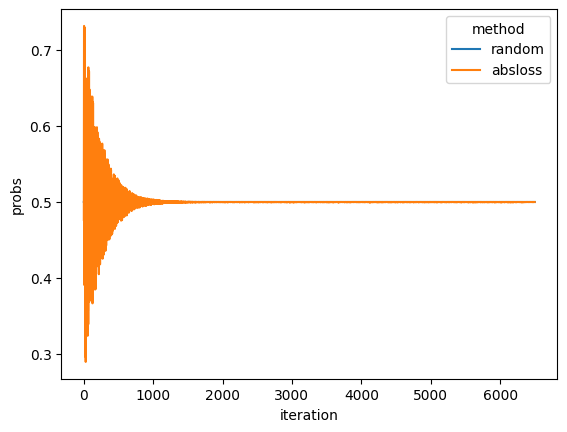

In [91]:
sns.lineplot(
    data=plot1_df, 
    x="iteration", 
    y="probs", 
    hue="method",
)

<Axes: xlabel='iteration', ylabel='train_accuracy'>

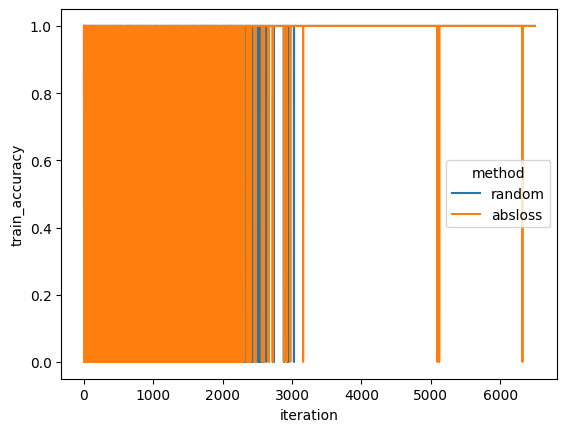

In [92]:
sns.lineplot(
    data=plot1_df, 
    x="iteration", 
    y="train_accuracy", 
    hue="method",
)

<Axes: xlabel='iteration', ylabel='train_loss'>

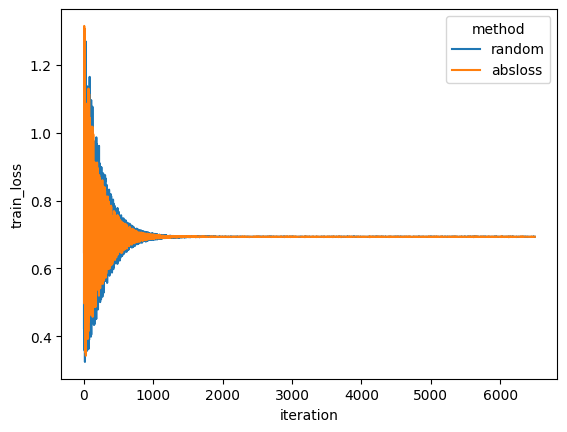

In [52]:
sns.lineplot(
    data=plot1_df, 
    x="iteration", 
    y="train_loss", 
    hue="method",
)

<Axes: xlabel='iteration', ylabel='test_accuracy'>

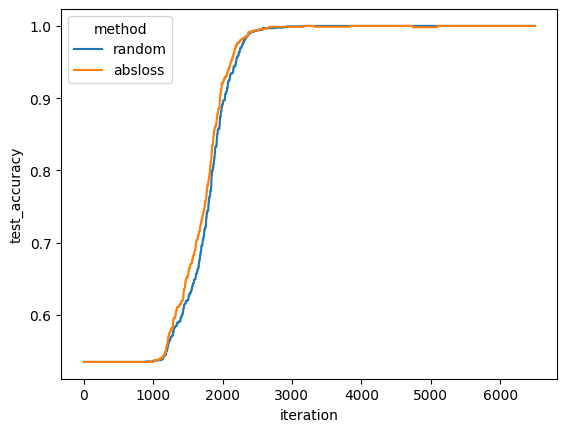

In [57]:
sns.lineplot(
    data=plot1_df, 
    x="iteration", 
    y="test_accuracy", 
    hue="method",
)

In [99]:
np.repeat(np.array([0.5,0.5,0.5,0.5]), 10)

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5])

In [103]:
list(range(1, 3000, 250))

[1, 501, 1001, 1501, 2001, 2501, 3001, 3501, 4001, 4501, 5001, 5501]

<Axes: xlabel='iteration', ylabel='test_loss'>

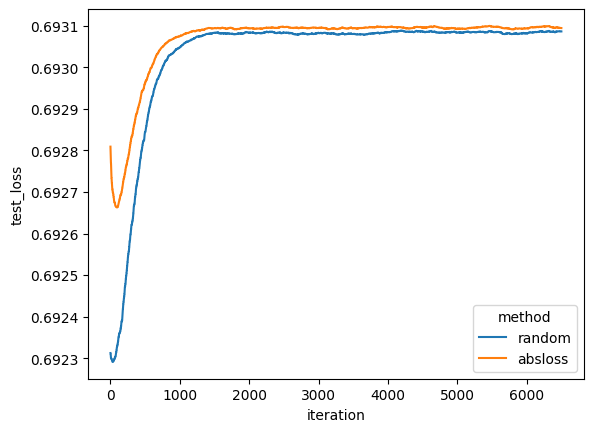

In [54]:
sns.lineplot(
    data=plot1_df, 
    x="iteration", 
    y="test_loss", 
    hue="method",
)

In [107]:
cross_entropy(
    p=np.array([0.5, 0.5]), 
    y=np.array([0,   1])
)

0.6931471805599453

In [71]:
prob_multiplier = [d_prob / np.mean(results_bec_absloss["probs"]) for d_prob in d_probs]

In [72]:
prob_multiplier

[1.999818208350872,
 1.6544164175277183,
 1.3686712477942502,
 1.132279010708793,
 0.9367156358094334,
 0.7749293010568196,
 0.6410861511001619,
 0.5303599342184182,
 0.43875797245262604,
 0.3629771895843448]

In [73]:
# Run this cell only if ~/workspace/milan_paper/polyak_becs_uniform.csv doesn't yet exist
bec_absloss_params = hyperparam_per_algo["bec-absloss"]

becs_absloss_results = {
    f"bec-absloss_{polyak_str}": train_model(
        X, y, Xtest, ytest, mode="bec-absloss", verbose=True, **(bec_absloss_params | {"prob_const": prob_multiplier})
    )
    for polyak_str, prob_multiplier in zip(polyak_strs, prob_multiplier)
}

Training with algorithm bec-absloss: 6499 iterations with d=6499
loss: 0.6927986005945063 theta: [0.82155499 0.91985277 0.65958645 ... 0.03509351 0.33950892 0.40905163]
loss: 0.6927072410559344 theta: [0.34904354 0.37236847 0.26339178 ... 0.01491257 0.14423515 0.17377297]
loss: 0.6928861669308904 theta: [0.14697915 0.15678009 0.1105949  ... 0.00627938 0.06073434 0.07316349]
loss: 0.6929976672531151 theta: [0.06246492 0.06660813 0.04697474 ... 0.0026678  0.0258029  0.03106582]
loss: 0.6930513183883765 theta: [0.02584882 0.02755116 0.01942312 ... 0.00110364 0.01041016 0.0120513 ]
loss: 0.6930778100223909 theta: [0.01059721 0.01128135 0.00795288 ... 0.00046755 0.00426781 0.004927  ]
loss: 0.6930892386596671 theta: [0.00434477 0.0046248  0.00326012 ... 0.00019177 0.00174965 0.00201448]
loss: 0.6930916595982277 theta: [2.31450513e-03 1.49740596e-03 1.33642070e-03 ... 8.57439757e-05
 7.12280664e-04 8.25373453e-04]
loss: 0.693094871510341 theta: [0.0009546  0.00061336 0.00052834 ... 0.0013025

loss: 0.6930968457456872 theta: [ 1.27292736e-05 -2.83751443e-05 -6.61435104e-06 ...  5.69916118e-06
 -1.72236876e-07 -8.26445482e-06]
loss: 0.6930954026834493 theta: [ 5.22567729e-06 -1.18915906e-05 -1.08552222e-05 ...  2.45146503e-06
 -4.30725136e-06 -1.81804785e-05]
Training with algorithm bec-absloss: 6499 iterations with d=6499
loss: 0.6924794228617271 theta: [0.23383042 0.86569208 0.03294257 ... 0.48322215 0.18319526 0.64093312]
loss: 0.6925454399743447 theta: [0.11056674 0.38904992 0.00118129 ... 0.22848328 0.08661366 0.30303837]
loss: 0.6927743597978708 theta: [0.05322537 0.18724763 0.00025332 ... 0.10997826 0.04169044 0.14586449]
loss: 0.692917122619017 theta: [0.0272822  0.09593475 0.00012275 ... 0.05634651 0.0213596  0.07471508]
loss: 0.6930056514903449 theta: [1.29116678e-02 4.53606382e-02 5.04566556e-05 ... 2.66425988e-02
 9.80225962e-03 3.44919118e-02]
loss: 0.6930530346977106 theta: [6.21500969e-03 2.18195691e-02 1.32000227e-05 ... 1.28395279e-02
 4.71822749e-03 1.659280

loss: 0.6930943401394095 theta: [ 8.48396538e-06 -5.43988641e-06 -6.69087476e-05 ...  9.77944442e-07
 -3.14534715e-06 -1.97146897e-05]
loss: 0.6930966743792423 theta: [ 4.11499336e-06 -8.11548168e-06 -3.13136209e-05 ...  5.50267905e-07
 -1.63458761e-06 -9.16616115e-06]
loss: 0.6930986538411935 theta: [ 8.04785470e-06 -1.79807364e-05 -2.37000642e-05 ...  2.60184583e-07
 -7.72917613e-07 -1.17224306e-05]
loss: 0.6930974722410709 theta: [ 1.47652137e-05 -8.58085281e-06 -1.13091612e-05 ...  3.32410551e-07
 -3.71873147e-07 -5.60566287e-06]
loss: 0.6930961901449372 theta: [ 7.37333269e-06 -4.40211660e-06 -5.76657251e-06 ...  2.96044029e-07
 -5.29406183e-06 -1.12002638e-05]
Training with algorithm bec-absloss: 6499 iterations with d=6499
loss: 0.692736148003411 theta: [0.89981961 0.54349792 0.92483996 ... 0.47821686 0.6010252  0.86618429]
loss: 0.6926330525439088 theta: [0.50401828 0.28294406 0.49408096 ... 0.26786505 0.33664964 0.48516085]
loss: 0.6927702765143295 theta: [0.26761039 0.1502186

loss: 0.693094008962622 theta: [ 7.97051552e-07 -2.30882084e-04 -3.79316068e-06 ...  2.56075138e-04
 -6.98634106e-06 -3.60815017e-05]
loss: 0.693092950123718 theta: [ 6.18295685e-06 -1.35486867e-04 -7.76902086e-06 ...  1.43434256e-04
 -3.91311905e-06 -2.03421341e-05]
loss: 0.6930965578925867 theta: [ 3.40259915e-06 -7.69781017e-05 -4.17618386e-06 ...  7.49182936e-05
 -2.21529313e-06 -1.09310897e-05]
loss: 0.6930990643240726 theta: [ 1.85767896e-06 -5.67650995e-05 -1.13282653e-05 ...  4.08559913e-05
 -1.20994338e-06 -1.36788378e-05]
loss: 0.6930986105691861 theta: [ 1.44022517e-06 -3.15135418e-05 -6.28892628e-06 ...  2.29071478e-05
 -6.74843821e-07 -7.60474075e-06]
loss: 0.6930969399779223 theta: [ 7.78241612e-07 -1.71706511e-05 -1.21997473e-05 ...  1.24025752e-05
 -5.89192724e-06 -2.02158175e-05]
Training with algorithm bec-absloss: 6499 iterations with d=6499
loss: 0.6929947235395567 theta: [0.19750494 0.89797641 0.41062075 ... 0.88715099 0.23151702 0.7270539 ]
loss: 0.692781344086069

loss: 0.6930950903723273 theta: [ 2.15429005e-05 -7.19395889e-04 -2.04558237e-04 ...  2.88404516e-04
 -2.25051655e-06 -6.22672743e-05]
loss: 0.6930959875844386 theta: [ 1.96396120e-05 -4.48578261e-04 -1.33965104e-04 ...  1.79791280e-04
 -1.40293544e-06 -3.90843682e-05]
loss: 0.6930958265993389 theta: [ 1.19249898e-05 -2.78821854e-04 -8.15841914e-05 ...  1.09123404e-04
 -1.02855472e-06 -2.40584278e-05]
loss: 0.6930982903316234 theta: [ 1.39596475e-05 -1.72619014e-04 -4.83850230e-05 ...  6.44820090e-05
 -6.07743516e-07 -1.45008615e-05]
loss: 0.6930957339679698 theta: [ 1.50573225e-05 -1.06652824e-04 -2.98947055e-05 ...  3.99564939e-05
 -3.78690660e-07 -1.54000949e-05]
loss: 0.6930948923099638 theta: [ 9.56042086e-06 -6.79816453e-05 -2.75455647e-05 ...  2.54975046e-05
 -2.43267964e-07 -1.00874122e-05]
Training with algorithm bec-absloss: 6499 iterations with d=6499
loss: 0.6921217896959294 theta: [0.02744769 0.3423395  0.39271336 ... 0.8418823  0.85458219 0.91559073]
loss: 0.6922533701059

loss: 0.6930917190063592 theta: [ 6.65061118e-05 -2.54707828e-06 -7.62039271e-05 ...  5.01754994e-04
 -3.60259489e-06 -7.11091757e-05]
loss: 0.693092294132977 theta: [ 4.33490974e-05 -1.94282702e-06 -4.98315422e-05 ...  3.27047026e-04
 -2.51067432e-06 -4.64801692e-05]
loss: 0.6930939490710382 theta: [ 2.66609487e-05 -7.85907883e-06 -3.69202835e-05 ...  2.00274430e-04
 -1.53745029e-06 -2.84650794e-05]
loss: 0.693097097388115 theta: [ 1.80286802e-05 -1.23658781e-05 -2.48557606e-05 ...  1.34079258e-04
 -1.02919545e-06 -1.93876571e-05]
loss: 0.6930970677283258 theta: [ 2.05634393e-05 -1.71642597e-05 -2.67514333e-05 ...  9.46962716e-05
 -7.29183211e-07 -2.20303899e-05]
loss: 0.6930978550304403 theta: [ 1.95016832e-05 -1.08925566e-05 -1.69764942e-05 ...  6.02408666e-05
 -4.62739121e-07 -2.05397143e-05]
loss: 0.6930965936512475 theta: [ 1.26007609e-05 -7.20527386e-06 -2.00439045e-05 ...  3.90602225e-05
 -3.01969997e-07 -2.23048642e-05]
Training with algorithm bec-absloss: 6499 iterations with

loss: 0.6930954396119234 theta: [ 1.41510695e-06 -3.74385332e-04 -5.35966291e-06 ...  1.12811908e-05
 -9.39534746e-06 -1.28884244e-04]
loss: 0.6930976099666556 theta: [ 9.90628094e-07 -2.62212504e-04 -3.88731490e-06 ...  7.90165348e-06
 -6.57664239e-06 -9.02219108e-05]
loss: 0.6930976189376248 theta: [ 7.02150652e-07 -1.85193099e-04 -2.88520636e-06 ...  5.58365676e-06
 -4.64479913e-06 -6.38879624e-05]
loss: 0.6930973773757364 theta: [ 8.31213667e-06 -1.44086388e-04 -1.98410764e-06 ...  3.83947993e-06
 -3.19384855e-06 -5.28254491e-05]
loss: 0.6930962847447925 theta: [ 1.34005676e-05 -9.90779685e-05 -1.36433027e-06 ...  2.64576393e-06
 -2.19934713e-06 -4.31833963e-05]
loss: 0.6930949457138932 theta: [ 9.46915779e-06 -6.99785173e-05 -1.11055664e-06 ...  1.86862594e-06
 -1.55577955e-06 -3.05073740e-05]
Training with algorithm bec-absloss: 6499 iterations with d=6499
loss: 0.6926255961900236 theta: [0.05069927 0.92838862 0.93498438 ... 0.67087033 0.09957054 0.07568649]
loss: 0.6925416240648

loss: 0.6930947095106802 theta: [ 1.91251048e-07 -3.05989386e-05 -9.49867679e-06 ...  3.65821689e-04
 -3.11092830e-06 -2.51464908e-05]
loss: 0.6930940729694793 theta: [ 1.47908419e-07 -2.32116620e-05 -7.34885494e-06 ...  2.77473162e-04
 -2.35956006e-06 -1.90794059e-05]
loss: 0.6930959222755868 theta: [ 2.80316028e-07 -1.69685019e-05 -5.44284935e-06 ...  1.99633357e-04
 -1.86932785e-06 -1.40478416e-05]
loss: 0.6930966463664742 theta: [ 2.18383161e-07 -1.32254370e-05 -4.41644437e-06 ...  1.55525725e-04
 -1.45636126e-06 -1.97456140e-05]
loss: 0.693097560255441 theta: [ 8.43077703e-06 -1.04888103e-05 -3.50257193e-06 ...  1.23349430e-04
 -1.15500157e-06 -2.35632182e-05]
loss: 0.6930979140420767 theta: [ 6.17551493e-06 -7.68226437e-06 -2.56903440e-06 ...  9.04412223e-05
 -8.47945746e-07 -1.74116768e-05]
Training with algorithm bec-absloss: 6499 iterations with d=6499
loss: 0.6928607022388016 theta: [0.66613347 0.67043462 0.64614833 ... 0.99776599 0.87198628 0.47549954]
loss: 0.69273967711967

loss: 0.6930961569998527 theta: [ 9.48732489e-06 -2.59510733e-05 -7.32385403e-06 ...  1.11187955e-06
 -4.89198330e-06 -2.51452043e-05]
loss: 0.6930956907893369 theta: [ 7.52678681e-06 -2.05867656e-05 -5.81427082e-06 ...  8.84675513e-07
 -3.87976658e-06 -2.92244628e-05]
Training with algorithm bec-absloss: 6499 iterations with d=6499
loss: 0.6927878314671218 theta: [0.64337272 0.1139918  0.86858577 ... 0.65440085 0.06442748 0.27971483]
loss: 0.6926697924156858 theta: [0.50571321 0.06433356 0.6827383  ... 0.51438185 0.05064223 0.21986552]
loss: 0.6926496637950961 theta: [0.43847395 0.05577982 0.59196169 ... 0.44599002 0.04390887 0.19063217]
loss: 0.6926491270972457 theta: [0.38017477 0.04836337 0.51324413 ... 0.38669151 0.03807078 0.1652753 ]
loss: 0.6926689370900234 theta: [0.32092634 0.04082615 0.4332573  ... 0.32642751 0.03160541 0.13951788]
loss: 0.6926942163100615 theta: [0.27825621 0.03539793 0.37565173 ... 0.28303403 0.02740318 0.12096751]
loss: 0.6927497229484687 theta: [0.214853

loss: 0.6920140331693281 theta: [0.54099604 0.46044457 0.1388634  ... 0.28712503 0.63153136 0.57008781]
loss: 0.6920978703709662 theta: [0.46490161 0.3956802  0.1193314  ... 0.24673913 0.54270259 0.48989139]
loss: 0.6922070001671258 theta: [0.385512   0.32811088 0.09894337 ... 0.20460436 0.45002717 0.405148  ]
loss: 0.6922819619896671 theta: [0.34026906 0.28959376 0.08733118 ... 0.18059239 0.39721286 0.35760062]
loss: 0.6924148265558902 theta: [0.26985884 0.22966953 0.06926016 ... 0.14322328 0.31501953 0.28360406]
loss: 0.6925243727254691 theta: [0.21786923 0.18542259 0.05591686 ... 0.11563063 0.2543295  0.22896636]
loss: 0.6925930716110381 theta: [0.18722458 0.15934176 0.04805181 ... 0.09983105 0.21855629 0.19676067]
loss: 0.6926683576091061 theta: [0.15526115 0.13213099 0.03983599 ... 0.08322756 0.1812342  0.16316053]
loss: 0.6927220471589773 theta: [0.13342271 0.11353615 0.03423281 ... 0.07152109 0.15574249 0.14021099]
loss: 0.6927731015758902 theta: [0.11363816 0.0966919  0.0291566

In [45]:
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
becs_absloss_results_file = os.path.join(notebook_dir, "bec_absloss_results_optimised_constant_pz_weighted_mean_loss_cv.pkl")

with open(becs_absloss_results_file, "wb") as f:
    pickle.dump(becs_absloss_results, f)

In [29]:
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
becs_absloss_results_file = os.path.join(notebook_dir, "bec_absloss_results_optimised_constant_pz_weighted_mean_loss_cv.pkl")

with open(becs_absloss_results_file, "rb") as f:
    becs_absloss_results = pickle.load(f)
    
for k in becs_absloss_results.keys():
    del becs_absloss_results[k]["thetas"]

## Plot Polyak-bec results

In [74]:
import re
df_test_losses = pd.DataFrame(
    [(re.findall("\d.\d", k)[0], v["labeled"], v["losses_test"], v["accuracies_test"]) 
     for k,v in polyak_becs2.items()]
)
df_test_losses.columns = ["polyak_exp", "labeled", "test_loss", "test_accuracy"]
df_test_losses = df_test_losses.explode(["test_loss", "test_accuracy"])
df_test_losses["iteration"] = df_test_losses.groupby('polyak_exp').cumcount()+1
df_test_losses = df_test_losses.reset_index()

In [75]:
df_test_losses["cost"] = [np.sum(labels[:iteration]) for iteration, labels in zip(df_test_losses.iteration, df_test_losses.labeled)]

(0.0, 6823.95)

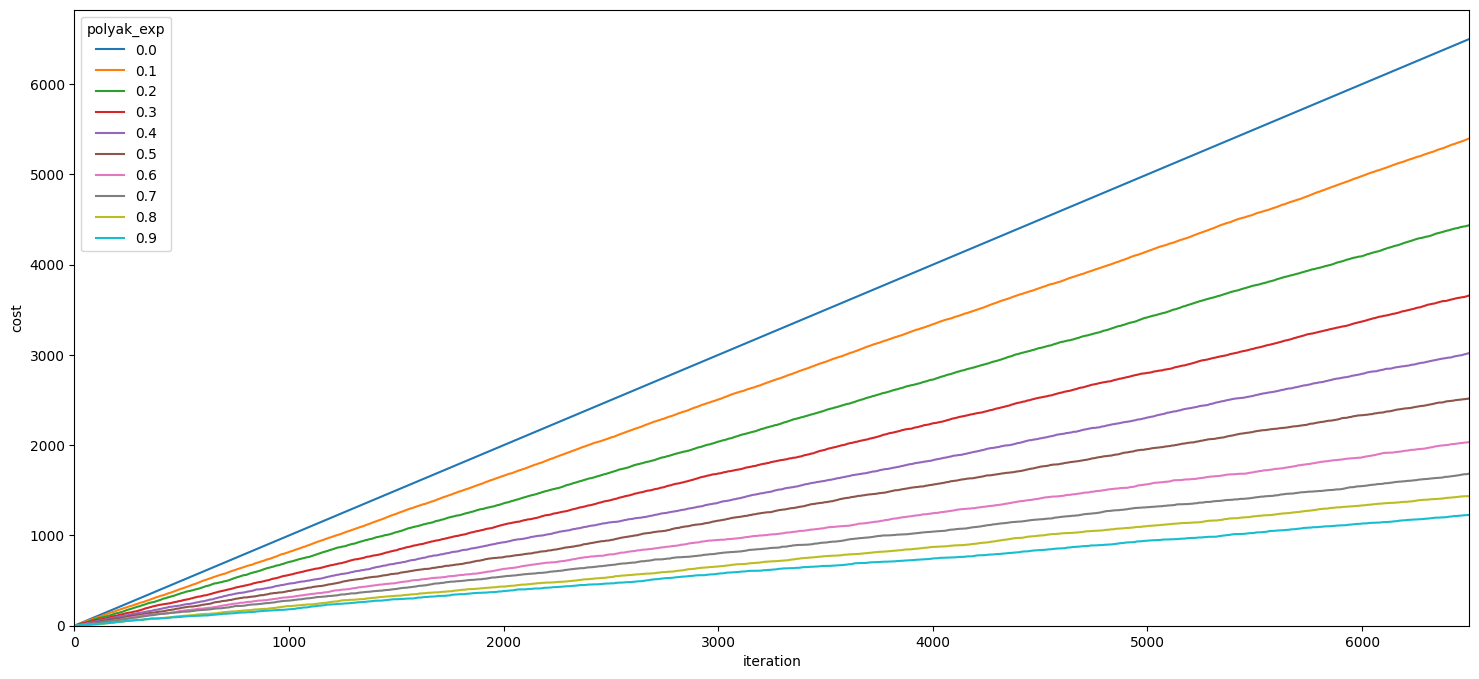

In [76]:
plt.figure(figsize=(18,8))

ax = sns.lineplot(data=df_test_losses, x="iteration", y="cost", hue="polyak_exp")
ax.set_xlim((0, 6500))
ax.set_ylim(bottom=0)

(0.0, 0.6932102750641616)

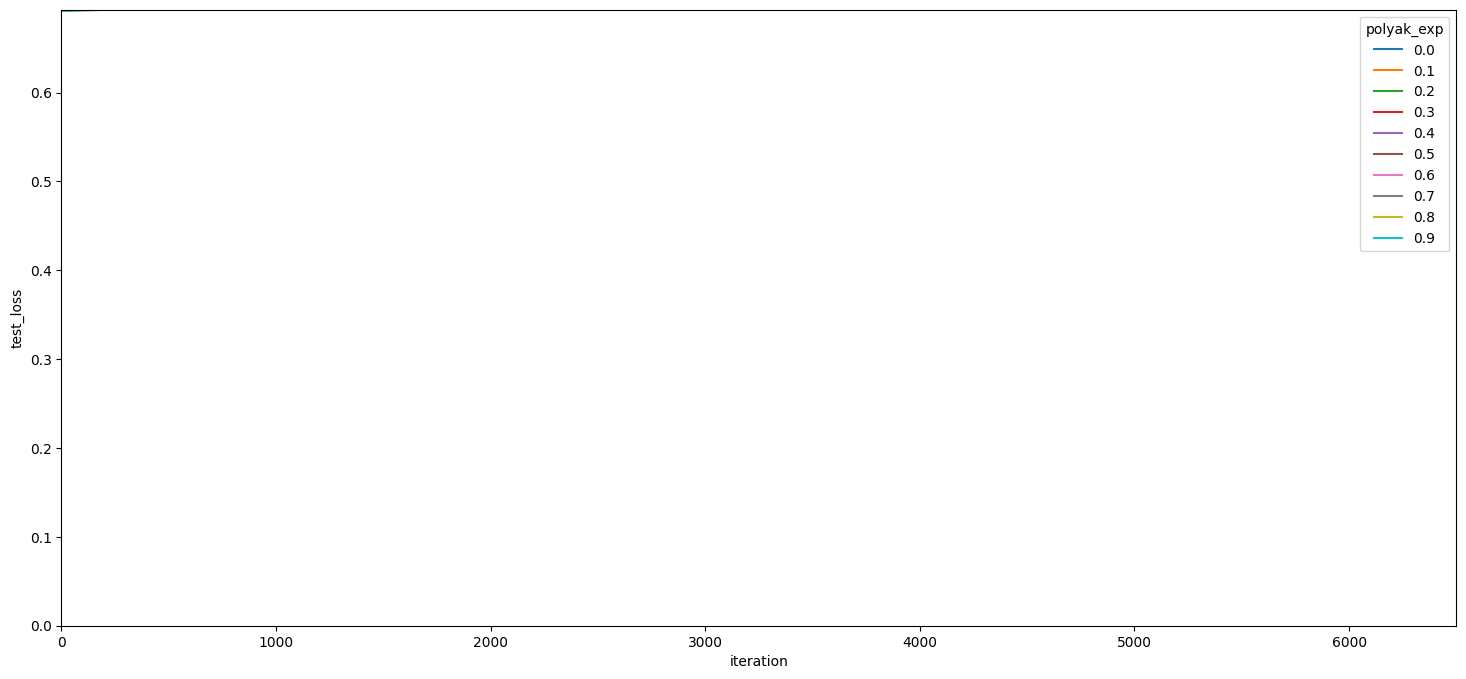

In [77]:
plt.figure(figsize=(18,8))

ax = sns.lineplot(data=df_test_losses, x="iteration", y="test_loss", hue="polyak_exp")
ax.set_xlim((0, 6500))
ax.set_ylim(bottom=0)

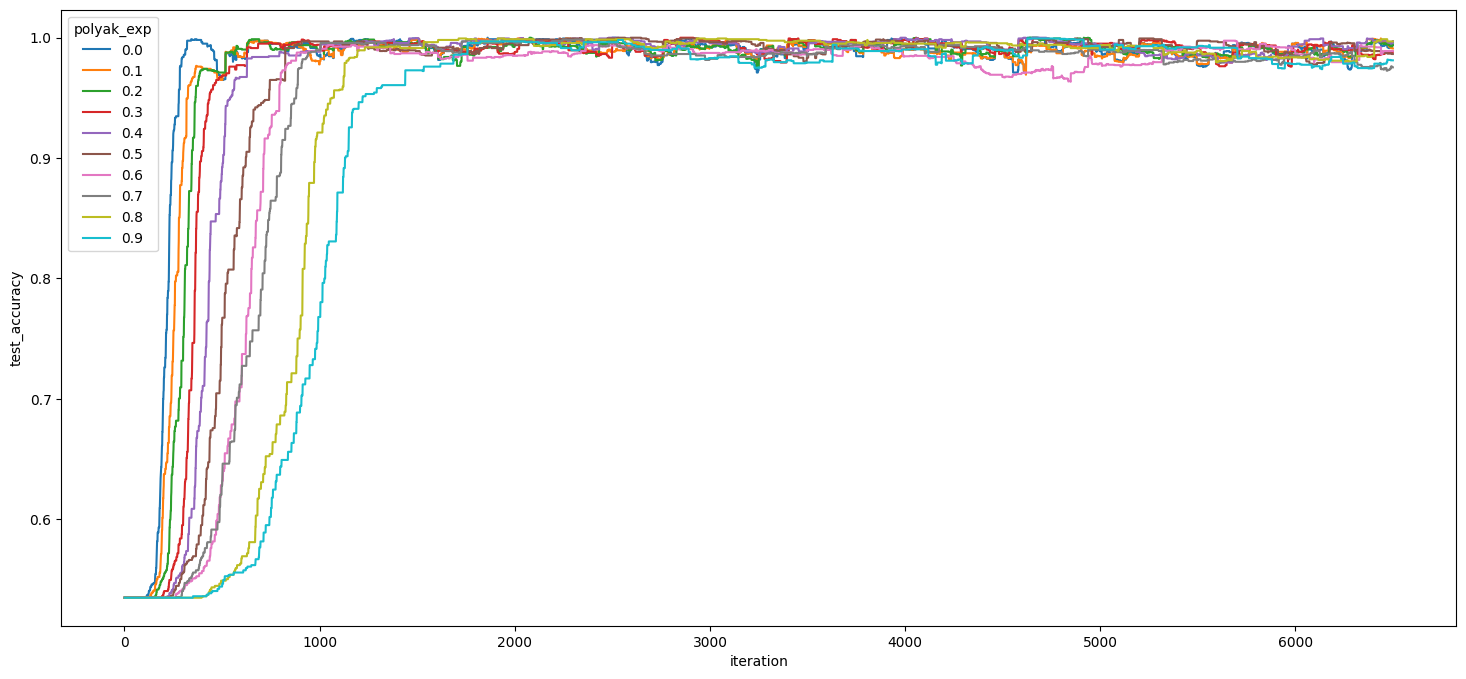

In [78]:
plt.figure(figsize=(18,8))

ax = sns.lineplot(data=df_test_losses, x="iteration", y="test_accuracy", hue="polyak_exp")

In [ ]:
plt.figure(figsize=(18,8))

ax = sns.lineplot(data=df_test_losses, x="cost", y="test_accuracy", hue="polyak_exp")
ax.set_xlim((0, 4000))

In [ ]:
plt.figure(figsize=(18,8))

ax = sns.lineplot(data=df_test_losses, x="cost", y="test_loss", hue="polyak_exp")
ax.set_xlim((0, 1000))
ax.set_ylim(bottom=0)

## Make comparison plots

In [79]:
df_test_losses["method"] = "polyak_absloss"

import re
df_test_losses_rand = pd.DataFrame(
    [(re.findall("\d.\d", k)[0], v["labeled"], v["losses_test"], v["accuracies_test"]) 
     for k,v in rand_results.items()]
)


df_test_losses_rand.columns = ["polyak_exp", "labeled", "test_loss", "test_accuracy"]
df_test_losses_rand = df_test_losses_rand.explode(["test_loss", "test_accuracy"])
df_test_losses_rand["iteration"] = df_test_losses_rand.groupby('polyak_exp').cumcount()+1
df_test_losses_rand = df_test_losses_rand.reset_index()
df_test_losses_rand["cost"] = [
    np.sum(labels[:iteration]) for iteration, labels in zip(df_test_losses_rand.iteration, df_test_losses_rand.labeled)
]
df_test_losses_rand["method"] = "rand"


import re
df_test_losses_bec_absloss = pd.DataFrame(
    [(re.findall("\d.\d", k)[0], v["labeled"], v["losses_test"], v["accuracies_test"]) 
     for k,v in becs_absloss_results.items()]
)


df_test_losses_bec_absloss.columns = ["polyak_exp", "labeled", "test_loss", "test_accuracy"]
df_test_losses_bec_absloss = df_test_losses_bec_absloss.explode(["test_loss", "test_accuracy"])
df_test_losses_bec_absloss["iteration"] = df_test_losses_bec_absloss.groupby('polyak_exp').cumcount()+1
df_test_losses_bec_absloss = df_test_losses_bec_absloss.reset_index()
df_test_losses_bec_absloss["cost"] = [
    np.sum(labels[:iteration]) for iteration, labels in zip(df_test_losses_bec_absloss.iteration, df_test_losses_bec_absloss.labeled)
]
df_test_losses_bec_absloss["method"] = "absloss"


import re
df_test_losses_polyak_rand = pd.DataFrame(
    [(re.findall("\d.\d", k)[0], v["labeled"], v["losses_test"], v["accuracies_test"]) 
     for k,v in polyak_rand_results.items()]
)
df_test_losses_polyak_rand.columns = ["polyak_exp", "labeled", "test_loss", "test_accuracy"]
df_test_losses_polyak_rand = df_test_losses_polyak_rand.explode(["test_loss", "test_accuracy"])
df_test_losses_polyak_rand["iteration"] = df_test_losses_polyak_rand.groupby('polyak_exp').cumcount()+1
df_test_losses_polyak_rand = df_test_losses_polyak_rand.reset_index()
df_test_losses_polyak_rand["cost"] = [
    np.sum(labels[:iteration]) for iteration, labels in zip(df_test_losses_polyak_rand.iteration, df_test_losses_polyak_rand.labeled)
]
df_test_losses_polyak_rand["method"] = "polyak_rand"

In [80]:
df_test_losses_rand

index polyak_exp                                            labeled   
0          0        0.0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...  \
1          0        0.0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
2          0        0.0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
3          0        0.0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
4          0        0.0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
...      ...        ...                                                ...   
64985      9        0.9  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...   
64986      9        0.9  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...   
64987      9        0.9  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...   
64988      9        0.9  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...   
64989      9        0.9  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...   

      test_loss test_accuracy  iteration    cost method  
0      0.692272      0.534769          1     1.0   rand  
1       0.69227      0.534769          2     2.0   rand  
2      0.692268      0.534769          3     3.0   rand  
3      0.692266      0.534769          4     4.0   rand  
4      0.692264      0.534769          5     5.0   rand  
...         ...           ...        ...     ...    ...  
64985  0.693085      0.967385       6495  1134.0   rand  
64986  0.693085      0.967385       6496  1134.0   rand  
64987  0.693085      0.967385       6497  1134.0   rand  
64988  0.693085      0.969846       6498  1135.0   rand  
64989  0.693085      0.969846       6499  1135.0   rand  

[64990 rows x 8 columns]

In [81]:
df_test_losses

index polyak_exp                                            labeled   
0          0        0.0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...  \
1          0        0.0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
2          0        0.0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
3          0        0.0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
4          0        0.0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
...      ...        ...                                                ...   
64985      9        0.9  [0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...   
64986      9        0.9  [0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...   
64987      9        0.9  [0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...   
64988      9        0.9  [0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...   
64989      9        0.9  [0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...   

      test_loss test_accuracy  iteration    cost          method  
0      0.691866      0.534769          1     1.0  polyak_absloss  
1      0.691888      0.534769          2     2.0  polyak_absloss  
2      0.691914      0.534769          3     3.0  polyak_absloss  
3      0.691945      0.534769          4     4.0  polyak_absloss  
4      0.691978      0.534769          5     5.0  polyak_absloss  
...         ...           ...        ...     ...             ...  
64985  0.693139      0.981231       6495  1227.0  polyak_absloss  
64986  0.693139      0.981231       6496  1227.0  polyak_absloss  
64987  0.693139      0.981231       6497  1227.0  polyak_absloss  
64988  0.693139      0.981231       6498  1227.0  polyak_absloss  
64989  0.693139      0.981231       6499  1227.0  polyak_absloss  

[64990 rows x 8 columns]

In [82]:
df_test_losses_polyak_rand

index polyak_exp                                            labeled   
0          0        0.0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...  \
1          0        0.0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
2          0        0.0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
3          0        0.0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
4          0        0.0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
...      ...        ...                                                ...   
64985      9        0.9  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
64986      9        0.9  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
64987      9        0.9  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
64988      9        0.9  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
64989      9        0.9  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

      test_loss test_accuracy  iteration    cost       method  
0      0.691856      0.534769          1     1.0  polyak_rand  
1      0.691868      0.534769          2     2.0  polyak_rand  
2      0.691879      0.534769          3     3.0  polyak_rand  
3      0.691896      0.534769          4     4.0  polyak_rand  
4      0.691912      0.534769          5     5.0  polyak_rand  
...         ...           ...        ...     ...          ...  
64985  0.693114      0.998769       6495  1150.0  polyak_rand  
64986  0.693114      0.998769       6496  1150.0  polyak_rand  
64987  0.693114      0.998769       6497  1151.0  polyak_rand  
64988   0.69311      0.998769       6498  1152.0  polyak_rand  
64989   0.69311      0.998769       6499  1152.0  polyak_rand  

[64990 rows x 8 columns]

In [83]:
df_test_losses_bec_absloss[df_test_losses_bec_absloss.iteration == 6499]

index polyak_exp                                            labeled   
6498       0        0.0  [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...  \
12997      1        0.1  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...   
19496      2        0.2  [0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, ...   
25995      3        0.3  [0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, ...   
32494      4        0.4  [0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...   
38993      5        0.5  [1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...   
45492      6        0.6  [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...   
51991      7        0.7  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
58490      8        0.8  [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...   
64989      9        0.9  [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, ...   

      test_loss test_accuracy  iteration    cost   method  
6498   0.693094           1.0       6499  6486.0  absloss  
12997  0.693094           1.0       6499  5382.0  absloss  
19496  0.693094           1.0       6499  4409.0  absloss  
25995  0.693093           1.0       6499  3700.0  absloss  
32494  0.693097      0.998154       6499  3012.0  absloss  
38993  0.693095           1.0       6499  2509.0  absloss  
45492  0.693097           1.0       6499  2015.0  absloss  
51991  0.693095           1.0       6499  1699.0  absloss  
58490  0.693096           1.0       6499  1383.0  absloss  
64989  0.693093      0.996308       6499  1268.0  absloss

In [84]:
df_test_losses = pd.concat([df_test_losses_rand, df_test_losses_bec_absloss, df_test_losses, df_test_losses_polyak_rand])

/var/folders/s7/8k0y__9d35n2x08wq1cqf9j00000gn/T/ipykernel_6943/981126154.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot2["method"] = ["polyak_exponent" if method == "polyak_absloss" else method for method in df_plot2.method]


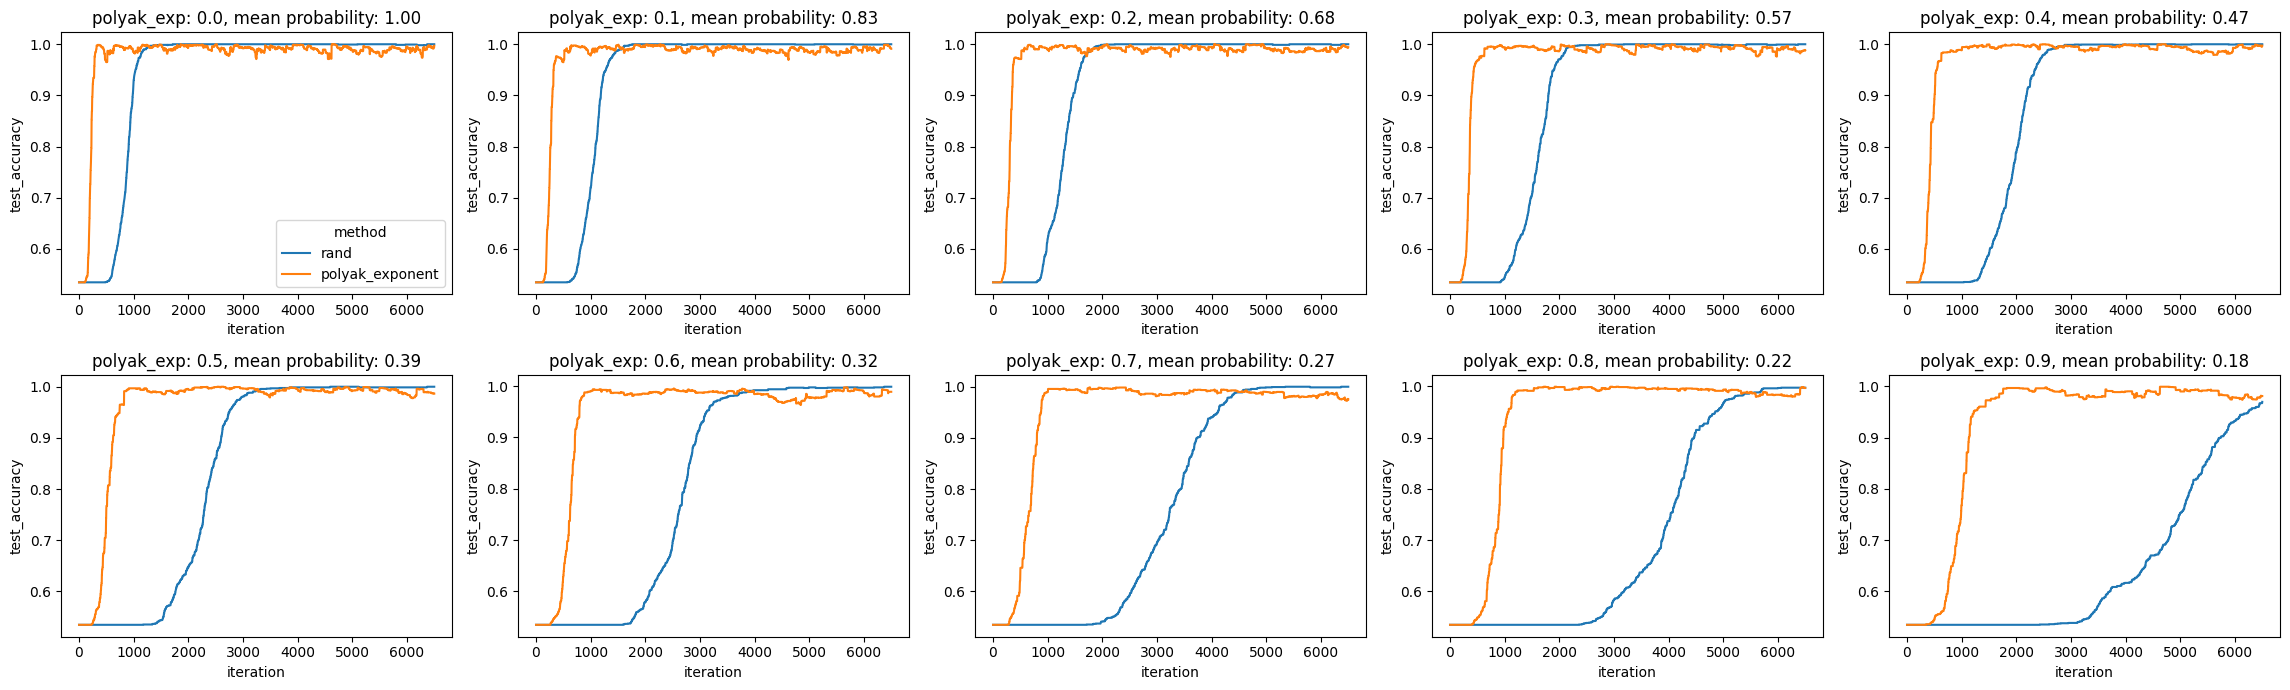

In [150]:
f, axs = plt.subplots(2, 5, figsize=(23, 7))
handles, labels = [], []

df_plot2 = df_test_losses[df_test_losses.method.isin(["rand", "polyak_absloss"])]
df_plot2["method"] = ["polyak_exponent" if method == "polyak_absloss" else method for method in df_plot2.method]
for i, polyak_exp in enumerate(sorted(list(set(df_test_losses.polyak_exp)))):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    # Create the line plot on the current axis
    sns.lineplot(
        data=df_plot2[df_plot2.polyak_exp == polyak_exp], 
        x="iteration", 
        y="test_accuracy", 
        hue="method",
        #legend=False,
        ax=ax
    )
    # Display the legend only for the first plot
    #if i == 0:
    #    ax.legend()
    
    ax.set_title(f"polyak_exp: {polyak_exp}, mean probability: {d_probs[i]:.2f}")
    
    # Collect handles and labels for this subplot
    if i == 0:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    else:
        ax.get_legend().remove()
    
#axs[0][0].legend()
#f.legend(handles, labels)

f.tight_layout()

/var/folders/s7/8k0y__9d35n2x08wq1cqf9j00000gn/T/ipykernel_6943/3169719096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot2["method"] = ["polyak_exponent" if method == "polyak_absloss" else method for method in df_plot2.method]


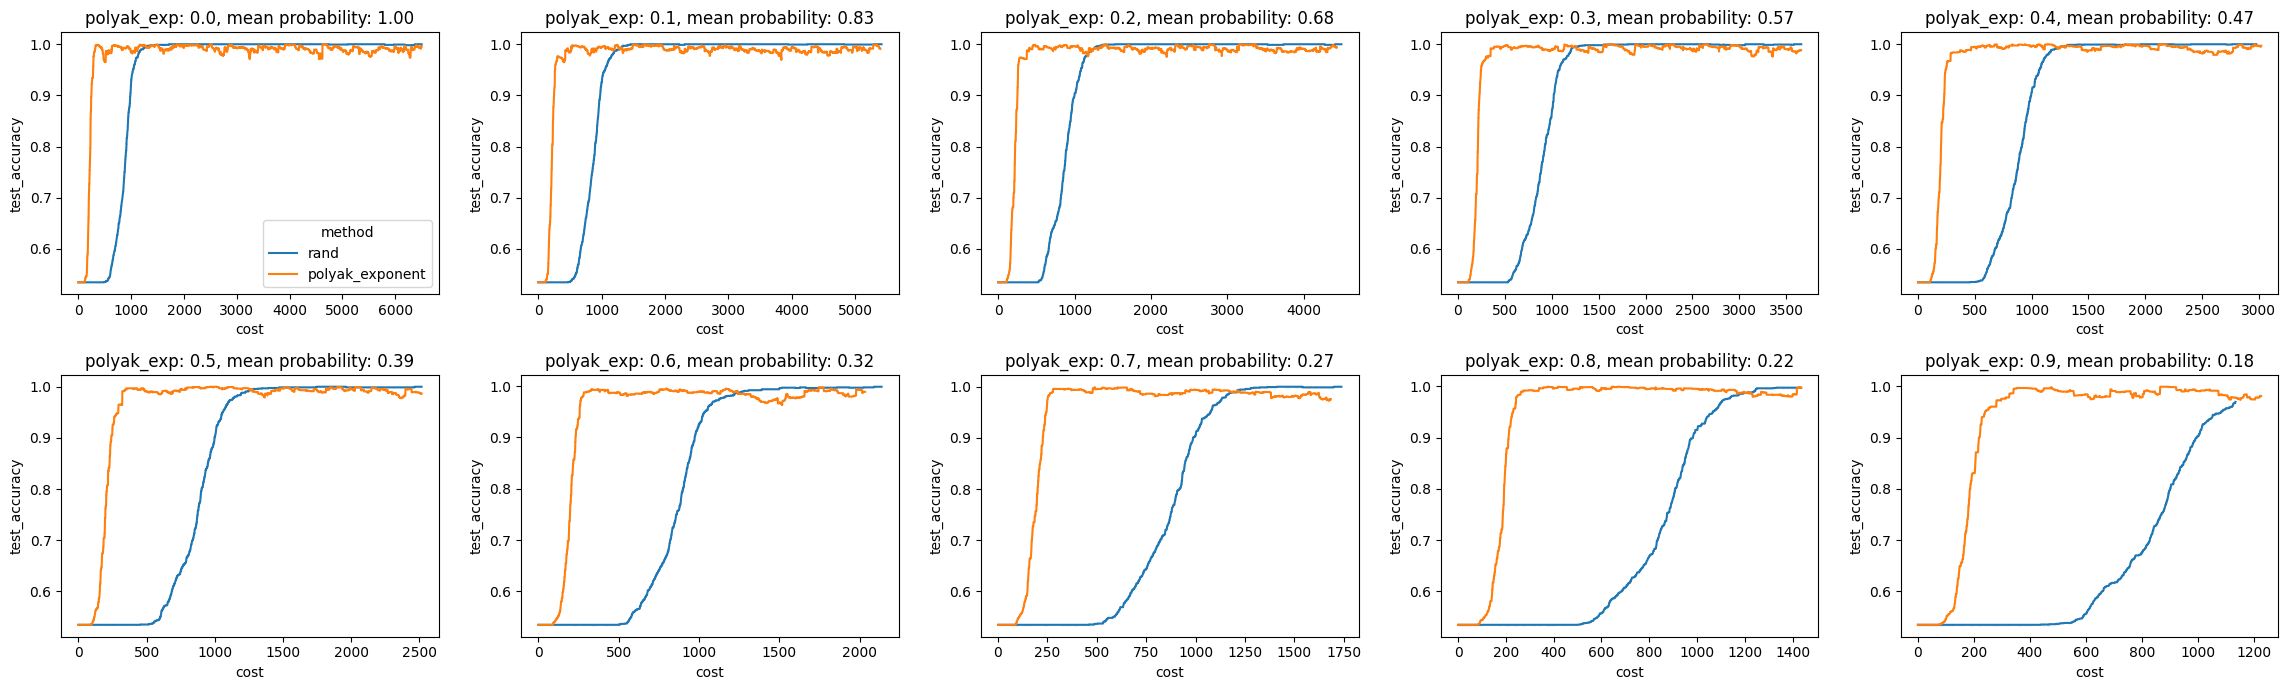

In [151]:
f, axs = plt.subplots(2, 5, figsize=(23, 7))
handles, labels = [], []

df_plot2 = df_test_losses[df_test_losses.method.isin(["rand", "polyak_absloss"])]
df_plot2["method"] = ["polyak_exponent" if method == "polyak_absloss" else method for method in df_plot2.method]
for i, polyak_exp in enumerate(sorted(list(set(df_test_losses.polyak_exp)))):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    # Create the line plot on the current axis
    sns.lineplot(
        data=df_plot2[df_plot2.polyak_exp == polyak_exp], 
        x="cost", 
        y="test_accuracy", 
        hue="method",
        #legend=False,
        ax=ax
    )
    # Display the legend only for the first plot
    #if i == 0:
    #    ax.legend()
    
    ax.set_title(f"polyak_exp: {polyak_exp}, mean probability: {d_probs[i]:.2f}")
    
    # Collect handles and labels for this subplot
    if i == 0:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    else:
        ax.get_legend().remove()
    
#axs[0][0].legend()
#f.legend(handles, labels)

f.tight_layout()

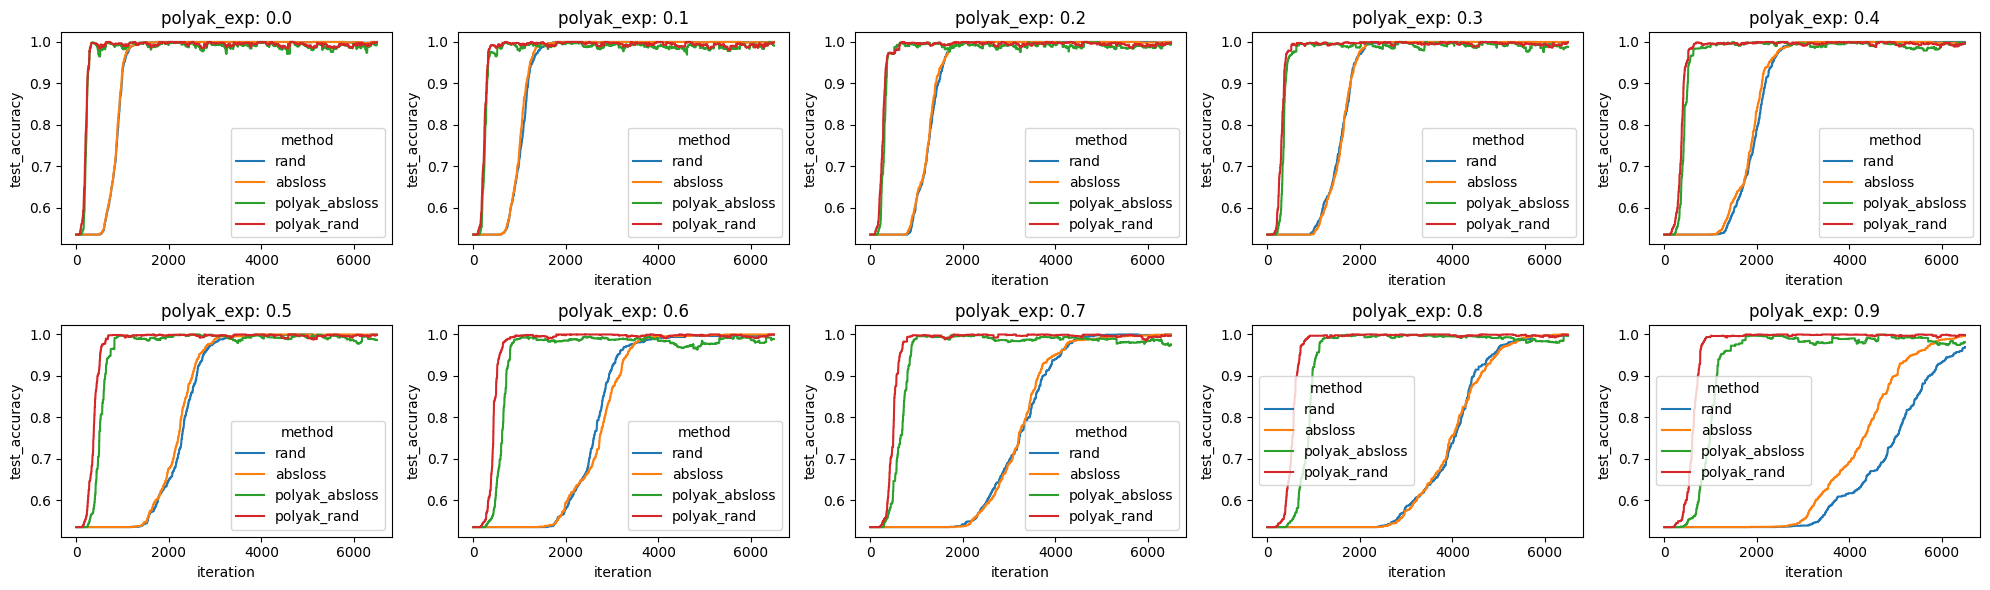

In [137]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))

for i, polyak_exp in enumerate(sorted(list(set(df_test_losses.polyak_exp)))):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    # Create the line plot on the current axis
    sns.lineplot(
        data=df_test_losses[df_test_losses.polyak_exp == polyak_exp], 
        x="iteration", 
        y="test_accuracy", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"polyak_exp: {polyak_exp}")
    
f.tight_layout()

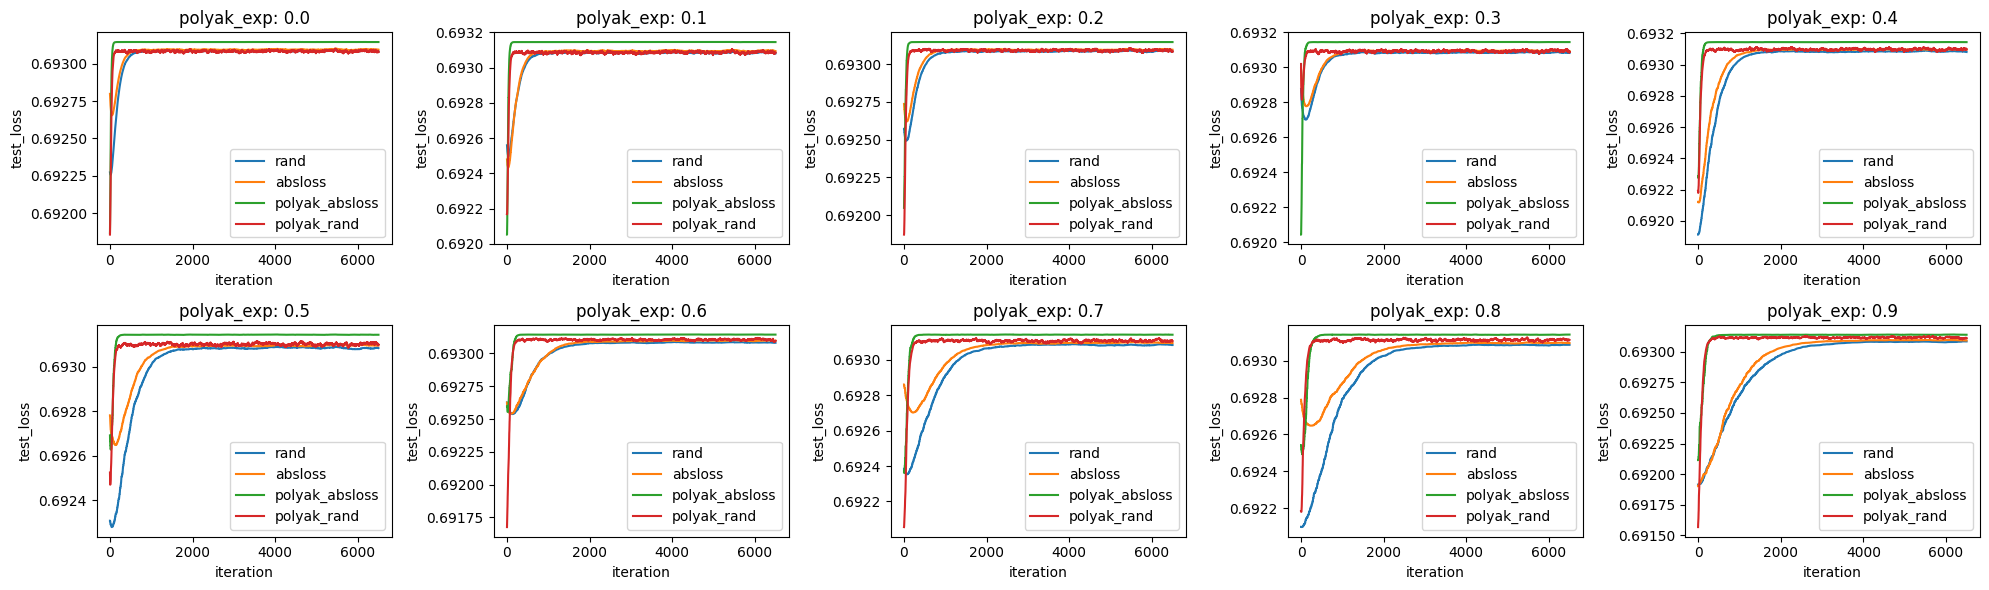

In [90]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
for i, polyak_exp in enumerate(sorted(list(set(df_test_losses.polyak_exp)))):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    # Create the line plot on the current axis
    sns.lineplot(
        data=df_test_losses[df_test_losses.polyak_exp == polyak_exp], 
        x="iteration", 
        y="test_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"polyak_exp: {polyak_exp}")
    ax.legend()
f.tight_layout()

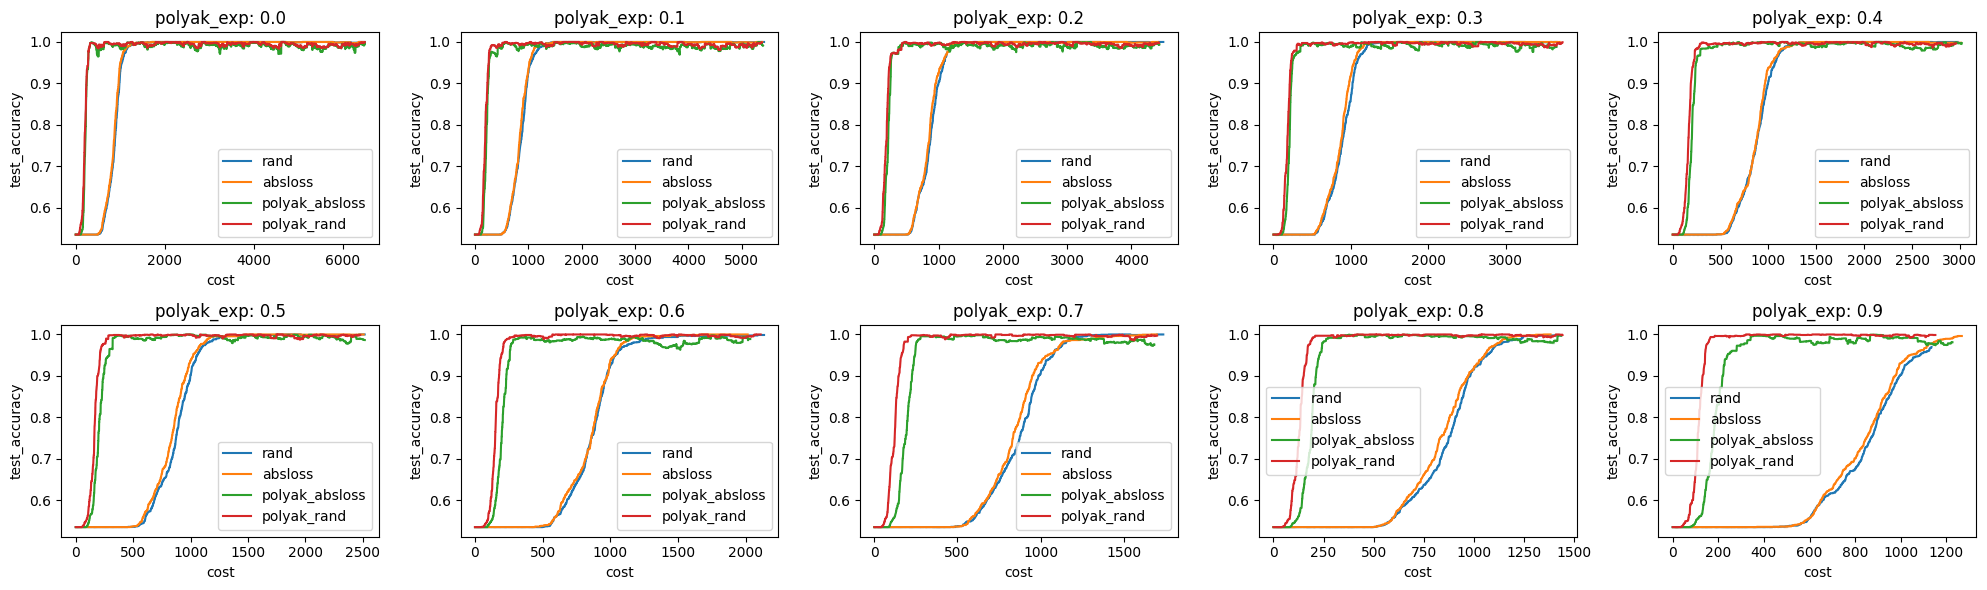

In [88]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
for i, polyak_exp in enumerate(sorted(list(set(df_test_losses.polyak_exp)))):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    # Create the line plot on the current axis
    sns.lineplot(
        data=df_test_losses[df_test_losses.polyak_exp == polyak_exp], 
        x="cost", 
        y="test_accuracy", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"polyak_exp: {polyak_exp}")
    ax.legend()
f.tight_layout()

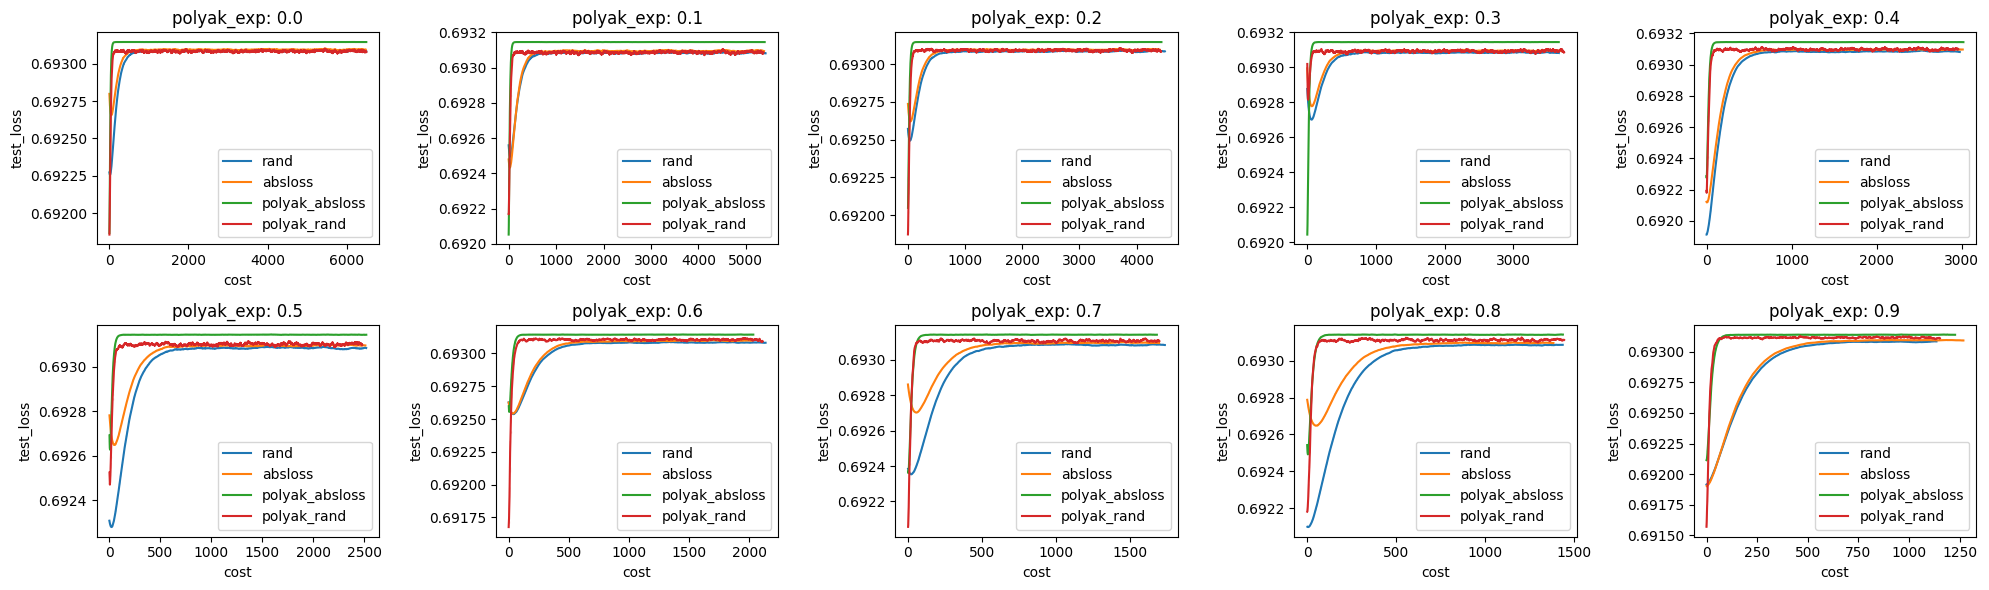

In [89]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
for i, polyak_exp in enumerate(sorted(list(set(df_test_losses.polyak_exp)))):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    # Create the line plot on the current axis
    sns.lineplot(
        data=df_test_losses[df_test_losses.polyak_exp == polyak_exp], 
        x="cost", 
        y="test_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"polyak_exp: {polyak_exp}")
    ax.legend()
f.tight_layout()

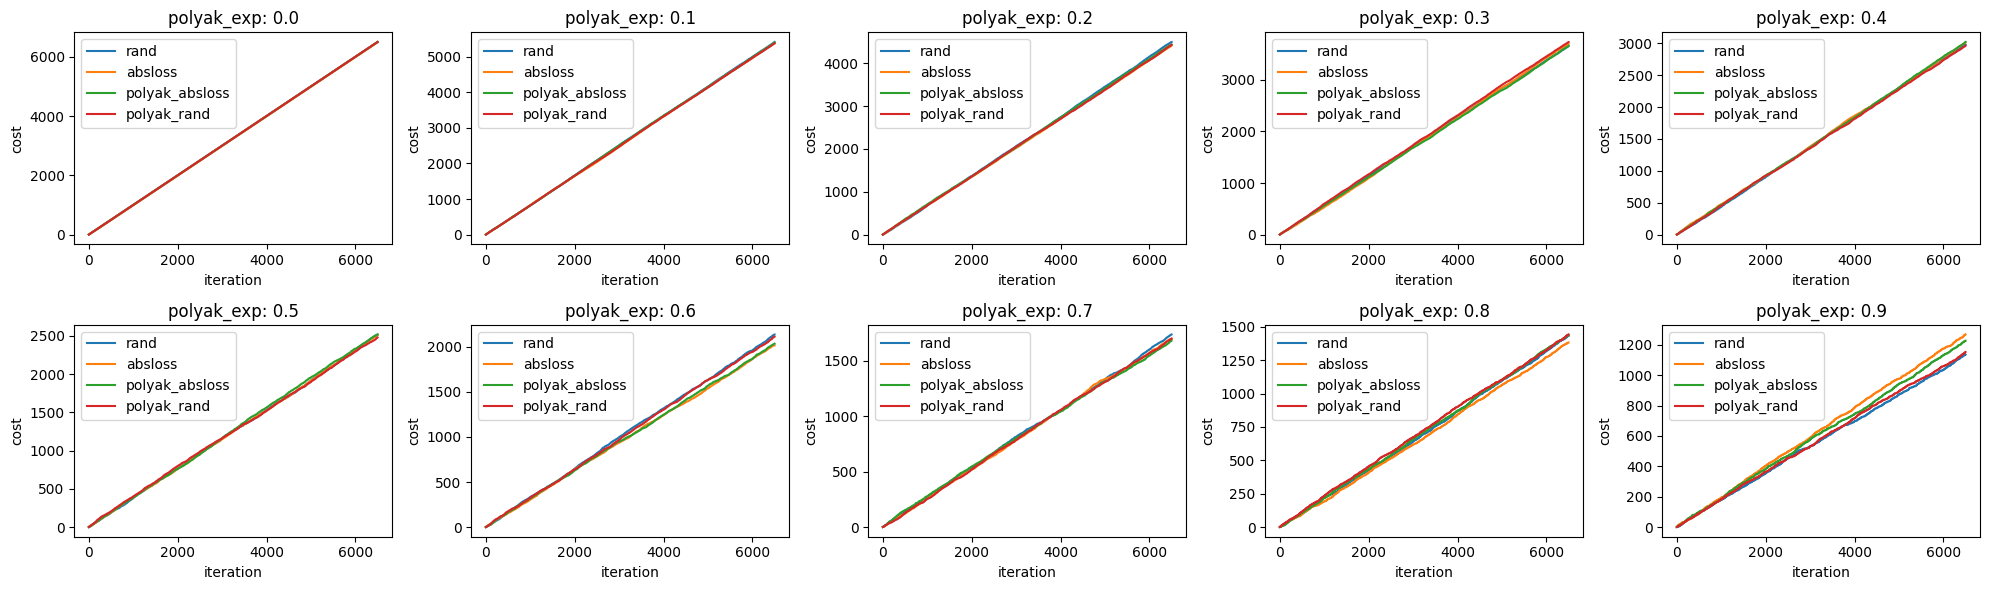

In [87]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
for i, polyak_exp in enumerate(sorted(list(set(df_test_losses.polyak_exp)))):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    # Create the line plot on the current axis
    sns.lineplot(
        data=df_test_losses[df_test_losses.polyak_exp == polyak_exp], 
        x="iteration", 
        y="cost", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"polyak_exp: {polyak_exp}")
    ax.legend()
f.tight_layout()

In [43]:
for r in rand_results.keys():
    print(f"{r}: {np.mean(rand_results[r]['probs'])}")


rand_0.0: 1.0
rand_0.1: 0.7745240529580661
rand_0.2: 0.5998875086105891
rand_0.3: 0.46462730448799056
rand_0.4: 0.35986502298701983
rand_0.5: 0.27872411612175435
rand_0.6: 0.2158785320757759
rand_0.7: 0.16720311560996784
rand_0.8: 0.1295028347694484
rand_0.9: 0.10030306045519197


In [44]:
for r in polyak_becs2.keys():
    print(f"{r}: {np.mean(polyak_becs2[r]['probs'])}")


polyak_bec_0.0: 1.0
polyak_bec_0.1: 0.7419212721953483
polyak_bec_0.2: 0.5504471741359643
polyak_bec_0.3: 0.408388467711289
polyak_bec_0.4: 0.3029920915142684
polyak_bec_0.5: 0.22479627800139557
polyak_bec_0.6: 0.1667811405595745
polyak_bec_0.7: 0.12373847598215079
polyak_bec_0.8: 0.09180420752019085
polyak_bec_0.9: 0.06811149443626574


In [45]:
for r in polyak_rand_results.keys():
    print(f"{r}: {np.mean(polyak_rand_results[r]['probs'])}")

polyak_rand_0.0: 1.0
polyak_rand_0.1: 0.7745240529580661
polyak_rand_0.2: 0.5998875086105891
polyak_rand_0.3: 0.46462730448799056
polyak_rand_0.4: 0.35986502298701983
polyak_rand_0.5: 0.27872411612175435
polyak_rand_0.6: 0.2158785320757759
polyak_rand_0.7: 0.16720311560996784
polyak_rand_0.8: 0.1295028347694484
polyak_rand_0.9: 0.10030306045519197


In [46]:
for r in becs_absloss_results.keys():
    print(f"{r}: {np.mean(becs_absloss_results[r]['probs'])}")


bec-absloss_0.0: 0.9927062163792975
bec-absloss_0.1: 0.7748089287665765
bec-absloss_0.2: 0.6001138454239615
bec-absloss_0.3: 0.46480860781038985
bec-absloss_0.4: 0.35965045429675674
bec-absloss_0.5: 0.278694930109958
bec-absloss_0.6: 0.21557566129648265
bec-absloss_0.7: 0.166865114612842
bec-absloss_0.8: 0.1294103533801973
bec-absloss_0.9: 0.10002878191273452


In [47]:
2

2